# RosettaSurf - a surface-centric computational design approach

In [1]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline

import itertools
import os
import sys
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import table
import rstoolbox as rsb
import scipy as sp
import seaborn as sns

from IPython.display import display

## Common abbreviations throughout the notebook

* ss or si = shape similarity
* es = electrostatic similarity
* sses = surface similarity (SurfS score described in the paper)
* sc = shape complementarity
* ec = electrostatic complementarity

The below cell is required to compute the surface similarity scores.

In [2]:
intercept = -13.79986756 
coef1 = -13.78594078
coef2 = 14.64347448

def surf_score(ss, es):
    return 1/(1+np.exp(-(intercept + coef1 * es + coef2 * ss)))

# Surface similarity score optimization

## Data Preprocessing

Loadind input data and removing duplicate protein complexes, as well as incomplete data points (usually missing ES values)

In [3]:
swb_ala = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_ala.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_arg = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_arg.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_asn = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_asn.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_asp = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_asp.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_gln = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_gln.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_glu = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_glu.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_gly = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_gly.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_his = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_his.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_ile = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_ile.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_leu = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_leu.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_lys = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_lys.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_met = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_met.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_phe = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_phe.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_pro = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_pro.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_ser = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_ser.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_thr = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_thr.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_trp = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_trp.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_tyr = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_tyr.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)
swb_val = rsb.io.parse_rosetta_file('./data/surface_weight_optimization/recover_val.sc').dropna().drop_duplicates(subset='description').drop(['si_cys', 'ec_cys_avg', 'ec_cys_p', 'ec_cys_s'], axis=1).head(140)

In [4]:
swbs = [swb_ala, swb_arg, swb_asn, swb_asp, swb_gln, swb_glu, swb_gly, swb_his, swb_ile, swb_leu, swb_lys,
       swb_met, swb_phe, swb_pro, swb_ser, swb_thr, swb_trp, swb_tyr, swb_val]
for s in swbs:
    print(s.shape)

(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)
(140, 137)


In [5]:
ala_optimize_for_ec = []
ala_optimize_against_ec = []
ala_optimize_for_si = []
ala_optimize_against_si = []

arg_optimize_for_ec = []
arg_optimize_against_ec = []
arg_optimize_for_si = []
arg_optimize_against_si = []

asn_optimize_for_ec = []
asn_optimize_against_ec = []
asn_optimize_for_si = []
asn_optimize_against_si = []

asp_optimize_for_ec = []
asp_optimize_against_ec = []
asp_optimize_for_si = []
asp_optimize_against_si = []

gln_optimize_for_ec = []
gln_optimize_against_ec = []
gln_optimize_for_si = []
gln_optimize_against_si = []

glu_optimize_for_ec = []
glu_optimize_against_ec = []
glu_optimize_for_si = []
glu_optimize_against_si = []

gly_optimize_for_ec = []
gly_optimize_against_ec = []
gly_optimize_for_si = []
gly_optimize_against_si = []

his_optimize_for_ec = []
his_optimize_against_ec = []
his_optimize_for_si = []
his_optimize_against_si = []

ile_optimize_for_ec = []
ile_optimize_against_ec = []
ile_optimize_for_si = []
ile_optimize_against_si = []

leu_optimize_for_ec = []
leu_optimize_against_ec = []
leu_optimize_for_si = []
leu_optimize_against_si = []

lys_optimize_for_ec = []
lys_optimize_against_ec = []
lys_optimize_for_si = []
lys_optimize_against_si = []

met_optimize_for_ec = []
met_optimize_against_ec = []
met_optimize_for_si = []
met_optimize_against_si = []

phe_optimize_for_ec = []
phe_optimize_against_ec = []
phe_optimize_for_si = []
phe_optimize_against_si = []

pro_optimize_for_ec = []
pro_optimize_against_ec = []
pro_optimize_for_si = []
pro_optimize_against_si = []

ser_optimize_for_ec = []
ser_optimize_against_ec = []
ser_optimize_for_si = []
ser_optimize_against_si = []

thr_optimize_for_ec = []
thr_optimize_against_ec = []
thr_optimize_for_si = []
thr_optimize_against_si = []

trp_optimize_for_ec = []
trp_optimize_against_ec = []
trp_optimize_for_si = []
trp_optimize_against_si = []

tyr_optimize_for_ec = []
tyr_optimize_against_ec = []
tyr_optimize_for_si = []
tyr_optimize_against_si = []

val_optimize_for_ec = []
val_optimize_against_ec = []
val_optimize_for_si = []
val_optimize_against_si = []



In [6]:
for i in swb_ala.columns:
    if i == 'si_ala':
        ala_optimize_for_si = swb_ala[i].tolist()
    elif i == 'ec_ala_avg':
        ala_optimize_for_ec = swb_ala[i].tolist()
    elif 'si' in i:
        ala_optimize_against_si.extend(swb_ala[i].tolist())
    elif '_avg' in i:
        ala_optimize_against_ec.extend(swb_ala[i].tolist())

In [7]:
for i in swb_arg.columns:
    if i == 'si_arg':
        arg_optimize_for_si = swb_arg[i].tolist()
    elif i == 'ec_arg_avg':
        arg_optimize_for_ec = swb_arg[i].tolist()
    elif 'si' in i:
        arg_optimize_against_si.extend(swb_arg[i].tolist())
    elif '_avg' in i:
        arg_optimize_against_ec.extend(swb_arg[i].tolist())

In [8]:
for i in swb_asn.columns:
    if i == 'si_asn':
        asn_optimize_for_si = swb_asn[i].tolist()
    elif i == 'ec_asn_avg':
        asn_optimize_for_ec = swb_asn[i].tolist()
    elif 'si' in i:
        asn_optimize_against_si.extend(swb_asn[i].tolist())
    elif '_avg' in i:
        asn_optimize_against_ec.extend(swb_asn[i].tolist())

In [9]:
for i in swb_asp.columns:
    if i == 'si_asp':
        asp_optimize_for_si = swb_asp[i].tolist()
    elif i == 'ec_asp_avg':
        asp_optimize_for_ec = swb_asp[i].tolist()
    elif 'si' in i:
        asp_optimize_against_si.extend(swb_asp[i].tolist())
    elif '_avg' in i:
        asp_optimize_against_ec.extend(swb_asp[i].tolist())

In [10]:
for i in swb_gln.columns:
    if i == 'si_gln':
        gln_optimize_for_si = swb_gln[i].tolist()
    elif i == 'ec_gln_avg':
        gln_optimize_for_ec = swb_gln[i].tolist()
    elif 'si' in i:
        gln_optimize_against_si.extend(swb_gln[i].tolist())
    elif '_avg' in i:
        gln_optimize_against_ec.extend(swb_gln[i].tolist())

In [11]:
for i in swb_glu.columns:
    if i == 'si_glu':
        glu_optimize_for_si = swb_glu[i].tolist()
    elif i == 'ec_glu_avg':
        glu_optimize_for_ec = swb_glu[i].tolist()
    elif 'si' in i:
        glu_optimize_against_si.extend(swb_glu[i].tolist())
    elif '_avg' in i:
        glu_optimize_against_ec.extend(swb_glu[i].tolist())

In [12]:
for i in swb_gly.columns:
    if i == 'si_gly':
        gly_optimize_for_si = swb_gly[i].tolist()
    elif i == 'ec_gly_avg':
        gly_optimize_for_ec = swb_gly[i].tolist()
    elif 'si' in i:
        gly_optimize_against_si.extend(swb_gly[i].tolist())
    elif '_avg' in i:
        gly_optimize_against_ec.extend(swb_gly[i].tolist())

In [13]:
for i in swb_his.columns:
    if i == 'si_his':
        his_optimize_for_si = swb_his[i].tolist()
    elif i == 'ec_his_avg':
        his_optimize_for_ec = swb_his[i].tolist()
    elif 'si' in i:
        his_optimize_against_si.extend(swb_his[i].tolist())
    elif '_avg' in i:
        his_optimize_against_ec.extend(swb_his[i].tolist())

In [14]:
for i in swb_ile.columns:
    if i == 'si_ile':
        ile_optimize_for_si = swb_ile[i].tolist()
    elif i == 'ec_ile_avg':
        ile_optimize_for_ec = swb_ile[i].tolist()
    elif 'si' in i:
        ile_optimize_against_si.extend(swb_ile[i].tolist())
    elif '_avg' in i:
        ile_optimize_against_ec.extend(swb_ile[i].tolist())

In [15]:
for i in swb_leu.columns:
    if i == 'si_leu':
        leu_optimize_for_si = swb_leu[i].tolist()
    elif i == 'ec_leu_avg':
        leu_optimize_for_ec = swb_leu[i].tolist()
    elif 'si' in i:
        leu_optimize_against_si.extend(swb_leu[i].tolist())
    elif '_avg' in i:
        leu_optimize_against_ec.extend(swb_leu[i].tolist())

In [16]:
for i in swb_lys.columns:
    if i == 'si_lys':
        lys_optimize_for_si = swb_lys[i].tolist()
    elif i == 'ec_lys_avg':
        lys_optimize_for_ec = swb_lys[i].tolist()
    elif 'si' in i:
        lys_optimize_against_si.extend(swb_lys[i].tolist())
    elif '_avg' in i:
        lys_optimize_against_ec.extend(swb_lys[i].tolist())

In [17]:
for i in swb_met.columns:
    if i == 'si_met':
        met_optimize_for_si = swb_met[i].tolist()
    elif i == 'ec_met_avg':
        met_optimize_for_ec = swb_met[i].tolist()
    elif 'si' in i:
        met_optimize_against_si.extend(swb_met[i].tolist())
    elif '_avg' in i:
        met_optimize_against_ec.extend(swb_met[i].tolist())

In [18]:
for i in swb_phe.columns:
    if i == 'si_phe':
        phe_optimize_for_si = swb_phe[i].tolist()
    elif i == 'ec_phe_avg':
        phe_optimize_for_ec = swb_phe[i].tolist()
    elif 'si' in i:
        phe_optimize_against_si.extend(swb_phe[i].tolist())
    elif '_avg' in i:
        phe_optimize_against_ec.extend(swb_phe[i].tolist())

In [19]:
for i in swb_pro.columns:
    if i == 'si_pro':
        pro_optimize_for_si = swb_pro[i].tolist()
    elif i == 'ec_pro_avg':
        pro_optimize_for_ec = swb_pro[i].tolist()
    elif 'si' in i:
        pro_optimize_against_si.extend(swb_pro[i].tolist())
    elif '_avg' in i:
        pro_optimize_against_ec.extend(swb_pro[i].tolist())

In [20]:
for i in swb_ser.columns:
    if i == 'si_ser':
        ser_optimize_for_si = swb_ser[i].tolist()
    elif i == 'ec_ser_avg':
        ser_optimize_for_ec = swb_ser[i].tolist()
    elif 'si' in i:
        ser_optimize_against_si.extend(swb_ser[i].tolist())
    elif '_avg' in i:
        ser_optimize_against_ec.extend(swb_ser[i].tolist())

In [21]:
for i in swb_thr.columns:
    if i == 'si_thr':
        thr_optimize_for_si = swb_thr[i].tolist()
    elif i == 'ec_thr_avg':
        thr_optimize_for_ec = swb_thr[i].tolist()
    elif 'si' in i:
        thr_optimize_against_si.extend(swb_thr[i].tolist())
    elif '_avg' in i:
        thr_optimize_against_ec.extend(swb_thr[i].tolist())

In [22]:
for i in swb_trp.columns:
    if i == 'si_trp':
        trp_optimize_for_si = swb_trp[i].tolist()
    elif i == 'ec_trp_avg':
        trp_optimize_for_ec = swb_trp[i].tolist()
    elif 'si' in i:
        trp_optimize_against_si.extend(swb_trp[i].tolist())
    elif '_avg' in i:
        trp_optimize_against_ec.extend(swb_trp[i].tolist())

In [23]:
for i in swb_tyr.columns:
    if i == 'si_tyr':
        tyr_optimize_for_si = swb_tyr[i].tolist()
    elif i == 'ec_tyr_avg':
        tyr_optimize_for_ec = swb_tyr[i].tolist()
    elif 'si' in i:
        tyr_optimize_against_si.extend(swb_tyr[i].tolist())
    elif '_avg' in i:
        tyr_optimize_against_ec.extend(swb_tyr[i].tolist())

In [24]:
for i in swb_val.columns:
    if i == 'si_val':
        val_optimize_for_si = swb_val[i].tolist()
    elif i == 'ec_val_avg':
        val_optimize_for_ec = swb_val[i].tolist()
    elif 'si' in i:
        val_optimize_against_si.extend(swb_val[i].tolist())
    elif '_avg' in i:
        val_optimize_against_ec.extend(swb_val[i].tolist())

In [25]:
print(len(ala_optimize_for_ec))
print(len(ala_optimize_against_ec))
print(len(ala_optimize_for_si))
print(len(ala_optimize_against_si))

print(ala_optimize_for_ec[:20])
print(ala_optimize_against_ec[:20])
print(ala_optimize_for_si[:20])
print(ala_optimize_against_si[:20])

140
2520
140
2520
[-0.999, -0.991, -0.982, -0.998, -0.989, -0.994, -0.997, -0.995, -0.996, -0.997, -0.995, -0.999, -0.994, -0.998, -0.997, -0.998, -0.999, -0.999, -0.997, -0.998]
[-0.837, -0.281, -0.443, -0.367, -0.426, -0.415, -0.794, -0.427, -0.693, -0.639, -0.344, -0.705, -0.862, -0.542, -0.64, -0.628, 0.337, -0.559, -0.868, -0.629]
[0.999, 0.997, 0.999, 0.998, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.998, 0.997, 0.998, 0.997, 0.996, 0.999, 0.994, 0.999, 0.998, 0.998]
[0.306, 0.401, 0.454, 0.659, 0.323, 0.53, 0.341, 0.499, 0.427, 0.521, 0.372, 0.246, 0.338, 0.751, 0.308, 0.45, 0.352, 0.465, 0.498, 0.511]


In [26]:
all_optimize_for_ec = [ala_optimize_for_ec + arg_optimize_for_ec + asn_optimize_for_ec + asp_optimize_for_ec
+ gln_optimize_for_ec + glu_optimize_for_ec + gly_optimize_for_ec
+ his_optimize_for_ec + ile_optimize_for_ec + leu_optimize_for_ec + lys_optimize_for_ec 
+ met_optimize_for_ec + phe_optimize_for_ec + pro_optimize_for_ec + ser_optimize_for_ec 
+ thr_optimize_for_ec + trp_optimize_for_ec + tyr_optimize_for_ec + val_optimize_for_ec][0]


all_optimize_against_ec = [ala_optimize_against_ec + arg_optimize_against_ec + asn_optimize_against_ec
+ asp_optimize_against_ec 
+ gln_optimize_against_ec
+ glu_optimize_against_ec + gly_optimize_against_ec + his_optimize_against_ec
+ ile_optimize_against_ec + leu_optimize_against_ec + lys_optimize_against_ec
+ met_optimize_against_ec + phe_optimize_against_ec + pro_optimize_against_ec 
+ ser_optimize_against_ec + thr_optimize_against_ec + trp_optimize_against_ec 
+ tyr_optimize_against_ec + val_optimize_against_ec][0]

all_optimize_for_si = [ala_optimize_for_si + arg_optimize_for_si + asn_optimize_for_si 
+ asp_optimize_for_si 
+ gln_optimize_for_si + glu_optimize_for_si
+ gly_optimize_for_si + his_optimize_for_si + ile_optimize_for_si + leu_optimize_for_si
+ lys_optimize_for_si + met_optimize_for_si + phe_optimize_for_si + pro_optimize_for_si
+ ser_optimize_for_si + thr_optimize_for_si + trp_optimize_for_si + tyr_optimize_for_si
+ val_optimize_for_si][0]

all_optimize_against_si = [ala_optimize_against_si + arg_optimize_against_si + asn_optimize_against_si
+ asp_optimize_against_si 
+ gln_optimize_against_si
+ glu_optimize_against_si + gly_optimize_against_si + his_optimize_against_si
+ ile_optimize_against_si + leu_optimize_against_si + lys_optimize_against_si
+ met_optimize_against_si + phe_optimize_against_si + pro_optimize_against_si
+ ser_optimize_against_si + thr_optimize_against_si + trp_optimize_against_si
+ tyr_optimize_against_si + val_optimize_against_si][0]

In [27]:
print(len(all_optimize_for_ec))
print(len(all_optimize_against_ec))
print(len(all_optimize_for_si))
print(len(all_optimize_against_si))

2660
47880
2660
47880


In [28]:
all_optimize_for_es = all_optimize_for_ec
all_optimize_against_es = all_optimize_against_ec
all_optimize_for_ss = all_optimize_for_si
all_optimize_against_ss = all_optimize_against_si

## Input data

* Electrostatic Similarity (ES): original range from -1 (best) to 1 (worst) was re-scaled fall between 0 (best) and 1 (worst)
* Shape Similarity (SS): original range from 0 (worst) to 1 (best)

`all_optimize_for_es`: native amino acids were substituted by themselves, allowng different rotamers, and ES was measured = true positive

`all_optimze_against_es`: native amino acids were substituted by different amino acid types and ES was measured = true negatives

`all_optimize_for_ss` and `all_optimize_against_ss`: same as above but for SS

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import naive_bayes
from sklearn import metrics
from sklearn import preprocessing
from inspect import signature
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score




In [30]:
X = np.array(list(zip(all_optimize_for_es + all_optimize_against_es , all_optimize_for_ss + all_optimize_against_ss)))
y = len(all_optimize_for_es) * [1] + len(all_optimize_against_es) * [0]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)



## Rescaled dataset

In [32]:
dataset = pd.DataFrame({'ES':X_train_minmax[:,0],'SS':X_train_minmax[:,1]})

In [33]:
dataset.head()

,ES,SS
0,0.200743,0.514519
1,0.524695,0.344828
2,0.549655,0.583485
3,0.022305,0.954628
4,0.142857,0.755898


In [34]:
dataset['y'] = y_train

Text(0.5, 1.0, 'X_train')

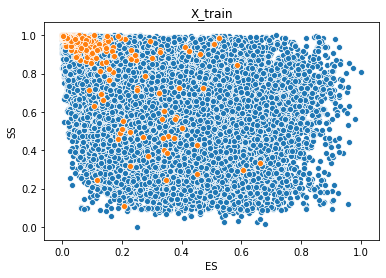

In [35]:
fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0))

ax = sns.scatterplot(x='ES', y='SS', data=dataset[dataset['y'] == 0])
ax = sns.scatterplot(x='ES', y='SS', data=dataset[dataset['y'] == 1])

plt.title('X_train')

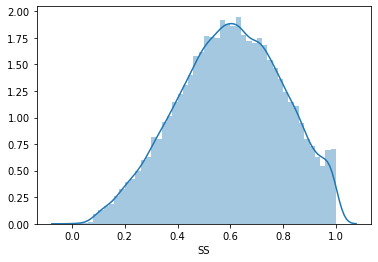

In [36]:
fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.distplot(dataset[dataset['y'] == 0]['SS'])

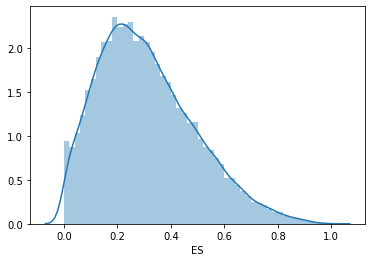

In [37]:
fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0))
sns.distplot(dataset[dataset['y'] == 0]['ES'])

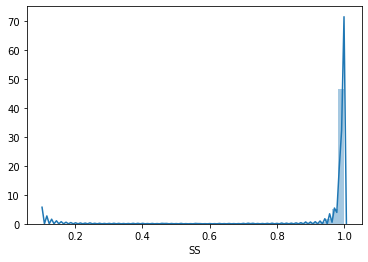

In [38]:
fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0))
sns.distplot(dataset[dataset['y'] == 1]['SS'])

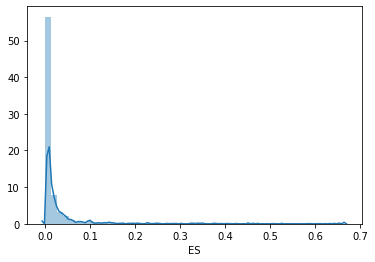

In [39]:
fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0))
sns.distplot(dataset[dataset['y'] == 1]['ES'])

## Logistic Regression

In [40]:
logreg = LogisticRegression(solver='liblinear')

logreg_fit = logreg.fit(X_train_minmax,y_train)
logreg.predict_proba(X_test_minmax)

array([[3.25970566e-01, 6.74029434e-01],
       [9.99979004e-01, 2.09956765e-05],
       [9.98311004e-01, 1.68899557e-03],
       ...,
       [9.99882539e-01, 1.17461074e-04],
       [9.99983667e-01, 1.63331986e-05],
       [9.23919187e-01, 7.60808129e-02]])

In [41]:
logreg.score(X_test_minmax, y_test)

0.9797190344281757

In [42]:
scores = model_selection.cross_val_score(logreg, X_train_minmax, y_train, cv=5, scoring='roc_auc')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.01)


In [43]:
print(logreg.coef_)
print(logreg.intercept_)
print(logreg.coef_[:,1]/logreg.coef_[:,0])

[[-13.78594078  14.64347448]]
[-13.79986756]
[-1.0622035]


intercept = -13.79986756 
coef1 = -13.78594078
coef2 = 14.64347448

In [44]:
print("Number of mislabeled points out of a total of %d points : %d (%f%%)" % (len(y_test),(y_test != logreg_fit.predict(X_test_minmax)).sum(),
                                                                              (y_test != logreg_fit.predict(X_test_minmax)).sum()/len(y_test)*100))




Number of mislabeled points out of a total of 10108 points : 205 (2.028097%)


0.9833640207310421


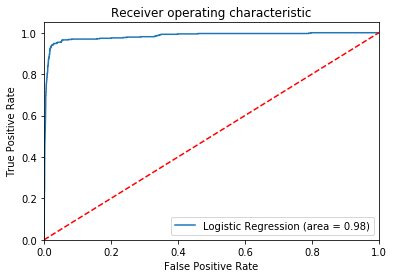

In [45]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_minmax)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_minmax)[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

In [46]:
sum(logreg.predict(X_test_minmax))

605

In [47]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Equation for the calculation of the surface similarity score term

In [48]:
intercept = -13.79986756 
coef1 = -13.78594078
coef2 = 14.64347448

def surf_score(ss, es):
    return 1/(1+np.exp(-(intercept + coef1 * es + coef2 * ss)))


# Single Amino Acid Recovery Benchmark

The recovery benchmark is performed on a dataset containing 100 complexes that is non-overlapping with the training data from the logistic regression.


## Generate data set

In [49]:
def random_pdbs(res_type):
    """
    Select 200 random PDB IDs that are not part of the weight optimization datatset.
    """
    # Make sure the selected PDBs were not part of the surface weight optimization dataset
    valid_pdbs = []
    for i in res_type:
        if i[2] not in weight_pdbs:
            valid_pdbs.append(i)
    
    random.Random(42).shuffle(res_type)
    pdbs = []
    chains1 = []
    chains2 = []
    residues = []
    for i in list(set(res_type))[:200]:
        mut_res = i[0]
        chains = i[2].split('_')[1:]
        mut_chain = mut_res[-1]
        for x in chains:
            if mut_chain in x:
                c1 = x
            else:
                c2 = x

        pdbs.append('"' + i[2] + '"')
        chains1.append('"' + ','.join(list(c1)) + '"')
        chains2.append('"' + ','.join(list(c2)) + '"' )
        residues.append('"' + i[0] + '"')
    return pdbs, chains1, chains2, residues

In [50]:
weight_set = rsb.io.parse_rosetta_file(['./data/surface_weight_optimization/' + i for i in os.listdir('./data/surface_weight_optimization/') if i.startswith('recover_') and i.endswith('.sc')], multi=True)

In [51]:
weight_pdbs = weight_set['description'].to_list()

In [52]:
aa_identity_counts = pd.read_json('./data/surface_weight_optimization/interface_residues.sc', lines=True)

In [53]:
aa_identity_counts = aa_identity_counts.replace(r'', np.nan)

In [54]:
count_res = []
count_counts = []

for c in aa_identity_counts.columns:
    if c.startswith('count_'):
        print(c, aa_identity_counts[c].sum())
        count_res.append(c)
        count_counts.append(aa_identity_counts[c].sum())

count_ala 3290
count_arg 3053
count_asn 3336
count_asp 3204
count_cys 958
count_gln 2366
count_glu 3219
count_gly 4565
count_his 1420
count_ile 2656
count_leu 4314
count_lys 2678
count_met 1117
count_phe 2156
count_pro 2544
count_ser 5111
count_thr 3550
count_trp 1214
count_tyr 3472
count_val 3053


In [55]:
alas = []
args = []
asns = []
asps = []
cyss = []
glns = []
glus = []
glys = []
hiss = []
iles = []
leus = []
lyss = []
mets = []
phes = []
pros = []
sers = []
thrs = []
trps = []
tyrs = []
vals = []

for index, row in aa_identity_counts.iterrows():
    for c in row.index:
        if c.startswith('count_') and row[c] > 0:
            for i in row[c.split('_')[1] + '_selection'].split(','):
                if ':' not in i:
                    res = c.split('_')[1]
                    if res == 'ala':
                        alas.append((i, res, row['decoy']))
                    elif res == 'arg':
                        args.append((i, res, row['decoy']))
                    elif res == 'asn':
                        asns.append((i, res, row['decoy']))
                    elif res == 'asp':
                        asps.append((i, res, row['decoy']))
                    elif res == 'cys':
                        cyss.append((i, res, row['decoy']))
                    elif res == 'gln':
                        glns.append((i, res, row['decoy']))
                    elif res == 'glu':
                        glus.append((i, res, row['decoy']))
                    elif res == 'gly':
                        glys.append((i, res, row['decoy']))
                    elif res == 'his':
                        hiss.append((i, res, row['decoy']))
                    elif res == 'ile':
                        iles.append((i, res, row['decoy']))
                    elif res == 'leu':
                        leus.append((i, res, row['decoy']))
                    elif res == 'lys':
                        lyss.append((i, res, row['decoy']))
                    elif res == 'met':
                        mets.append((i, res, row['decoy']))
                    elif res == 'phe':
                        phes.append((i, res, row['decoy']))
                    elif res == 'pro':
                        pros.append((i, res, row['decoy']))
                    elif res == 'ser':
                        sers.append((i, res, row['decoy']))
                    elif res == 'thr':
                        thrs.append((i, res, row['decoy']))
                    elif res == 'trp':
                        trps.append((i, res, row['decoy']))
                    elif res == 'tyr':
                        tyrs.append((i, res, row['decoy']))
                    elif res == 'val':
                        vals.append((i, res, row['decoy']))
            

In [56]:
all_aa_types = [alas,
                args,
                asns,
                asps,
                cyss,
                glns,
                glus,
                glys,
                hiss,
                iles,
                leus,
                lyss,
                mets,
                phes,
                pros,
                sers,
                thrs,
                trps,
                tyrs,
                vals]

aas = ['ala',
       'arg',
       'asn',
       'asp',
       'cys',
       'gln',
       'glu',
       'gly',
       'his',
       'ile',
       'leu',
       'lys',
       'met',
       'phe',
       'pro',
       'ser',
       'thr',
       'trp',
       'tyr',
       'val']

In [57]:
for aa_type in all_aa_types:
    random_pdbs(aa_type)

In [58]:
def create_submitter(res_type, flavor, pdbs, chains1, chains2, residues):
    working_dir = './{}/'.format(flavor)
    pdb_dir = '.'



    submitter = """#!/bin/bash
#SBATCH --nodes 1
#SBATCH --ntasks-per-node 1
#SBATCH --cpus-per-task 1
#SBATCH --mem 8192
#SBATCH --time 24:00:00
#SBATCH --partition serial
#SBATCH --output={outdir}{identity}.%A_%a.out
#SBATCH --error={errdir}{identity}.%A_%a.err

pdb_id=({pdbs})
chains1=({c1})
chains2=({c2})
mut_res=({res})

for i in {{0..{length}}}
do
    srun $ROSETTAPATH/source/bin/rosetta_scripts.default.linuxiccrelease -parser:protocol {xml} -ignore_unrecognized_res -out:file:score_only {scoredir}recover_{identity}.sc -s {indir}${{pdb_id[$i]}}.pdb -parser:script_vars c1=${{chains1[$i]}} c2=${{chains2[$i]}} r=${{mut_res[$i]}} -out:no_nstruct_label -mute core.scoring.sc.ShapeIdentityCalculator -in:file:native {indir}${{pdb_id[$i]}}.pdb
done
    """.format(outdir=working_dir + 'out/',
    errdir=working_dir + 'err/',
    xml=working_dir + 'recovery.xml',
    pdbs=" ".join(pdbs),
    c1=" ".join(chains1),
    c2=" ".join(chains2),
    res=" ".join(residues),
    length=len(pdbs),
    scoredir=working_dir,
    indir=pdb_dir,
    identity=res_type)
    
    with open('./submitter_recovery_{res}.slurm'.format(res=res_type), 'w') as outfile:
        outfile.write(submitter)

In [59]:
for i in range(len(all_aa_types)):
    pdbs, chains1, chains2, residues = random_pdbs(all_aa_types[i])
    create_submitter(aas[i], 'unbiased_unbound', pdbs, chains1, chains2, residues)

In [60]:
def calc_rec(rec_list, score, res, asc=False, ec_score=False):
    counter = 0
    print(len(rec_list))
    if ec_score:
        values = rec_list[[x for x in rec_list.columns if x.startswith(score[0]) and x.endswith(score[1])]].T
        for col in values:
            rec = values[col].sort_values(ascending=asc)
            if score[0]+'_'+res+'_'+score[1] in rec.index[:1]:
                if rec.tolist()[0] != rec.tolist()[1]:
                    counter += 1
    else:
        values = rec_list[[x for x in rec_list.columns if x.startswith(score)]].T
        for col in values:
            rec = values[col].sort_values(ascending=asc)
            if score+'_'+res in rec.index[:1]:
                if rec.tolist()[0] != rec.tolist()[1]:
                    counter += 1
    return counter
        
       

## Recovery in the unbound state

In [61]:
unbound_recover_ala = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_ala.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_arg = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_arg.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_asn = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_asn.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_asp = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_asp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_cys = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_cys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_gln = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_gln.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_glu = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_glu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_gly = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_gly.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_his = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_his.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_ile = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_ile.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_leu = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_leu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_lys = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_lys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_met = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_met.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_phe = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_phe.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_pro = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_pro.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_ser = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_ser.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_thr = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_thr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_trp = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_trp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_tyr = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_tyr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
unbound_recover_val = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/unbound/recover_val.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)



In [62]:
all_unbound_recover = [unbound_recover_ala, unbound_recover_arg, unbound_recover_asn, unbound_recover_asp, unbound_recover_gln,
            unbound_recover_glu, unbound_recover_gly, unbound_recover_his, unbound_recover_ile, unbound_recover_leu, unbound_recover_lys,
            unbound_recover_met, unbound_recover_phe, unbound_recover_pro, unbound_recover_ser, unbound_recover_thr, unbound_recover_trp,
            unbound_recover_tyr, unbound_recover_val]

for ar in all_unbound_recover:
    print(len(ar))

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


### Compute combined surface score

In [63]:
for ar in all_unbound_recover:
    ar['sses_ala'] = ar.apply(lambda row: surf_score(row['si_ala'], row['ec_ala_avg']), axis=1)
    ar['sses_arg'] = ar.apply(lambda row: surf_score(row['si_arg'], row['ec_arg_avg']), axis=1)
    ar['sses_asn'] = ar.apply(lambda row: surf_score(row['si_asn'], row['ec_asn_avg']), axis=1)
    ar['sses_asp'] = ar.apply(lambda row: surf_score(row['si_asp'], row['ec_asp_avg']), axis=1)
    ar['sses_gln'] = ar.apply(lambda row: surf_score(row['si_gln'], row['ec_gln_avg']), axis=1)
    ar['sses_glu'] = ar.apply(lambda row: surf_score(row['si_glu'], row['ec_glu_avg']), axis=1)
    ar['sses_gly'] = ar.apply(lambda row: surf_score(row['si_gly'], row['ec_gly_avg']), axis=1)
    ar['sses_his'] = ar.apply(lambda row: surf_score(row['si_his'], row['ec_his_avg']), axis=1)
    ar['sses_ile'] = ar.apply(lambda row: surf_score(row['si_ile'], row['ec_ile_avg']), axis=1)
    ar['sses_leu'] = ar.apply(lambda row: surf_score(row['si_leu'], row['ec_leu_avg']), axis=1)
    ar['sses_lys'] = ar.apply(lambda row: surf_score(row['si_lys'], row['ec_lys_avg']), axis=1)
    ar['sses_met'] = ar.apply(lambda row: surf_score(row['si_met'], row['ec_met_avg']), axis=1)
    ar['sses_phe'] = ar.apply(lambda row: surf_score(row['si_phe'], row['ec_phe_avg']), axis=1)
    ar['sses_pro'] = ar.apply(lambda row: surf_score(row['si_pro'], row['ec_pro_avg']), axis=1)
    ar['sses_ser'] = ar.apply(lambda row: surf_score(row['si_ser'], row['ec_ser_avg']), axis=1)
    ar['sses_thr'] = ar.apply(lambda row: surf_score(row['si_thr'], row['ec_thr_avg']), axis=1)
    ar['sses_trp'] = ar.apply(lambda row: surf_score(row['si_trp'], row['ec_trp_avg']), axis=1)
    ar['sses_tyr'] = ar.apply(lambda row: surf_score(row['si_tyr'], row['ec_tyr_avg']), axis=1)
    ar['sses_val'] = ar.apply(lambda row: surf_score(row['si_val'], row['ec_val_avg']), axis=1)

### Compute how often the correct amino acid was recovered with the different scoring functions

In [64]:
ala_si_unbound_rec = calc_rec(unbound_recover_ala.head(100), 'si', 'ala')
ala_sses_unbound_rec = calc_rec(unbound_recover_ala.head(100), 'sses', 'ala')
ala_es_unbound_rec = calc_rec(unbound_recover_ala.head(100), ['ec', 'avg'], 'ala', ec_score=True, asc=True)
ala_epr_unbound_rec = calc_rec(unbound_recover_ala.head(100), 'epr', 'ala', asc=True)

arg_si_unbound_rec = calc_rec(unbound_recover_arg.head(100), 'si', 'arg')
arg_sses_unbound_rec = calc_rec(unbound_recover_arg.head(100), 'sses', 'arg')
arg_es_unbound_rec = calc_rec(unbound_recover_arg.head(100), ['ec', 'avg'], 'arg', ec_score=True, asc=True)
arg_epr_unbound_rec = calc_rec(unbound_recover_arg.head(100), 'epr', 'arg', asc=True)

asn_si_unbound_rec = calc_rec(unbound_recover_asn.head(100), 'si', 'asn')
asn_sses_unbound_rec = calc_rec(unbound_recover_asn.head(100), 'sses', 'asn')
asn_es_unbound_rec = calc_rec(unbound_recover_asn.head(100), ['ec', 'avg'], 'asn', ec_score=True, asc=True)
asn_epr_unbound_rec = calc_rec(unbound_recover_asn.head(100), 'epr', 'asn', asc=True)

asp_si_unbound_rec = calc_rec(unbound_recover_asp.head(100), 'si', 'asp')
asp_sses_unbound_rec = calc_rec(unbound_recover_asp.head(100), 'sses', 'asp')
asp_es_unbound_rec = calc_rec(unbound_recover_asp.head(100), ['ec', 'avg'], 'asp', ec_score=True, asc=True)
asp_epr_unbound_rec = calc_rec(unbound_recover_asp.head(100), 'epr', 'asp', asc=True)

gln_si_unbound_rec = calc_rec(unbound_recover_gln.head(100), 'si', 'gln')
gln_sses_unbound_rec = calc_rec(unbound_recover_gln.head(100), 'sses', 'gln')
gln_es_unbound_rec = calc_rec(unbound_recover_gln.head(100), ['ec', 'avg'], 'gln', ec_score=True, asc=True)
gln_epr_unbound_rec = calc_rec(unbound_recover_gln.head(100), 'epr', 'gln', asc=True)

glu_si_unbound_rec = calc_rec(unbound_recover_glu.head(100), 'si', 'glu')
glu_sses_unbound_rec = calc_rec(unbound_recover_glu.head(100), 'sses', 'glu')
glu_es_unbound_rec = calc_rec(unbound_recover_glu.head(100), ['ec', 'avg'], 'glu', ec_score=True, asc=True)
glu_epr_unbound_rec = calc_rec(unbound_recover_glu.head(100), 'epr', 'glu', asc=True)

gly_si_unbound_rec = calc_rec(unbound_recover_gly.head(100), 'si', 'gly')
gly_sses_unbound_rec = calc_rec(unbound_recover_gly.head(100), 'sses', 'gly')
gly_es_unbound_rec = calc_rec(unbound_recover_gly.head(100), ['ec', 'avg'], 'gly', ec_score=True, asc=True)
gly_epr_unbound_rec = calc_rec(unbound_recover_gly.head(100), 'epr', 'gly', asc=True)

his_si_unbound_rec = calc_rec(unbound_recover_his.head(100), 'si', 'his')
his_sses_unbound_rec = calc_rec(unbound_recover_his.head(100), 'sses', 'his')
his_es_unbound_rec = calc_rec(unbound_recover_his.head(100), ['ec', 'avg'], 'his', ec_score=True, asc=True)
his_epr_unbound_rec = calc_rec(unbound_recover_his.head(100), 'epr', 'his', asc=True)

ile_si_unbound_rec = calc_rec(unbound_recover_ile.head(100), 'si', 'ile')
ile_sses_unbound_rec = calc_rec(unbound_recover_ile.head(100), 'sses', 'ile')
ile_es_unbound_rec = calc_rec(unbound_recover_ile.head(100), ['ec', 'avg'], 'ile', ec_score=True, asc=True)
ile_epr_unbound_rec = calc_rec(unbound_recover_ile.head(100), 'epr', 'ile', asc=True)

leu_si_unbound_rec = calc_rec(unbound_recover_leu.head(100), 'si', 'leu')
leu_sses_unbound_rec = calc_rec(unbound_recover_leu.head(100), 'sses', 'leu')
leu_es_unbound_rec = calc_rec(unbound_recover_leu.head(100), ['ec', 'avg'], 'leu', ec_score=True, asc=True)
leu_epr_unbound_rec = calc_rec(unbound_recover_leu.head(100), 'epr', 'leu', asc=True)

lys_si_unbound_rec = calc_rec(unbound_recover_lys.head(100), 'si', 'lys')
lys_sses_unbound_rec = calc_rec(unbound_recover_lys.head(100), 'sses', 'lys')
lys_es_unbound_rec = calc_rec(unbound_recover_lys.head(100), ['ec', 'avg'], 'lys', ec_score=True, asc=True)
lys_epr_unbound_rec = calc_rec(unbound_recover_lys.head(100), 'epr', 'lys', asc=True)

met_si_unbound_rec = calc_rec(unbound_recover_met.head(100), 'si', 'met')
met_sses_unbound_rec = calc_rec(unbound_recover_met.head(100), 'sses', 'met')
met_es_unbound_rec = calc_rec(unbound_recover_met.head(100), ['ec', 'avg'], 'met', ec_score=True, asc=True)
met_epr_unbound_rec = calc_rec(unbound_recover_met.head(100), 'epr', 'met', asc=True)

phe_si_unbound_rec = calc_rec(unbound_recover_phe.head(100), 'si', 'phe')
phe_sses_unbound_rec = calc_rec(unbound_recover_phe.head(100), 'sses', 'phe')
phe_es_unbound_rec = calc_rec(unbound_recover_phe.head(100), ['ec', 'avg'], 'phe', ec_score=True, asc=True)
phe_epr_unbound_rec = calc_rec(unbound_recover_phe.head(100), 'epr', 'phe', asc=True)

pro_si_unbound_rec = calc_rec(unbound_recover_pro.head(100), 'si', 'pro')
pro_sses_unbound_rec = calc_rec(unbound_recover_pro.head(100), 'sses', 'pro')
pro_es_unbound_rec = calc_rec(unbound_recover_pro.head(100), ['ec', 'avg'], 'pro', ec_score=True, asc=True)
pro_epr_unbound_rec = calc_rec(unbound_recover_pro.head(100), 'epr', 'pro', asc=True)

ser_si_unbound_rec = calc_rec(unbound_recover_ser.head(100), 'si', 'ser')
ser_sses_unbound_rec = calc_rec(unbound_recover_ser.head(100), 'sses', 'ser')
ser_es_unbound_rec = calc_rec(unbound_recover_ser.head(100), ['ec', 'avg'], 'ser', ec_score=True, asc=True)
ser_epr_unbound_rec = calc_rec(unbound_recover_ser.head(100), 'epr', 'ser', asc=True)

thr_si_unbound_rec = calc_rec(unbound_recover_thr.head(100), 'si', 'thr')
thr_sses_unbound_rec = calc_rec(unbound_recover_thr.head(100), 'sses', 'thr')
thr_es_unbound_rec = calc_rec(unbound_recover_thr.head(100), ['ec', 'avg'], 'thr', ec_score=True, asc=True)
thr_epr_unbound_rec = calc_rec(unbound_recover_thr.head(100), 'epr', 'thr', asc=True)

trp_si_unbound_rec = calc_rec(unbound_recover_trp.head(100), 'si', 'trp')
trp_sses_unbound_rec = calc_rec(unbound_recover_trp.head(100), 'sses', 'trp')
trp_es_unbound_rec = calc_rec(unbound_recover_trp.head(100), ['ec', 'avg'], 'trp', ec_score=True, asc=True)
trp_epr_unbound_rec = calc_rec(unbound_recover_trp.head(100), 'epr', 'trp', asc=True)

tyr_si_unbound_rec = calc_rec(unbound_recover_tyr.head(100), 'si', 'tyr')
tyr_sses_unbound_rec = calc_rec(unbound_recover_tyr.head(100), 'sses', 'tyr')
tyr_es_unbound_rec = calc_rec(unbound_recover_tyr.head(100), ['ec', 'avg'], 'tyr', ec_score=True, asc=True)
tyr_epr_unbound_rec = calc_rec(unbound_recover_tyr.head(100), 'epr', 'tyr', asc=True)

val_si_unbound_rec = calc_rec(unbound_recover_val.head(100), 'si', 'val')
val_sses_unbound_rec = calc_rec(unbound_recover_val.head(100), 'sses', 'val')
val_es_unbound_rec = calc_rec(unbound_recover_val.head(100), ['ec', 'avg'], 'val', ec_score=True, asc=True)
val_epr_unbound_rec = calc_rec(unbound_recover_val.head(100), 'epr', 'val', asc=True)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [65]:
all_single_unbound_recs_si = [ala_si_unbound_rec ,
arg_si_unbound_rec ,
asn_si_unbound_rec ,
asp_si_unbound_rec ,
gln_si_unbound_rec ,
glu_si_unbound_rec ,
gly_si_unbound_rec ,
his_si_unbound_rec ,
ile_si_unbound_rec ,
leu_si_unbound_rec ,
lys_si_unbound_rec ,
met_si_unbound_rec ,
phe_si_unbound_rec ,
pro_si_unbound_rec ,
ser_si_unbound_rec ,
thr_si_unbound_rec ,
trp_si_unbound_rec ,
tyr_si_unbound_rec ,
val_si_unbound_rec ]

all_single_unbound_recs_es = [ala_es_unbound_rec ,
arg_es_unbound_rec ,
asn_es_unbound_rec ,
asp_es_unbound_rec ,
gln_es_unbound_rec ,
glu_es_unbound_rec ,
gly_es_unbound_rec ,
his_es_unbound_rec ,
ile_es_unbound_rec ,
leu_es_unbound_rec ,
lys_es_unbound_rec ,
met_es_unbound_rec ,
phe_es_unbound_rec ,
pro_es_unbound_rec ,
ser_es_unbound_rec ,
thr_es_unbound_rec ,
trp_es_unbound_rec ,
tyr_es_unbound_rec ,
val_es_unbound_rec ]

all_single_unbound_recs_sses = [ala_sses_unbound_rec ,
arg_sses_unbound_rec ,
asn_sses_unbound_rec ,
asp_sses_unbound_rec ,
gln_sses_unbound_rec ,
glu_sses_unbound_rec ,
gly_sses_unbound_rec ,
his_sses_unbound_rec ,
ile_sses_unbound_rec ,
leu_sses_unbound_rec ,
lys_sses_unbound_rec ,
met_sses_unbound_rec ,
phe_sses_unbound_rec ,
pro_sses_unbound_rec ,
ser_sses_unbound_rec ,
thr_sses_unbound_rec ,
trp_sses_unbound_rec ,
tyr_sses_unbound_rec ,
val_sses_unbound_rec ]

all_single_unbound_recs_epr = [
ala_epr_unbound_rec ,
arg_epr_unbound_rec ,
asn_epr_unbound_rec ,
asp_epr_unbound_rec ,
gln_epr_unbound_rec ,
glu_epr_unbound_rec ,
gly_epr_unbound_rec ,
his_epr_unbound_rec ,
ile_epr_unbound_rec ,
leu_epr_unbound_rec ,
lys_epr_unbound_rec ,
met_epr_unbound_rec ,
phe_epr_unbound_rec ,
pro_epr_unbound_rec ,
ser_epr_unbound_rec ,
thr_epr_unbound_rec ,
trp_epr_unbound_rec ,
tyr_epr_unbound_rec ,
val_epr_unbound_rec ]

aas = ['Ala', 'Arg', 'Asn', 'Asp', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 
       'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']

In [66]:
all_single_unbound_recs = pd.DataFrame({'count': all_single_unbound_recs_si + all_single_unbound_recs_epr + all_single_unbound_recs_es + all_single_unbound_recs_sses, 
                                'aas': aas + aas + aas + aas, 
                                'variant': len(all_single_unbound_recs_si)*['si'] + len(all_single_unbound_recs_epr)*['epr'] + len(all_single_unbound_recs_es)*['es'] + len(all_single_unbound_recs_sses)*['sses']})


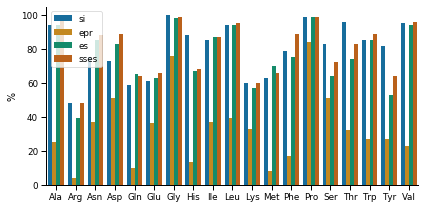

In [67]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax.grid(False)
sns.despine()

ax = sns.barplot(x='aas', y='count', hue='variant', data=all_single_unbound_recs, palette=sns.color_palette("colorblind"))
plt.xlabel("")
plt.ylabel("%")
plt.legend(title='')

plt.tight_layout(w_pad=0)

In [68]:
unbiased_unbound_single_rec_heatmap = pd.DataFrame(index=['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val'],
                      columns=['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val'])

In [69]:
aa_names =['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val']
for ar in range(len(all_unbound_recover)):
    tmp_list = []
    for c in sorted(all_unbound_recover[ar].columns):
        if c.startswith('sses_') and not c.startswith('sses_cys'):
            tmp_list.append(all_unbound_recover[ar][c].mean())
    unbiased_unbound_single_rec_heatmap[aa_names[ar]] = tmp_list

In [70]:
unbiased_unbound_single_rec_heatmap

,ala,arg,asn,asp,gln,glu,gly,his,ile,leu,lys,met,phe,pro,ser,thr,trp,tyr,val
ala,0.999999,0.528556,0.602211,0.706932,0.422414,0.421285,0.856380,0.427588,0.492538,0.481426,0.414463,0.604839,0.499143,0.782638,0.927084,0.728938,0.480952,0.411389,0.694147
arg,0.406440,0.609861,0.228179,0.057635,0.160931,0.068153,0.578505,0.163114,0.216826,0.267386,0.288533,0.232896,0.127504,0.159981,0.246939,0.244702,0.254749,0.157670,0.228119
asn,0.615445,0.349142,0.919620,0.756918,0.319475,0.212313,0.604603,0.513385,0.442734,0.678571,0.348660,0.372976,0.476620,0.363947,0.533463,0.531249,0.418722,0.338390,0.463091
asp,0.522334,0.086741,0.789088,0.909777,0.197609,0.302611,0.329788,0.531082,0.287691,0.640938,0.101284,0.389162,0.714092,0.213612,0.500554,0.454827,0.439263,0.369144,0.330854
gln,0.450220,0.304310,0.288333,0.267555,0.736348,0.642786,0.359478,0.274668,0.366016,0.391258,0.377095,0.628378,0.292750,0.197655,0.329590,0.404188,0.281232,0.183614,0.303593
glu,0.281579,0.077751,0.200761,0.320669,0.520587,0.756791,0.241177,0.354590,0.312445,0.405742,0.234024,0.704333,0.412120,0.106647,0.264519,0.302714,0.353983,0.198800,0.303632
gly,0.770031,0.537497,0.412861,0.228018,0.220007,0.073074,0.999999,0.340356,0.188478,0.217120,0.225687,0.246683,0.301341,0.370260,0.647813,0.422492,0.330363,0.328453,0.279883
his,0.397677,0.148812,0.323346,0.525702,0.246076,0.265012,0.522762,0.913580,0.319230,0.427840,0.227464,0.324390,0.948876,0.167989,0.303219,0.334421,0.622700,0.733511,0.319853
ile,0.488624,0.254131,0.382615,0.295999,0.258285,0.219039,0.345666,0.234994,0.949409,0.486105,0.280500,0.421737,0.283613,0.327808,0.571699,0.783359,0.202862,0.238560,0.842034
leu,0.458195,0.334245,0.596258,0.521998,0.300452,0.329035,0.480389,0.448187,0.486447,0.970246,0.314842,0.469929,0.549681,0.215021,0.398342,0.442669,0.380953,0.411954,0.434952


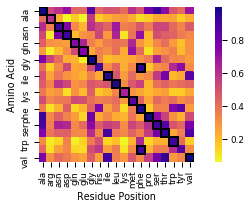

In [71]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6,3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.heatmap(unbiased_unbound_single_rec_heatmap ,annot=False, fmt=".3f", square=True, ax=ax, cmap="plasma_r", 
                 linewidths=0)

# highlight max value in each row
row_max = unbiased_unbound_single_rec_heatmap.idxmax(axis=1)
for row, index in enumerate(aa_names):
    position = unbiased_unbound_single_rec_heatmap.columns.get_loc(row_max[index])
    ax.add_patch(matplotlib.patches.Rectangle((position, row), 1, 1, fill=False, edgecolor='black', lw=2))

    
plt.xlabel("Residue Position")
plt.ylabel("Amino Acid")
plt.tight_layout()

## Recovery in the bound state

In [72]:
bound_recover_ala = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_ala.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_arg = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_arg.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_asn = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_asn.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_asp = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_asp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_cys = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_cys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_gln = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_gln.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_glu = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_glu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_gly = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_gly.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_his = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_his.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_ile = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_ile.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_leu = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_leu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_lys = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_lys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_met = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_met.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_phe = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_phe.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_pro = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_pro.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_ser = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_ser.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_thr = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_thr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_trp = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_trp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_tyr = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_tyr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_val = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_val.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)




In [73]:
all_bound_recover = [bound_recover_ala, bound_recover_arg, bound_recover_asn, bound_recover_asp, bound_recover_gln,
            bound_recover_glu, bound_recover_gly, bound_recover_his, bound_recover_ile, bound_recover_leu, bound_recover_lys,
            bound_recover_met, bound_recover_phe, bound_recover_pro, bound_recover_ser, bound_recover_thr, bound_recover_trp,
            bound_recover_tyr, bound_recover_val]


for ar in all_bound_recover:
    print(len(ar))

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


### Compute combined surface score

In [74]:
for ar in all_bound_recover:
    ar['sses_ala'] = ar.apply(lambda row: surf_score(row['si_ala'], row['ec_ala_avg']), axis=1)
    ar['sses_arg'] = ar.apply(lambda row: surf_score(row['si_arg'], row['ec_arg_avg']), axis=1)
    ar['sses_asn'] = ar.apply(lambda row: surf_score(row['si_asn'], row['ec_asn_avg']), axis=1)
    ar['sses_asp'] = ar.apply(lambda row: surf_score(row['si_asp'], row['ec_asp_avg']), axis=1)
    ar['sses_gln'] = ar.apply(lambda row: surf_score(row['si_gln'], row['ec_gln_avg']), axis=1)
    ar['sses_glu'] = ar.apply(lambda row: surf_score(row['si_glu'], row['ec_glu_avg']), axis=1)
    ar['sses_gly'] = ar.apply(lambda row: surf_score(row['si_gly'], row['ec_gly_avg']), axis=1)
    ar['sses_his'] = ar.apply(lambda row: surf_score(row['si_his'], row['ec_his_avg']), axis=1)
    ar['sses_ile'] = ar.apply(lambda row: surf_score(row['si_ile'], row['ec_ile_avg']), axis=1)
    ar['sses_leu'] = ar.apply(lambda row: surf_score(row['si_leu'], row['ec_leu_avg']), axis=1)
    ar['sses_lys'] = ar.apply(lambda row: surf_score(row['si_lys'], row['ec_lys_avg']), axis=1)
    ar['sses_met'] = ar.apply(lambda row: surf_score(row['si_met'], row['ec_met_avg']), axis=1)
    ar['sses_phe'] = ar.apply(lambda row: surf_score(row['si_phe'], row['ec_phe_avg']), axis=1)
    ar['sses_pro'] = ar.apply(lambda row: surf_score(row['si_pro'], row['ec_pro_avg']), axis=1)
    ar['sses_ser'] = ar.apply(lambda row: surf_score(row['si_ser'], row['ec_ser_avg']), axis=1)
    ar['sses_thr'] = ar.apply(lambda row: surf_score(row['si_thr'], row['ec_thr_avg']), axis=1)
    ar['sses_trp'] = ar.apply(lambda row: surf_score(row['si_trp'], row['ec_trp_avg']), axis=1)
    ar['sses_tyr'] = ar.apply(lambda row: surf_score(row['si_tyr'], row['ec_tyr_avg']), axis=1)
    ar['sses_val'] = ar.apply(lambda row: surf_score(row['si_val'], row['ec_val_avg']), axis=1)

### Compute how often the correct amino acid was recovered with the different scoring functions

In [75]:
ala_si_bound_rec = calc_rec(bound_recover_ala.head(100), 'si', 'ala')
ala_sses_bound_rec = calc_rec(bound_recover_ala.head(100), 'sses', 'ala')
ala_es_bound_rec = calc_rec(bound_recover_ala.head(100), ['ec', 'avg'], 'ala', ec_score=True, asc=True)
ala_epr_bound_rec = calc_rec(bound_recover_ala.head(100), 'epr', 'ala', asc=True)

arg_si_bound_rec = calc_rec(bound_recover_arg.head(100), 'si', 'arg')
arg_sses_bound_rec = calc_rec(bound_recover_arg.head(100), 'sses', 'arg')
arg_es_bound_rec = calc_rec(bound_recover_arg.head(100), ['ec', 'avg'], 'arg', ec_score=True, asc=True)
arg_epr_bound_rec = calc_rec(bound_recover_arg.head(100), 'epr', 'arg', asc=True)

asn_si_bound_rec = calc_rec(bound_recover_asn.head(100), 'si', 'asn')
asn_sses_bound_rec = calc_rec(bound_recover_asn.head(100), 'sses', 'asn')
asn_es_bound_rec = calc_rec(bound_recover_asn.head(100), ['ec', 'avg'], 'asn', ec_score=True, asc=True)
asn_epr_bound_rec = calc_rec(bound_recover_asn.head(100), 'epr', 'asn', asc=True)

asp_si_bound_rec = calc_rec(bound_recover_asp.head(100), 'si', 'asp')
asp_sses_bound_rec = calc_rec(bound_recover_asp.head(100), 'sses', 'asp')
asp_es_bound_rec = calc_rec(bound_recover_asp.head(100), ['ec', 'avg'], 'asp', ec_score=True, asc=True)
asp_epr_bound_rec = calc_rec(bound_recover_asp.head(100), 'epr', 'asp', asc=True)

gln_si_bound_rec = calc_rec(bound_recover_gln.head(100), 'si', 'gln')
gln_sses_bound_rec = calc_rec(bound_recover_gln.head(100), 'sses', 'gln')
gln_es_bound_rec = calc_rec(bound_recover_gln.head(100), ['ec', 'avg'], 'gln', ec_score=True, asc=True)
gln_epr_bound_rec = calc_rec(bound_recover_gln.head(100), 'epr', 'gln', asc=True)

glu_si_bound_rec = calc_rec(bound_recover_glu.head(100), 'si', 'glu')
glu_sses_bound_rec = calc_rec(bound_recover_glu.head(100), 'sses', 'glu')
glu_es_bound_rec = calc_rec(bound_recover_glu.head(100), ['ec', 'avg'], 'glu', ec_score=True, asc=True)
glu_epr_bound_rec = calc_rec(bound_recover_glu.head(100), 'epr', 'glu', asc=True)

gly_si_bound_rec = calc_rec(bound_recover_gly.head(100), 'si', 'gly')
gly_sses_bound_rec = calc_rec(bound_recover_gly.head(100), 'sses', 'gly')
gly_es_bound_rec = calc_rec(bound_recover_gly.head(100), ['ec', 'avg'], 'gly', ec_score=True, asc=True)
gly_epr_bound_rec = calc_rec(bound_recover_gly.head(100), 'epr', 'gly', asc=True)

his_si_bound_rec = calc_rec(bound_recover_his.head(100), 'si', 'his')
his_sses_bound_rec = calc_rec(bound_recover_his.head(100), 'sses', 'his')
his_es_bound_rec = calc_rec(bound_recover_his.head(100), ['ec', 'avg'], 'his', ec_score=True, asc=True)
his_epr_bound_rec = calc_rec(bound_recover_his.head(100), 'epr', 'his', asc=True)

ile_si_bound_rec = calc_rec(bound_recover_ile.head(100), 'si', 'ile')
ile_sses_bound_rec = calc_rec(bound_recover_ile.head(100), 'sses', 'ile')
ile_es_bound_rec = calc_rec(bound_recover_ile.head(100), ['ec', 'avg'], 'ile', ec_score=True, asc=True)
ile_epr_bound_rec = calc_rec(bound_recover_ile.head(100), 'epr', 'ile', asc=True)

leu_si_bound_rec = calc_rec(bound_recover_leu.head(100), 'si', 'leu')
leu_sses_bound_rec = calc_rec(bound_recover_leu.head(100), 'sses', 'leu')
leu_es_bound_rec = calc_rec(bound_recover_leu.head(100), ['ec', 'avg'], 'leu', ec_score=True, asc=True)
leu_epr_bound_rec = calc_rec(bound_recover_leu.head(100), 'epr', 'leu', asc=True)

lys_si_bound_rec = calc_rec(bound_recover_lys.head(100), 'si', 'lys')
lys_sses_bound_rec = calc_rec(bound_recover_lys.head(100), 'sses', 'lys')
lys_es_bound_rec = calc_rec(bound_recover_lys.head(100), ['ec', 'avg'], 'lys', ec_score=True, asc=True)
lys_epr_bound_rec = calc_rec(bound_recover_lys.head(100), 'epr', 'lys', asc=True)

met_si_bound_rec = calc_rec(bound_recover_met.head(100), 'si', 'met')
met_sses_bound_rec = calc_rec(bound_recover_met.head(100), 'sses', 'met')
met_es_bound_rec = calc_rec(bound_recover_met.head(100), ['ec', 'avg'], 'met', ec_score=True, asc=True)
met_epr_bound_rec = calc_rec(bound_recover_met.head(100), 'epr', 'met', asc=True)

phe_si_bound_rec = calc_rec(bound_recover_phe.head(100), 'si', 'phe')
phe_sses_bound_rec = calc_rec(bound_recover_phe.head(100), 'sses', 'phe')
phe_es_bound_rec = calc_rec(bound_recover_phe.head(100), ['ec', 'avg'], 'phe', ec_score=True, asc=True)
phe_epr_bound_rec = calc_rec(bound_recover_phe.head(100), 'epr', 'phe', asc=True)

pro_si_bound_rec = calc_rec(bound_recover_pro.head(100), 'si', 'pro')
pro_sses_bound_rec = calc_rec(bound_recover_pro.head(100), 'sses', 'pro')
pro_es_bound_rec = calc_rec(bound_recover_pro.head(100), ['ec', 'avg'], 'pro', ec_score=True, asc=True)
pro_epr_bound_rec = calc_rec(bound_recover_pro.head(100), 'epr', 'pro', asc=True)

ser_si_bound_rec = calc_rec(bound_recover_ser.head(100), 'si', 'ser')
ser_sses_bound_rec = calc_rec(bound_recover_ser.head(100), 'sses', 'ser')
ser_es_bound_rec = calc_rec(bound_recover_ser.head(100), ['ec', 'avg'], 'ser', ec_score=True, asc=True)
ser_epr_bound_rec = calc_rec(bound_recover_ser.head(100), 'epr', 'ser', asc=True)

thr_si_bound_rec = calc_rec(bound_recover_thr.head(100), 'si', 'thr')
thr_sses_bound_rec = calc_rec(bound_recover_thr.head(100), 'sses', 'thr')
thr_es_bound_rec = calc_rec(bound_recover_thr.head(100), ['ec', 'avg'], 'thr', ec_score=True, asc=True)
thr_epr_bound_rec = calc_rec(bound_recover_thr.head(100), 'epr', 'thr', asc=True)

trp_si_bound_rec = calc_rec(bound_recover_trp.head(100), 'si', 'trp')
trp_sses_bound_rec = calc_rec(bound_recover_trp.head(100), 'sses', 'trp')
trp_es_bound_rec = calc_rec(bound_recover_trp.head(100), ['ec', 'avg'], 'trp', ec_score=True, asc=True)
trp_epr_bound_rec = calc_rec(bound_recover_trp.head(100), 'epr', 'trp', asc=True)

tyr_si_bound_rec = calc_rec(bound_recover_tyr.head(100), 'si', 'tyr')
tyr_sses_bound_rec = calc_rec(bound_recover_tyr.head(100), 'sses', 'tyr')
tyr_es_bound_rec = calc_rec(bound_recover_tyr.head(100), ['ec', 'avg'], 'tyr', ec_score=True, asc=True)
tyr_epr_bound_rec = calc_rec(bound_recover_tyr.head(100), 'epr', 'tyr', asc=True)

val_si_bound_rec = calc_rec(bound_recover_val.head(100), 'si', 'val')
val_sses_bound_rec = calc_rec(bound_recover_val.head(100), 'sses', 'val')
val_es_bound_rec = calc_rec(bound_recover_val.head(100), ['ec', 'avg'], 'val', ec_score=True, asc=True)
val_epr_bound_rec = calc_rec(bound_recover_val.head(100), 'epr', 'val', asc=True)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [76]:
all_single_bound_recs_si = [ala_si_bound_rec ,
arg_si_bound_rec ,
asn_si_bound_rec ,
asp_si_bound_rec ,
gln_si_bound_rec ,
glu_si_bound_rec ,
gly_si_bound_rec ,
his_si_bound_rec ,
ile_si_bound_rec ,
leu_si_bound_rec ,
lys_si_bound_rec ,
met_si_bound_rec ,
phe_si_bound_rec ,
pro_si_bound_rec ,
ser_si_bound_rec ,
thr_si_bound_rec ,
trp_si_bound_rec ,
tyr_si_bound_rec ,
val_si_bound_rec ]

all_single_bound_recs_es = [ala_es_bound_rec ,
arg_es_bound_rec ,
asn_es_bound_rec ,
asp_es_bound_rec ,
gln_es_bound_rec ,
glu_es_bound_rec ,
gly_es_bound_rec ,
his_es_bound_rec ,
ile_es_bound_rec ,
leu_es_bound_rec ,
lys_es_bound_rec ,
met_es_bound_rec ,
phe_es_bound_rec ,
pro_es_bound_rec ,
ser_es_bound_rec ,
thr_es_bound_rec ,
trp_es_bound_rec ,
tyr_es_bound_rec ,
val_es_bound_rec ]

all_single_bound_recs_sses = [ala_sses_bound_rec ,
arg_sses_bound_rec ,
asn_sses_bound_rec ,
asp_sses_bound_rec ,
gln_sses_bound_rec ,
glu_sses_bound_rec ,
gly_sses_bound_rec ,
his_sses_bound_rec ,
ile_sses_bound_rec ,
leu_sses_bound_rec ,
lys_sses_bound_rec ,
met_sses_bound_rec ,
phe_sses_bound_rec ,
pro_sses_bound_rec ,
ser_sses_bound_rec ,
thr_sses_bound_rec ,
trp_sses_bound_rec ,
tyr_sses_bound_rec ,
val_sses_bound_rec ]

all_single_bound_recs_epr = [
ala_epr_bound_rec ,
arg_epr_bound_rec ,
asn_epr_bound_rec ,
asp_epr_bound_rec ,
gln_epr_bound_rec ,
glu_epr_bound_rec ,
gly_epr_bound_rec ,
his_epr_bound_rec ,
ile_epr_bound_rec ,
leu_epr_bound_rec ,
lys_epr_bound_rec ,
met_epr_bound_rec ,
phe_epr_bound_rec ,
pro_epr_bound_rec ,
ser_epr_bound_rec ,
thr_epr_bound_rec ,
trp_epr_bound_rec ,
tyr_epr_bound_rec ,
val_epr_bound_rec ]

aas = ['Ala', 'Arg', 'Asn', 'Asp', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 
       'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']

In [77]:
all_single_bound_recs = pd.DataFrame({'count': all_single_bound_recs_si + all_single_bound_recs_epr + all_single_bound_recs_es + all_single_bound_recs_sses, 
                                'aas': aas + aas + aas + aas, 
                                'variant': len(all_single_bound_recs_si)*['si'] + len(all_single_bound_recs_epr)*['epr'] + len(all_single_bound_recs_es)*['es'] + len(all_single_bound_recs_sses)*['sses']})


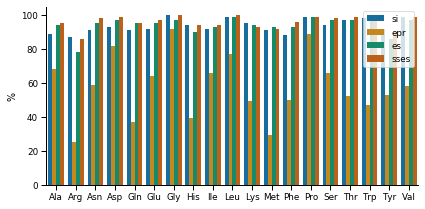

In [78]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax.grid(False)
sns.despine()

ax = sns.barplot(x='aas', y='count', hue='variant', data=all_single_bound_recs, palette=sns.color_palette("colorblind"))
plt.xlabel("")
plt.ylabel("%")
plt.legend(title='')

plt.tight_layout(w_pad=0)

In [79]:
unbiased_bound_single_rec_heatmap = pd.DataFrame(index=['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val'],
                      columns=['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val'])

In [80]:
aa_names =['ala', 'arg', 'asn', 'asp', 'gln', 'glu', 'gly', 'his', 'ile', 'leu',
                               'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val']
for ar in range(len(all_bound_recover)):
    tmp_list = []
    for c in sorted(all_bound_recover[ar].columns):
        if c.startswith('sses_') and not c.startswith('sses_cys'):
            tmp_list.append(all_bound_recover[ar][c].mean())
    unbiased_bound_single_rec_heatmap[aa_names[ar]] = tmp_list

In [81]:
unbiased_bound_single_rec_heatmap

,ala,arg,asn,asp,gln,glu,gly,his,ile,leu,lys,met,phe,pro,ser,thr,trp,tyr,val
ala,0.999988,0.483197,0.616006,0.710516,0.415097,0.411984,0.862591,0.443741,0.518273,0.485906,0.446780,0.595849,0.552850,0.778993,0.938760,0.731367,0.481496,0.376941,0.697631
arg,0.451329,0.903694,0.312062,0.072564,0.227148,0.082670,0.655908,0.220532,0.291785,0.341197,0.333557,0.345876,0.314174,0.178212,0.336787,0.295001,0.419765,0.364941,0.309464
asn,0.728402,0.399067,0.982558,0.812282,0.385656,0.332463,0.682302,0.622438,0.531412,0.810506,0.393070,0.428114,0.711529,0.401918,0.701548,0.550866,0.510645,0.473567,0.437478
asp,0.726627,0.104623,0.880943,0.990018,0.265050,0.354787,0.444591,0.723850,0.338362,0.763557,0.122512,0.436931,0.890498,0.331119,0.732178,0.492143,0.618927,0.517303,0.324472
gln,0.600031,0.343392,0.352487,0.285920,0.971933,0.786440,0.434214,0.363690,0.436050,0.426193,0.458780,0.805217,0.388164,0.229827,0.418318,0.472092,0.351379,0.222570,0.387703
glu,0.508385,0.093751,0.291789,0.354479,0.750408,0.998698,0.304569,0.433353,0.389841,0.389623,0.248515,0.780761,0.530673,0.284560,0.384163,0.403301,0.448820,0.239906,0.302091
gly,0.743480,0.486188,0.416252,0.239729,0.202711,0.070287,0.999999,0.353543,0.192102,0.197470,0.238675,0.279067,0.333132,0.369533,0.619096,0.436832,0.318194,0.296484,0.280971
his,0.547315,0.178174,0.463720,0.546290,0.297401,0.340378,0.594075,0.976329,0.348678,0.591903,0.303089,0.414636,0.991624,0.242199,0.480388,0.382825,0.763518,0.809810,0.335124
ile,0.566977,0.335994,0.423336,0.316698,0.271590,0.308357,0.426305,0.254146,0.999996,0.542387,0.305669,0.548308,0.378825,0.355638,0.632672,0.799554,0.311802,0.281576,0.897463
leu,0.598635,0.381154,0.598172,0.519175,0.348512,0.455323,0.520567,0.487308,0.569279,0.999999,0.363009,0.546123,0.659987,0.267156,0.542631,0.488278,0.414934,0.436891,0.502320


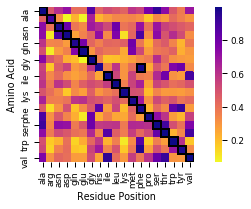

In [82]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.heatmap(unbiased_bound_single_rec_heatmap ,annot=False, fmt=".3f", square=True, ax=ax, cmap="plasma_r", 
                 linewidths=0)

row_max = unbiased_bound_single_rec_heatmap.idxmax(axis=1)
for row, index in enumerate(aa_names):
    position = unbiased_bound_single_rec_heatmap.columns.get_loc(row_max[index])
    ax.add_patch(matplotlib.patches.Rectangle((position, row),1,1, fill=False, edgecolor='black', lw=2))

plt.xlabel("Residue Position")
plt.ylabel("Amino Acid")
plt.tight_layout()

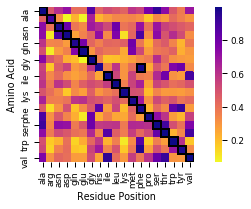

In [83]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.heatmap(unbiased_bound_single_rec_heatmap ,annot=False, fmt=".3f", square=True, ax=ax, cmap="plasma_r", 
                 linewidths=0)

row_max = unbiased_bound_single_rec_heatmap.idxmax(axis=1)
for row, index in enumerate(aa_names):
    position = unbiased_bound_single_rec_heatmap.columns.get_loc(row_max[index])
    ax.add_patch(matplotlib.patches.Rectangle((position, row),1,1, fill=False, edgecolor='black', lw=2))

plt.xlabel("Residue Position")
plt.ylabel("Amino Acid")
plt.tight_layout()

# Protein Interface Sequence Recovery Benchmark

## Analyze SSM sampling

For RosettaSurf-site we sample each amino acid individually for every mutatable position. The following picks the best 3 scoring mutations which will be included in the resfile that is used during the full sequence recovery design stage.

In [84]:
aas = ['ala', 'arg', 'asn', 'asp', 'cys', 'gln', 'glu', 'gly', 'his', 'ile', 'leu', 'lys', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val']

In [85]:
aa_dict = {'ala': 'A', 'arg': 'R', 'asn': 'N', 'asp': 'D', 'cys': 'C', 'gln': 'Q', 'glu': 'E', 'gly': 'G', 'his': 'H', 'ile': 'I', 
           'leu': 'L', 'lys': 'K', 'met': 'M', 'phe': 'F', 'pro': 'P', 'ser': 'S', 'thr': 'T', 'trp': 'W', 'tyr': 'Y', 'val': 'V'}

In [86]:
def create_ssm_resfile(ssm, pdb, residues):
    resfile = "NATRO\nEX 1 EX 2\nstart\n\n"

    for r in residues:
        si_scores = ssm['{}_{}'.format(pdb, r)].sort_values(ascending=False)
    
        # Check if the top 3 scoring residues are unique and if so add them to the resfile
        if len(set(si_scores.head(3))) == 3:
            aas = [aa_dict[aa.split('_')[-1]] for aa in si_scores.head(3).index]
            # print residue positions, top 3 mutations, and sses score of the lowest scoring mutation
            print(r, aas, si_scores.iloc[2])
            resfile += r.strip('X') + " " + r[-1] + " PIKAA " + "".join(aas) + '\n'
       # This means the top 3 values are not unique 
        else:
            print(r, " is not unique!!")        
    print(resfile)

In [87]:
sample_bound_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_1dfj.sc')
sample_bound_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_1emv.sc')
sample_bound_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_1ppe.sc')
sample_bound_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_1rv6.sc')
sample_bound_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_3idx.sc')
sample_bound_3mc0 = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_3mc0.sc')
sample_bound_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_4jlr.sc')
sample_bound_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_5jds.sc')
sample_bound_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/bound/recover_6b9j.sc')

In [88]:
sample_unbound_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_1dfj.sc')
sample_unbound_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_1emv.sc')
sample_unbound_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_1ppe.sc')
sample_unbound_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_1rv6.sc')
sample_unbound_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_3idx.sc')
sample_unbound_3mc0 = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_3mc0.sc')
sample_unbound_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_4jlr.sc')
sample_unbound_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_5jds.sc')
sample_unbound_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/ssm_sampling/unbound/recover_6b9j.sc')

In [89]:
all_sample_bounds = [sample_bound_1dfj,
               sample_bound_1emv,
               sample_bound_1ppe,
               sample_bound_1rv6,
               sample_bound_3idx,
               sample_bound_3mc0,
               sample_bound_4jlr,
               sample_bound_5jds,
               sample_bound_6b9j]

In [90]:
all_sample_unbounds = [sample_unbound_1dfj,
               sample_unbound_1emv,
               sample_unbound_1ppe,
               sample_unbound_1rv6,
               sample_unbound_3idx,
               sample_unbound_3mc0,
               sample_unbound_4jlr,
               sample_unbound_5jds,
               sample_unbound_6b9j]

In [91]:
for sample_bound in all_sample_bounds:
    for aa in aas:
        sample_bound['sses_{}'.format(aa)] = sample_bound.apply(lambda row: surf_score(row['si_{}'.format(aa)], row['ec_{}_avg'.format(aa)]), axis=1)
    sample_bound.set_index('description', inplace=True)

In [92]:
for sample_unbound in all_sample_unbounds:
    for aa in aas:
        sample_unbound['sses_{}'.format(aa)] = sample_unbound.apply(lambda row: surf_score(row['si_{}'.format(aa)], row['ec_{}_avg'.format(aa)]), axis=1)
    sample_unbound.set_index('description', inplace=True)

In [93]:
sses_bound_1dfj = sample_bound_1dfj[[c for c in sample_bound_1dfj.columns if c.startswith('sses_')]]
sses_bound_1emv = sample_bound_1emv[[c for c in sample_bound_1emv.columns if c.startswith('sses_')]]
sses_bound_1ppe = sample_bound_1ppe[[c for c in sample_bound_1ppe.columns if c.startswith('sses_')]]
sses_bound_1rv6 = sample_bound_1rv6[[c for c in sample_bound_1rv6.columns if c.startswith('sses_')]]
sses_bound_3idx = sample_bound_3idx[[c for c in sample_bound_3idx.columns if c.startswith('sses_')]]
sses_bound_3mc0 = sample_bound_3mc0[[c for c in sample_bound_3mc0.columns if c.startswith('sses_')]]
sses_bound_4jlr = sample_bound_4jlr[[c for c in sample_bound_4jlr.columns if c.startswith('sses_')]]
sses_bound_5jds = sample_bound_5jds[[c for c in sample_bound_5jds.columns if c.startswith('sses_')]]
sses_bound_6b9j = sample_bound_6b9j[[c for c in sample_bound_6b9j.columns if c.startswith('sses_')]]

In [94]:
sses_unbound_1dfj = sample_unbound_1dfj[[c for c in sample_unbound_1dfj.columns if c.startswith('sses_')]]
sses_unbound_1emv = sample_unbound_1emv[[c for c in sample_unbound_1emv.columns if c.startswith('sses_')]]
sses_unbound_1ppe = sample_unbound_1ppe[[c for c in sample_unbound_1ppe.columns if c.startswith('sses_')]]
sses_unbound_1rv6 = sample_unbound_1rv6[[c for c in sample_unbound_1rv6.columns if c.startswith('sses_')]]
sses_unbound_3idx = sample_unbound_3idx[[c for c in sample_unbound_3idx.columns if c.startswith('sses_')]]
sses_unbound_3mc0 = sample_unbound_3mc0[[c for c in sample_unbound_3mc0.columns if c.startswith('sses_')]]
sses_unbound_4jlr = sample_unbound_4jlr[[c for c in sample_unbound_4jlr.columns if c.startswith('sses_')]]
sses_unbound_5jds = sample_unbound_5jds[[c for c in sample_unbound_5jds.columns if c.startswith('sses_')]]
sses_unbound_6b9j = sample_unbound_6b9j[[c for c in sample_unbound_6b9j.columns if c.startswith('sses_')]]

In [95]:
all_sses_bound = [sses_bound_1dfj,
            sses_bound_1emv,
            sses_bound_1ppe,
            sses_bound_1rv6,
            sses_bound_3idx,
            sses_bound_3mc0,
            sses_bound_4jlr,
            sses_bound_5jds,
            sses_bound_6b9j]

In [96]:
all_sses_unbound = [sses_unbound_1dfj,
            sses_unbound_1emv,
            sses_unbound_1ppe,
            sses_unbound_1rv6,
            sses_unbound_3idx,
            sses_unbound_3mc0,
            sses_unbound_4jlr,
            sses_unbound_5jds,
            sses_unbound_6b9j]

### 1dfj

In [97]:
create_ssm_resfile(sses_bound_1dfj.T.drop('sses_cys'), '1dfj_0001', ["4X", "7X", "11X", "12X", "23X", "24X", "27X", "28X", "31X", "32X", "37X", "38X", "39X", "41X", "42X", "43X", "66X", "67X", "68X", "69X", "71X", "86X", "87X", "88X", "89X", "91X", "109X", "111X", "118X", "119X"])

4X ['A', 'S', 'E'] 0.9991529693214428
7X ['Q', 'E', 'R'] 0.230218928124434
11X ['Q', 'K', 'M'] 0.7165131522439125
12X ['H', 'N', 'W'] 0.27672025226017866
23X ['S', 'T', 'A'] 0.9928125022833231
24X ['N', 'D', 'M'] 0.9560636808270367
27X ['N', 'D', 'S'] 0.9793962534102374
28X ['Q', 'R', 'A'] 0.0033127837026984356
31X ['K', 'R', 'A'] 0.7766105912427202
32X ['S', 'H', 'A'] 0.9999975307190847
37X ['M', 'L', 'N'] 0.9655670760024488
38X ['D', 'N', 'F'] 0.9888633489933765
39X ['R', 'L', 'A'] 0.08591337089413606
41X ['K', 'R', 'T'] 0.8841179285155634
42X ['P', 'S', 'T'] 0.9918807725358407
43X ['T', 'V', 'I'] 0.02215066341841155
66X ['K', 'A', 'P'] 0.8621520547232417
67X ['N', 'S', 'A'] 0.9989922152113235
68X ['G', 'P', 'S'] 0.9976172985444609
69X ['M', 'T', 'I'] 0.49129771455086374
71X ['N', 'S', 'A'] 0.9611410503301133
86X ['E', 'H', 'F'] 0.3771575284213014
87X ['T', 'V', 'A'] 0.999990119473776
88X ['G', 'A', 'S'] 0.998872608652057
89X ['S', 'A', 'P'] 0.9999706825707197
91X ['K', 'N', 'L'] 0.0

In [98]:
create_ssm_resfile(sses_unbound_1dfj.T.drop('sses_cys'), '1dfj_0001', ["4X", "7X", "11X", "12X", "23X", "24X", "27X", "28X", "31X", "32X", "37X", "38X", "39X", "41X", "42X", "43X", "66X", "67X", "68X", "69X", "71X", "86X", "87X", "88X", "89X", "91X", "109X", "111X", "118X", "119X"])

4X ['A', 'S', 'I'] 0.9901686529796316
7X ['K', 'Q', 'M'] 0.770266615835482
11X ['Q', 'M', 'L'] 0.04658163142051375
12X ['H', 'N', 'F'] 0.5230074951123759
23X ['S', 'T', 'A'] 0.9979676037319368
24X ['N', 'D', 'L'] 0.9737305468652353
27X ['N', 'D', 'S'] 0.966150113488456
28X ['E', 'K', 'Q'] 0.025217952189508393
31X ['K', 'M', 'R'] 0.7036848771865221
32X ['A', 'T', 'P'] 0.999970755981149
37X ['M', 'L', 'N'] 0.9601534398795981
38X ['N', 'D', 'H'] 0.9974537434582755
39X ['N', 'R', 'T'] 0.0036893595080111042
41X ['R', 'T', 'Q'] 0.2224682336291137
42X ['P', 'A', 'V'] 0.13671036448647322
43X ['V', 'T', 'I'] 0.23625817957134915
66X ['S', 'Q', 'A'] 0.9678792282775919
67X ['N', 'A', 'D'] 0.9997459830063936
68X ['G', 'P', 'S'] 0.9977136112105542
69X ['E', 'M', 'I'] 0.8209796228321802
71X ['N', 'S', 'A'] 0.9923281468645042
86X ['E', 'Q', 'M'] 0.9959870168262337
87X ['T', 'V', 'A'] 0.9999889674262596
88X ['G', 'A', 'N'] 0.9973550385213872
89X ['A', 'S', 'P'] 0.9997104961471103
91X ['K', 'E', 'T'] 0.

### 1emv

In [99]:
create_ssm_resfile(sses_bound_1emv.T.drop('sses_cys'), '1emv_0001', ["134X", "137X", "138X", "154X", "155X", "156X", "157X", "158X", "160X", "161X", "164X", "166X", "167X", "169X", "171X", "172X", "175X", "180X", "181X"])

134X ['A', 'K', 'Y'] 0.5036474293786598
137X ['R', 'Q', 'H'] 4.487901617595336e-05
138X ['E', 'Q', 'L'] 0.7946214169541593
154X ['L', 'F', 'Y'] 0.99999778725099
155X ['A', 'I', 'G'] 0.9590382905724847
156X ['P', 'A', 'S'] 0.9450733780029603
157X ['S', 'N', 'M'] 0.999537157959375
158X ['N', 'D', 'S'] 0.7429951851863776
160X ['S', 'N', 'A'] 0.9972214814180677
161X ['S', 'T', 'D'] 0.5823734138766942
164X ['K', 'Q', 'P'] 0.825755497858606
166X ['Y', 'F', 'K'] 0.8972325491642711
167X ['S', 'A', 'G'] 0.999827471798346
169X ['F', 'H', 'Y'] 0.9985140548507756
171X ['P', 'A', 'S'] 0.999758143392472
172X ['K', 'R', 'A'] 0.9441410130338935
175X ['Q', 'K', 'F'] 0.9981350439033849
180X ['K', 'R', 'Q'] 0.0557836366313781
181X ['V', 'I', 'T'] 0.47902572286604816
NATRO
EX 1 EX 2
start

134 X PIKAA AKY
137 X PIKAA RQH
138 X PIKAA EQL
154 X PIKAA LFY
155 X PIKAA AIG
156 X PIKAA PAS
157 X PIKAA SNM
158 X PIKAA NDS
160 X PIKAA SNA
161 X PIKAA STD
164 X PIKAA KQP
166 X PIKAA YFK
167 X PIKAA SAG
169 X PIKAA

In [100]:
create_ssm_resfile(sses_unbound_1emv.T.drop('sses_cys'), '1emv_0001', ["134X", "137X", "138X", "154X", "155X", "156X", "157X", "158X", "160X", "161X", "164X", "166X", "167X", "169X", "171X", "172X", "175X", "180X", "181X"])

134X ['A', 'Q', 'S'] 0.19786475141026055
137X ['Q', 'L', 'A'] 3.152410607938098e-05
138X ['E', 'Q', 'L'] 0.7784245986787066
154X ['L', 'Y', 'F'] 0.9999975120761669
155X ['D', 'A', 'N'] 0.9869755420018633
156X ['P', 'A', 'V'] 0.3365003070127569
157X ['S', 'D', 'N'] 0.9987855557279547
158X ['N', 'D', 'S'] 0.8240603417864923
160X ['S', 'D', 'T'] 0.9969889379691362
161X ['S', 'D', 'T'] 0.8457386134250745
164X ['T', 'F', 'S'] 0.7875246494710288
166X ['Y', 'F', 'W'] 0.5361704798602696
167X ['S', 'A', 'G'] 0.9999487088012623
169X ['F', 'H', 'D'] 0.9250576754689296
171X ['P', 'A', 'S'] 0.9431100064995606
172X ['K', 'R', 'E'] 0.5628125619490468
175X ['Q', 'H', 'D'] 0.9997513675938061
180X ['Q', 'E', 'M'] 0.0006500521877942616
181X ['V', 'I', 'T'] 0.35255844411076276
NATRO
EX 1 EX 2
start

134 X PIKAA AQS
137 X PIKAA QLA
138 X PIKAA EQL
154 X PIKAA LYF
155 X PIKAA DAN
156 X PIKAA PAV
157 X PIKAA SDN
158 X PIKAA NDS
160 X PIKAA SDT
161 X PIKAA SDT
164 X PIKAA TFS
166 X PIKAA YFW
167 X PIKAA SAG
1

### 1ppe

In [101]:
create_ssm_resfile(sses_bound_1ppe.T.drop('sses_cys'), '1ppe_0001', ["223X", "224X", "226X", "227X", "228X", "229X", "230X", "231X", "239X", "240X", "241X", "245X", "246X", "247X", "249X", "251X"])

223X ['M', 'N', 'Q'] 0.9998695757573721
224X ['V', 'I', 'T'] 0.999874123170251
226X ['P', 'A', 'S'] 0.9999360219952255
227X ['R', 'M', 'Q'] 0.9948850702006046
228X ['I', 'M', 'V'] 0.9998417306403315
229X ['L', 'N', 'H'] 0.9999091000357742
230X ['M', 'A', 'P'] 0.99994196826758
231X ['E', 'D', 'L'] 0.9692016510996682
239X ['L', 'D', 'N'] 0.9365942817221281
240X ['A', 'P', 'S'] 0.9999803916043531
241X ['E', 'Q', 'M'] 0.9432688809106577
245X ['L', 'A', 'I'] 0.9874016916505902
246X ['E', 'M', 'Q'] 0.997089035971894
247X ['H', 'Y', 'F'] 0.9998298681628652
249X ['Y', 'F', 'H'] 0.9952147324059728
251X ['G', 'A', 'P'] 0.9996442699870693
NATRO
EX 1 EX 2
start

223 X PIKAA MNQ
224 X PIKAA VIT
226 X PIKAA PAS
227 X PIKAA RMQ
228 X PIKAA IMV
229 X PIKAA LNH
230 X PIKAA MAP
231 X PIKAA EDL
239 X PIKAA LDN
240 X PIKAA APS
241 X PIKAA EQM
245 X PIKAA LAI
246 X PIKAA EMQ
247 X PIKAA HYF
249 X PIKAA YFH
251 X PIKAA GAP



In [102]:
create_ssm_resfile(sses_unbound_1ppe.T.drop('sses_cys'), '1ppe_0001', ["223X", "224X", "226X", "227X", "228X", "229X", "230X", "231X", "239X", "240X", "241X", "245X", "246X", "247X", "249X", "251X"])

223X ['M', 'N', 'Q'] 0.9992992811159047
224X ['V', 'I', 'T'] 0.9966619567845317
226X ['P', 'A', 'G'] 0.9735763751177474
227X ['A', 'G', 'Q'] 0.718958591992756
228X ['T', 'A', 'G'] 0.30717370362472096
229X ['L', 'S', 'H'] 0.9991211873449634
230X ['M', 'A', 'P'] 0.999818424896157
231X ['E', 'L', 'D'] 0.9540886981718977
239X ['L', 'D', 'N'] 0.9269699935559171
240X ['A', 'S', 'P'] 0.9999953929326276
241X ['E', 'Q', 'M'] 0.9850741536365715
245X ['L', 'A', 'F'] 0.9568655694282527
246X ['E', 'M', 'Q'] 0.9973195095473429
247X ['H', 'F', 'Y'] 0.9991073543381986
249X ['F', 'Y', 'H'] 0.3482625436352577
251X ['G', 'A', 'P'] 0.9958947417615438
NATRO
EX 1 EX 2
start

223 X PIKAA MNQ
224 X PIKAA VIT
226 X PIKAA PAG
227 X PIKAA AGQ
228 X PIKAA TAG
229 X PIKAA LSH
230 X PIKAA MAP
231 X PIKAA ELD
239 X PIKAA LDN
240 X PIKAA ASP
241 X PIKAA EQM
245 X PIKAA LAF
246 X PIKAA EMQ
247 X PIKAA HFY
249 X PIKAA FYH
251 X PIKAA GAP



### 1rv6

In [103]:
create_ssm_resfile(sses_bound_1rv6.T.drop('sses_cys'), '1rv6_0001', ["198X", "199X", "200X", "202X", "204X", "228X", "229X", "230X", "231X", "256X", "259X", "260X", "261X", "276X", "278X", "280X", "281X"])

198X ['E', 'M', 'A'] 0.9723568675675534
199X ['I', 'V', 'T'] 0.9968987157225847
200X ['P', 'V', 'T'] 0.984669107917321
202X ['I', 'V', 'M'] 0.9999576526564693
204X ['H', 'Y', 'F'] 0.999631839474413
228X ['K', 'Q', 'W'] 6.416519318840048e-06
229X ['F', 'H', 'Y'] 0.9992113275383577
230X ['P', 'A', 'S'] 0.8268361275010447
231X ['L', 'N', 'M'] 0.9661134939528827
256X ['Y', 'H', 'F'] 0.9989319835713641
259X ['I', 'V', 'T'] 0.9999622318603658
260X ['G', 'P', 'H'] 0.9990075641308926
261X ['L', 'S', 'H'] 0.9853299077921766
276X ['N', 'D', 'S'] 0.6184987774011496
278X ['L', 'H', 'I'] 0.6331072547992886
280X ['F', 'Y', 'H'] 0.9929702719347833
281X ['R', 'K', 'S'] 0.999870714629023
NATRO
EX 1 EX 2
start

198 X PIKAA EMA
199 X PIKAA IVT
200 X PIKAA PVT
202 X PIKAA IVM
204 X PIKAA HYF
228 X PIKAA KQW
229 X PIKAA FHY
230 X PIKAA PAS
231 X PIKAA LNM
256 X PIKAA YHF
259 X PIKAA IVT
260 X PIKAA GPH
261 X PIKAA LSH
276 X PIKAA NDS
278 X PIKAA LHI
280 X PIKAA FYH
281 X PIKAA RKS



In [104]:
create_ssm_resfile(sses_unbound_1rv6.T.drop('sses_cys'), '1rv6_0001', ["198X", "199X", "200X", "202X", "204X", "228X", "229X", "230X", "231X", "256X", "259X", "260X", "261X", "276X", "278X", "280X", "281X"])

198X ['M', 'A', 'V'] 0.5621776596896433
199X ['I', 'V', 'T'] 0.999336195088545
200X ['P', 'V', 'I'] 0.8250233892002194
202X ['I', 'V', 'M'] 0.999108999059998
204X ['H', 'Y', 'F'] 0.9998672331093214
228X ['K', 'P', 'Q'] 0.0005641449524922467
229X ['Y', 'S', 'G'] 0.010527070463756597
230X ['P', 'S', 'A'] 0.9279327763183156
231X ['L', 'N', 'D'] 0.9798687897871389
256X ['F', 'Y', 'W'] 0.9873721871697121
259X ['I', 'T', 'V'] 0.9999431317417335
260X ['G', 'A', 'P'] 0.9978723151841246
261X ['L', 'S', 'E'] 0.9483631722007488
276X ['N', 'I', 'D'] 0.7866417059293651
278X ['L', 'H', 'N'] 0.13979863111397284
280X ['F', 'Y', 'H'] 0.9995613166796087
281X ['R', 'K', 'L'] 0.9998988431641352
NATRO
EX 1 EX 2
start

198 X PIKAA MAV
199 X PIKAA IVT
200 X PIKAA PVI
202 X PIKAA IVM
204 X PIKAA HYF
228 X PIKAA KPQ
229 X PIKAA YSG
230 X PIKAA PSA
231 X PIKAA LND
256 X PIKAA FYW
259 X PIKAA ITV
260 X PIKAA GAP
261 X PIKAA LSE
276 X PIKAA NID
278 X PIKAA LHN
280 X PIKAA FYH
281 X PIKAA RKL



### 3idx

In [105]:
create_ssm_resfile(sses_bound_3idx.T.drop('sses_cys'), '3idx_0001', ["424X", "425X", "426X", "427X", "428X", "429X", "430X", "431X", "442X", "466X", "468X", "473X", "520X"])

424X ['G', 'P', 'A'] 0.9996674736778435
425X ['G', 'S', 'A'] 0.9999899803538739
426X ['D', 'S', 'T'] 0.9599639464002939
427X ['P', 'T', 'S'] 0.08815199683714019
428X ['E', 'Q', 'T'] 0.5361849259376233
429X ['T', 'V', 'Q'] 0.2736820001759409
430X ['V', 'I', 'Q'] 0.9989324021415747
431X ['V', 'T', 'D'] 0.9917188330205382
442X ['H', 'W', 'F'] 0.6243508678791991
466X ['R', 'M', 'I'] 0.06885083283058838
468X ['K', 'M', 'Q'] 0.8987972614579417
473X ['M', 'E', 'D'] 0.9699889387429373
520X ['G', 'P', 'A'] 0.999982174145994
NATRO
EX 1 EX 2
start

424 X PIKAA GPA
425 X PIKAA GSA
426 X PIKAA DST
427 X PIKAA PTS
428 X PIKAA EQT
429 X PIKAA TVQ
430 X PIKAA VIQ
431 X PIKAA VTD
442 X PIKAA HWF
466 X PIKAA RMI
468 X PIKAA KMQ
473 X PIKAA MED
520 X PIKAA GPA



In [106]:
create_ssm_resfile(sses_unbound_3idx.T.drop('sses_cys'), '3idx_0001', ["424X", "425X", "426X", "427X", "428X", "429X", "430X", "431X", "442X", "466X", "468X", "473X", "520X"])

424X ['G', 'P', 'A'] 0.9979797278087714
425X ['G', 'A', 'S'] 0.9999448383728933
426X ['L', 'V', 'A'] 0.8472965195415554
427X ['P', 'S', 'A'] 0.011107180225466045
428X ['D', 'H', 'F'] 0.009219369682027793
429X ['V', 'T', 'P'] 0.038127443940157484
430X ['V', 'I', 'S'] 0.026028372372242772
431X ['T', 'V', 'I'] 0.999951706774399
442X ['H', 'Y', 'F'] 0.8586273118647243
466X ['H', 'Q', 'A'] 0.004620184405355359
468X ['H', 'F', 'Y'] 0.06655297345088598
473X ['M', 'Q', 'L'] 0.9959184129870088
520X ['G', 'P', 'A'] 0.9999644859204095
NATRO
EX 1 EX 2
start

424 X PIKAA GPA
425 X PIKAA GAS
426 X PIKAA LVA
427 X PIKAA PSA
428 X PIKAA DHF
429 X PIKAA VTP
430 X PIKAA VIS
431 X PIKAA TVI
442 X PIKAA HYF
466 X PIKAA HQA
468 X PIKAA HFY
473 X PIKAA MQL
520 X PIKAA GPA



### 3mc0

In [107]:
create_ssm_resfile(sses_bound_3mc0.T.drop('sses_cys'), '3mc0_0001',["46X", "49X", "50X", "51X", "52X", "53X", "54X", "55X", "56X", "64X", "70X"])

46X ['H', 'E', 'Q'] 0.9843655976273548
49X ['Y', 'F', 'W'] 0.9888365069907393
50X ['G', 'V', 'H'] 0.005866988405889475
51X ['A', 'V', 'S'] 0.9999820301645659
52X ['G', 'P', 'A'] 0.9999457475413869
53X ['S', 'A', 'Y'] 0.8945313750270036
54X ['T', 'V', 'A'] 0.9999890681452378
55X ['E', 'D', 'N'] 0.9609358780674185
56X ['K', 'Q', 'M'] 0.8988818461630066
64X ['K', 'R', 'H'] 0.9580769961599351
70X ['Q', 'E', 'M'] 0.9999686939747584
NATRO
EX 1 EX 2
start

46 X PIKAA HEQ
49 X PIKAA YFW
50 X PIKAA GVH
51 X PIKAA AVS
52 X PIKAA GPA
53 X PIKAA SAY
54 X PIKAA TVA
55 X PIKAA EDN
56 X PIKAA KQM
64 X PIKAA KRH
70 X PIKAA QEM



In [108]:
create_ssm_resfile(sses_unbound_3mc0.T.drop('sses_cys'), '3mc0_0001',["46X", "49X", "50X", "51X", "52X", "53X", "54X", "55X", "56X", "64X", "70X"])

46X ['H', 'E', 'F'] 0.4939042679084781
49X ['Y', 'F', 'H'] 0.996298339703125
50X ['G', 'P', 'K'] 0.0014520089841163625
51X ['A', 'T', 'S'] 0.9999343376775837
52X ['G', 'P', 'A'] 0.9995405345193663
53X ['S', 'A', 'D'] 0.9914658414611714
54X ['T', 'V', 'I'] 0.9999960168206816
55X ['D', 'W', 'F'] 0.14244548227514742
56X ['K', 'M', 'Q'] 0.9550583134989178
64X ['K', 'N', 'Q'] 0.11781106325478222
70X ['Q', 'E', 'V'] 0.9997227703047573
NATRO
EX 1 EX 2
start

46 X PIKAA HEF
49 X PIKAA YFH
50 X PIKAA GPK
51 X PIKAA ATS
52 X PIKAA GPA
53 X PIKAA SAD
54 X PIKAA TVI
55 X PIKAA DWF
56 X PIKAA KMQ
64 X PIKAA KNQ
70 X PIKAA QEV



### 4jlr

In [109]:
create_ssm_resfile(sses_bound_4jlr.T.drop('sses_cys'), '4jlr_0001', ["269X", "272X", "273X", "275X", "276X", "282X", "283X", "285X", "286X", "287X", "289X", "290X", "293X"])

269X ['S', 'T', 'A'] 0.9993828702847107
272X ['L', 'S', 'Y'] 0.998906128998507
273X ['M', 'A', 'I'] 0.7732632387235191
275X ['I', 'V', 'T'] 0.9915812170798294
276X ['N', 'L', 'I'] 0.9760383963978554
282X ['N', 'L', 'S'] 0.9994748755590962
283X ['D', 'S', 'N'] 0.9639943713867377
285X ['K', 'R', 'A'] 0.906831727440212
286X ['K', 'N', 'Q'] 0.1785213618002804
287X ['L', 'M', 'S'] 0.7157079653005515
289X ['P', 'Q', 'A'] 0.9989228658698317
290X ['N', 'S', 'K'] 0.9434378092206569
293X ['L', 'F', 'D'] 0.05109549217805707
NATRO
EX 1 EX 2
start

269 X PIKAA STA
272 X PIKAA LSY
273 X PIKAA MAI
275 X PIKAA IVT
276 X PIKAA NLI
282 X PIKAA NLS
283 X PIKAA DSN
285 X PIKAA KRA
286 X PIKAA KNQ
287 X PIKAA LMS
289 X PIKAA PQA
290 X PIKAA NSK
293 X PIKAA LFD



In [110]:
create_ssm_resfile(sses_unbound_4jlr.T.drop('sses_cys'), '4jlr_0001', ["269X", "272X", "273X", "275X", "276X", "282X", "283X", "285X", "286X", "287X", "289X", "290X", "293X"])

269X ['S', 'A', 'D'] 0.9974525804572104
272X ['L', 'D', 'S'] 0.9994979956257578
273X ['S', 'T', 'E'] 0.9263734625607646
275X ['I', 'V', 'T'] 0.9995967411276218
276X ['A', 'P', 'G'] 0.06018009467561102
282X ['N', 'D', 'S'] 0.9991611404405208
283X ['D', 'N', 'S'] 0.9837109463569697
285X ['K', 'R', 'A'] 0.09215541704314527
286X ['K', 'E', 'T'] 0.08359601581642626
287X ['L', 'M', 'S'] 0.8030991914449607
289X ['A', 'P', 'S'] 0.9940626692014078
290X ['N', 'S', 'K'] 0.7954385490534731
293X ['L', 'D', 'N'] 0.1514564375886865
NATRO
EX 1 EX 2
start

269 X PIKAA SAD
272 X PIKAA LDS
273 X PIKAA STE
275 X PIKAA IVT
276 X PIKAA APG
282 X PIKAA NDS
283 X PIKAA DNS
285 X PIKAA KRA
286 X PIKAA KET
287 X PIKAA LMS
289 X PIKAA APS
290 X PIKAA NSK
293 X PIKAA LDN



### 5jds

In [111]:
create_ssm_resfile(sses_bound_5jds.T.drop('sses_cys'), '5jds_0001', ["116X", "142X", "144X", "145X", "147X", "214X", "215X", "216X", "217X", "219X", "220X", "223X", "224X", "226X", "228X", "229X", "231X"])

116X ['Q', 'E', 'L'] 0.999830371773021
142X ['A', 'S', 'I'] 0.009315116856532276
144X ['S', 'T', 'A'] 0.9477263797083147
145X ['S', 'V', 'I'] 0.9093804748118188
147X ['R', 'K', 'W'] 0.00021306999960896453
214X ['D', 'V', 'I'] 0.08561422512232258
215X ['S', 'T', 'Q'] 0.3191050163889994
216X ['F', 'Y', 'I'] 0.999477291991977
217X ['E', 'H', 'D'] 0.9556210684075812
219X ['P', 'V', 'S'] 0.4377638106534237
220X ['T', 'S', 'V'] 0.9697521596906239
223X ['L', 'S', 'N'] 0.9966722404293108
224X ['V', 'T', 'A'] 0.9880578821944069
226X ['S', 'D', 'N'] 0.9464135222241965
228X ['G', 'A', 'P'] 0.9996350031244966
229X ['A', 'S', 'D'] 0.9999854130346575
231X ['Q', 'E', 'T'] 0.9506706181048006
NATRO
EX 1 EX 2
start

116 X PIKAA QEL
142 X PIKAA ASI
144 X PIKAA STA
145 X PIKAA SVI
147 X PIKAA RKW
214 X PIKAA DVI
215 X PIKAA STQ
216 X PIKAA FYI
217 X PIKAA EHD
219 X PIKAA PVS
220 X PIKAA TSV
223 X PIKAA LSN
224 X PIKAA VTA
226 X PIKAA SDN
228 X PIKAA GAP
229 X PIKAA ASD
231 X PIKAA QET



In [112]:
create_ssm_resfile(sses_unbound_5jds.T.drop('sses_cys'), '5jds_0001', ["116X", "142X", "144X", "145X", "147X", "214X", "215X", "216X", "217X", "219X", "220X", "223X", "224X", "226X", "228X", "229X", "231X"])

116X ['Q', 'E', 'L'] 0.999830371773021
142X ['M', 'A', 'D'] 0.011904982518294697
144X ['S', 'A', 'T'] 0.9960072400228912
145X ['T', 'V', 'E'] 0.5193205601950883
147X ['K', 'M', 'Q'] 0.0011986480301072028
214X ['D', 'E', 'V'] 0.206601996777329
215X ['S', 'E', 'M'] 0.6898181900167628
216X ['F', 'Y', 'I'] 0.9959373930792038
217X ['E', 'L', 'A'] 0.5974981256799814
219X ['P', 'S', 'Y'] 0.03002508451952099
220X ['V', 'T', 'I'] 0.5709736980500105
223X ['L', 'N', 'S'] 0.9933857681428305
224X ['V', 'I', 'T'] 0.999470043789361
226X ['S', 'A', 'D'] 0.9993339592904045
228X ['G', 'S', 'A'] 0.9993184134473782
229X ['A', 'G', 'P'] 0.9999377699244757
231X ['Q', 'E', 'T'] 0.9654727218260273
NATRO
EX 1 EX 2
start

116 X PIKAA QEL
142 X PIKAA MAD
144 X PIKAA SAT
145 X PIKAA TVE
147 X PIKAA KMQ
214 X PIKAA DEV
215 X PIKAA SEM
216 X PIKAA FYI
217 X PIKAA ELA
219 X PIKAA PSY
220 X PIKAA VTI
223 X PIKAA LNS
224 X PIKAA VIT
226 X PIKAA SAD
228 X PIKAA GSA
229 X PIKAA AGP
231 X PIKAA QET



### 6b9j

In [113]:
create_ssm_resfile(sses_bound_6b9j.T.drop('sses_cys'), '6b9j_0001', ["250X", "251X", "253X", "255X", "260X", "262X", "358X", "359X", "360X", "361X", "362X", "363X", "365X", "419X"])

250X ['T', 'S', 'A'] 0.9999379216829558
251X ['T', 'V', 'I'] 0.9848140094553506
253X ['Q', 'E', 'L'] 0.11975074603073561
255X ['S', 'T', 'A'] 0.9999812528840449
260X ['R', 'K', 'L'] 2.0319837223031276e-05
262X ['N', 'M', 'H'] 0.9022069279183099
358X ['R', 'Y', 'F'] 0.19105553526558486
359X ['S', 'D', 'A'] 0.9999763237353777
360X ['A', 'T', 'G'] 0.9999940774040753
361X ['N', 'L', 'M'] 0.9998537545299407
362X ['T', 'V', 'S'] 0.9999801586755142
363X ['S', 'T', 'A'] 0.9999682090932106
365X ['P', 'A', 'S'] 0.08876375781129474
419X ['L', 'I', 'N'] 0.3398802195333649
NATRO
EX 1 EX 2
start

250 X PIKAA TSA
251 X PIKAA TVI
253 X PIKAA QEL
255 X PIKAA STA
260 X PIKAA RKL
262 X PIKAA NMH
358 X PIKAA RYF
359 X PIKAA SDA
360 X PIKAA ATG
361 X PIKAA NLM
362 X PIKAA TVS
363 X PIKAA STA
365 X PIKAA PAS
419 X PIKAA LIN



In [114]:
create_ssm_resfile(sses_unbound_6b9j.T.drop('sses_cys'), '6b9j_0001', ["250X", "251X", "253X", "255X", "260X", "262X", "358X", "359X", "360X", "361X", "362X", "363X", "365X", "419X"])

250X ['A', 'T', 'P'] 0.9994044117928381
251X ['V', 'T', 'I'] 0.46052611950426076
253X ['E', 'M', 'L'] 0.024141960339732458
255X ['S', 'T', 'A'] 0.9999756393972475
260X ['R', 'L', 'H'] 0.00030507098428712783
262X ['N', 'D', 'H'] 0.9684947627619914
358X ['R', 'L', 'F'] 0.00867952236960317
359X ['A', 'T', 'S'] 0.3865798403462789
360X ['A', 'G', 'T'] 0.9809132871906062
361X ['N', 'L', 'A'] 0.9995996540877634
362X ['T', 'V', 'A'] 0.9992535059341484
363X ['S', 'A', 'L'] 0.998320519514303
365X ['P', 'A', 'S'] 0.2353898884457508
419X ['I', 'Q', 'N'] 0.021083426670901753
NATRO
EX 1 EX 2
start

250 X PIKAA ATP
251 X PIKAA VTI
253 X PIKAA EML
255 X PIKAA STA
260 X PIKAA RLH
262 X PIKAA NDH
358 X PIKAA RLF
359 X PIKAA ATS
360 X PIKAA AGT
361 X PIKAA NLA
362 X PIKAA TVA
363 X PIKAA SAL
365 X PIKAA PAS
419 X PIKAA IQN



## Analysis of sequence recovery

### 1dfj

#### Parse silent files resulting from sequence recovery design

In [115]:
description = {'sequence': 'X'}

bound_fixbb_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/1dfj/bound_fixbb_1dfj.silent', description)
unbound_fixbb_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/1dfj/unbound_fixbb_1dfj.silent', description)

bound_sses_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/1dfj/bound_surf_1dfj.silent', description)
unbound_sses_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/1dfj/unbound_surf_1dfj.silent', description)

bound_ssm_sses_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/1dfj/bound_surf_ssm_1dfj.silent', description)
unbound_ssm_sses_1dfj = rsb.io.parse_rosetta_file('./data/interface_recovery/1dfj/unbound_surf_ssm_1dfj.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [116]:
bound_sses_1dfj['sses'] = bound_sses_1dfj.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_1dfj['sses'] = bound_ssm_sses_1dfj.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_1dfj['sses'] = unbound_sses_1dfj.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_1dfj['sses'] = unbound_ssm_sses_1dfj.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [117]:
print('bound_fixbb_1dfj', bound_fixbb_1dfj.shape)
print('unbound_fixbb_1dfj', unbound_fixbb_1dfj.shape)
print('bound_sses_1dfj', bound_sses_1dfj.shape)
print('unbound_sses_1dfj', unbound_sses_1dfj.shape)
print('bound_ssm_sses_1dfj', bound_ssm_sses_1dfj.shape)
print('unbound_ssm_sses_1dfj', unbound_ssm_sses_1dfj.shape)

bound_fixbb_1dfj (1144, 28)
unbound_fixbb_1dfj (1144, 27)
bound_sses_1dfj (3718, 29)
unbound_sses_1dfj (4696, 29)
bound_ssm_sses_1dfj (4882, 29)
unbound_ssm_sses_1dfj (4346, 29)


#### Adding the reference sequences and interfaces residues of interest

After the designs were carried out, I removed residue 44X (N) from the sequence recovery evaluation as it is not sufficiently pointing towards the interface

In [118]:
bound_fixbb_1dfj.add_reference('X', 'KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV', shift=1)
bound_fixbb_1dfj['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_1dfj, 'X', key_residues=rsb.components.Selection('4X,7X,11X,12X,23X,24X,27X,28X,31X,32X,37X,38X,39X,41X,42X,43X,66X,67X,68X,69X,71X,86X,87X,88X,89X,91X,109X,111X,118X,119X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_1dfj.add_reference('X', 'KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV', shift=1)
unbound_fixbb_1dfj['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_1dfj, 'X', key_residues=rsb.components.Selection('4X,7X,11X,12X,23X,24X,27X,28X,31X,32X,37X,38X,39X,41X,42X,43X,66X,67X,68X,69X,71X,86X,87X,88X,89X,91X,109X,111X,118X,119X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_1dfj.add_reference('X', 'KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV', shift=1)
bound_sses_1dfj['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_1dfj, 'X', key_residues=rsb.components.Selection('4X,7X,11X,12X,23X,24X,27X,28X,31X,32X,37X,38X,39X,41X,42X,43X,66X,67X,68X,69X,71X,86X,87X,88X,89X,91X,109X,111X,118X,119X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_1dfj.add_reference('X', 'KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV', shift=1)
unbound_sses_1dfj['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_1dfj, 'X', key_residues=rsb.components.Selection('4X,7X,11X,12X,23X,24X,27X,28X,31X,32X,37X,38X,39X,41X,42X,43X,66X,67X,68X,69X,71X,86X,87X,88X,89X,91X,109X,111X,118X,119X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_1dfj.add_reference('X', 'KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV', shift=1)
bound_ssm_sses_1dfj['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_1dfj, 'X', key_residues=rsb.components.Selection('4X,7X,11X,12X,23X,24X,27X,28X,31X,32X,37X,38X,39X,41X,42X,43X,66X,67X,68X,69X,71X,86X,87X,88X,89X,91X,109X,111X,118X,119X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_1dfj.add_reference('X', 'KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV', shift=1)
unbound_ssm_sses_1dfj['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_1dfj, 'X', key_residues=rsb.components.Selection('4X,7X,11X,12X,23X,24X,27X,28X,31X,32X,37X,38X,39X,41X,42X,43X,66X,67X,68X,69X,71X,86X,87X,88X,89X,91X,109X,111X,118X,119X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [119]:
anot_bound_fixbb_1dfj = bound_fixbb_1dfj.sample(1000, random_state=42)
anot_unbound_fixbb_1dfj = unbound_fixbb_1dfj.sample(1000, random_state=42)
anot_bound_sses_1dfj = bound_sses_1dfj.sample(1000, random_state=42)
anot_unbound_sses_1dfj = unbound_sses_1dfj.sample(1000, random_state=42)
anot_bound_ssm_sses_1dfj = bound_ssm_sses_1dfj.sample(1000, random_state=42)
anot_unbound_ssm_sses_1dfj = unbound_ssm_sses_1dfj.sample(1000, random_state=42)


anot_bound_fixbb_1dfj = anot_bound_fixbb_1dfj.assign(protein='1dfj', variant='fixbb (bound)')
anot_unbound_fixbb_1dfj = anot_unbound_fixbb_1dfj.assign(protein='1dfj', variant='fixbb (unbound)')
anot_bound_sses_1dfj = anot_bound_sses_1dfj.assign(protein='1dfj', variant='sses (bound)')
anot_unbound_sses_1dfj = anot_unbound_sses_1dfj.assign(protein='1dfj', variant='sses (unbound)')
anot_bound_ssm_sses_1dfj = anot_bound_ssm_sses_1dfj.assign(protein='1dfj', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_1dfj = anot_unbound_ssm_sses_1dfj.assign(protein='1dfj', variant='ssm-sses (unbound)')


anot_1dfj = pd.concat([anot_bound_fixbb_1dfj, anot_unbound_fixbb_1dfj,
                       anot_bound_sses_1dfj, anot_unbound_sses_1dfj,
                       anot_bound_ssm_sses_1dfj, anot_unbound_ssm_sses_1dfj], sort=False)

mdf_1dfj = anot_1dfj.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 1DFJ')

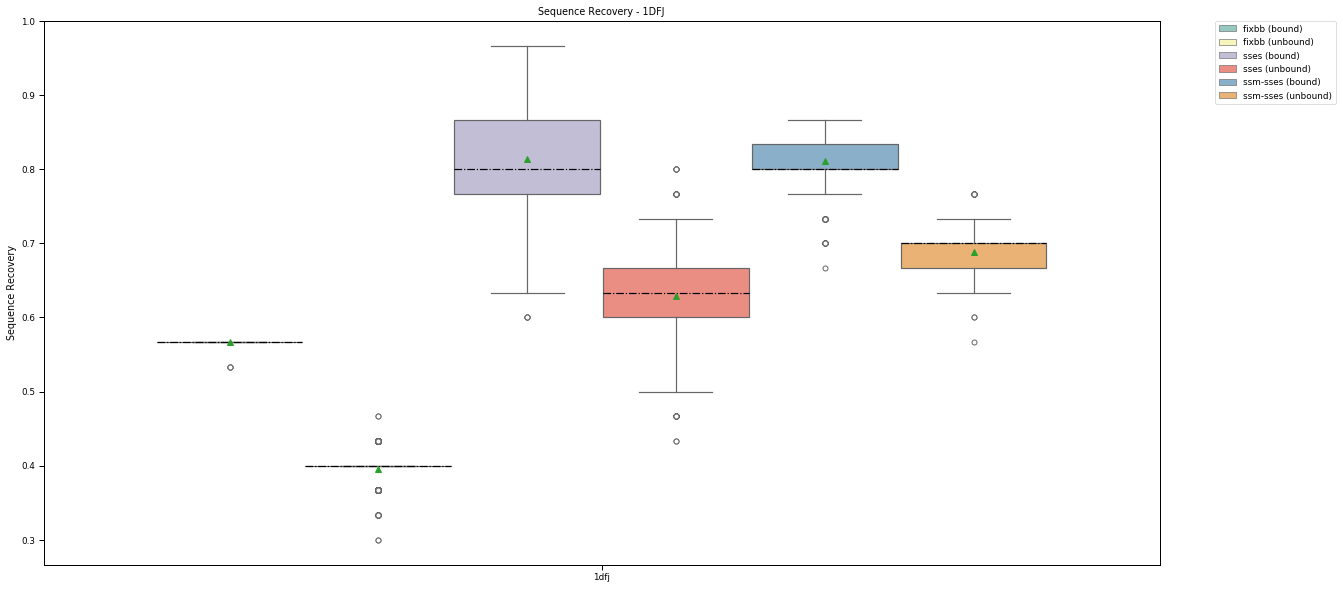

In [120]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_1dfj, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 1DFJ')

#### Mean recovery rates for every sequence design method

In [121]:
print('anot_bound_fixbb_1dfj', anot_bound_fixbb_1dfj['seqrec'].mean())
print('anot_unbound_fixbb_1dfj', anot_unbound_fixbb_1dfj['seqrec'].mean())
print('anot_bound_sses_1dfj', anot_bound_sses_1dfj['seqrec'].mean())
print('anot_unbound_sses_1dfj', anot_unbound_sses_1dfj['seqrec'].mean())
print('anot_bound_ssm_sses_1dfj', anot_bound_ssm_sses_1dfj['seqrec'].mean())
print('anot_unbound_ssm_sses_1dfj', anot_unbound_ssm_sses_1dfj['seqrec'].mean())

anot_bound_fixbb_1dfj 0.5665333333333332
anot_unbound_fixbb_1dfj 0.3959666666666667
anot_bound_sses_1dfj 0.8139666666666668
anot_unbound_sses_1dfj 0.6283666666666665
anot_bound_ssm_sses_1dfj 0.8108666666666667
anot_unbound_ssm_sses_1dfj 0.6879333333333332


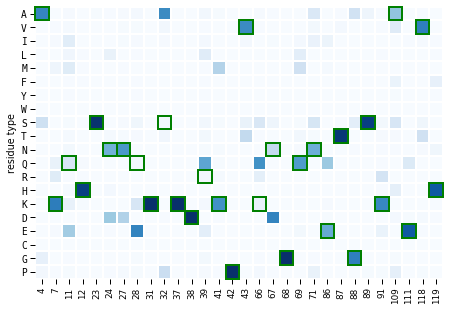

In [122]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_unbound_sses_1dfj, 'X', ax, 
                                 key_residues=rsb.components.Selection('4X,7X,11X,12X,23X,24X,27X,28X,31X,32X,37X,38X,39X,41X,42X,43X,66X,67X,68X,69X,71X,86X,87X,88X,89X,91X,109X,111X,118X,119X'),
                                 refseq=True, cbar=False, xrotation=90)

### 1emv

#### Parse silent files resulting from sequence recovery design

In [123]:
description = {'sequence': 'X'}

bound_fixbb_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/1emv/bound_fixbb_1emv.silent', description)
unbound_fixbb_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/1emv/unbound_fixbb_1emv.silent', description)

bound_sses_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/1emv/bound_surf_1emv.silent', description)
unbound_sses_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/1emv/unbound_surf_1emv.silent', description)

bound_ssm_sses_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/1emv/bound_surf_ssm_1emv.silent', description)
unbound_ssm_sses_1emv = rsb.io.parse_rosetta_file('./data/interface_recovery/1emv/unbound_surf_ssm_1emv.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [124]:
bound_sses_1emv['sses'] = bound_sses_1emv.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_1emv['sses'] = bound_ssm_sses_1emv.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_1emv['sses'] = unbound_sses_1emv.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_1emv['sses'] = unbound_ssm_sses_1emv.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [125]:
print('bound_fixbb_1emv', bound_fixbb_1emv.shape)
print('unbound_fixbb_1emv', unbound_fixbb_1emv.shape)
print('bound_sses_1emv', bound_sses_1emv.shape)
print('unbound_sses_1emv', unbound_sses_1emv.shape)
print('bound_ssm_sses_1emv', bound_ssm_sses_1emv.shape)
print('unbound_ssm_sses_1emv', unbound_ssm_sses_1emv.shape)

bound_fixbb_1emv (1144, 28)
unbound_fixbb_1emv (1144, 27)
bound_sses_1emv (5150, 29)
unbound_sses_1emv (4898, 29)
bound_ssm_sses_1emv (5122, 29)
unbound_ssm_sses_1emv (5195, 29)


#### Adding the reference sequences and interfaces residues of interest

After the designs were carried out, I removed residue 170X (T) from the sequence recovery evaluation as it is not sufficiently pointing towards the interface

In [126]:
bound_fixbb_1emv.add_reference('X', 'MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKEFKSFDDFRKAVWEEVSKDPELSKNLNPSNKSSVSKGYSPFTPKNQQVGGRKVYELHHDKPISQGGEVYDMDNIRVTTPKRHIDIH', shift=84)
bound_fixbb_1emv['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_1emv, 'X', key_residues=rsb.components.Selection('134X,137X,138X,154X,155X,156X,157X,158X,160X,161X,164X,166X,167X,169X,171X,172X,175X,180X,181X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_1emv.add_reference('X', 'MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKEFKSFDDFRKAVWEEVSKDPELSKNLNPSNKSSVSKGYSPFTPKNQQVGGRKVYELHHDKPISQGGEVYDMDNIRVTTPKRHIDIH', shift=84)
unbound_fixbb_1emv['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_1emv, 'X', key_residues=rsb.components.Selection('134X,137X,138X,154X,155X,156X,157X,158X,160X,161X,164X,166X,167X,169X,171X,172X,175X,180X,181X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_1emv.add_reference('X', 'MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKEFKSFDDFRKAVWEEVSKDPELSKNLNPSNKSSVSKGYSPFTPKNQQVGGRKVYELHHDKPISQGGEVYDMDNIRVTTPKRHIDIH', shift=84)
bound_sses_1emv['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_1emv, 'X', key_residues=rsb.components.Selection('134X,137X,138X,154X,155X,156X,157X,158X,160X,161X,164X,166X,167X,169X,171X,172X,175X,180X,181X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_1emv.add_reference('X', 'MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKEFKSFDDFRKAVWEEVSKDPELSKNLNPSNKSSVSKGYSPFTPKNQQVGGRKVYELHHDKPISQGGEVYDMDNIRVTTPKRHIDIH', shift=84)
unbound_sses_1emv['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_1emv, 'X', key_residues=rsb.components.Selection('134X,137X,138X,154X,155X,156X,157X,158X,160X,161X,164X,166X,167X,169X,171X,172X,175X,180X,181X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_1emv.add_reference('X', 'MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKEFKSFDDFRKAVWEEVSKDPELSKNLNPSNKSSVSKGYSPFTPKNQQVGGRKVYELHHDKPISQGGEVYDMDNIRVTTPKRHIDIH', shift=84)
bound_ssm_sses_1emv['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_1emv, 'X', key_residues=rsb.components.Selection('134X,137X,138X,154X,155X,156X,157X,158X,160X,161X,164X,166X,167X,169X,171X,172X,175X,180X,181X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_1emv.add_reference('X', 'MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKEFKSFDDFRKAVWEEVSKDPELSKNLNPSNKSSVSKGYSPFTPKNQQVGGRKVYELHHDKPISQGGEVYDMDNIRVTTPKRHIDIH', shift=84)
unbound_ssm_sses_1emv['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_1emv, 'X', key_residues=rsb.components.Selection('134X,137X,138X,154X,155X,156X,157X,158X,160X,161X,164X,166X,167X,169X,171X,172X,175X,180X,181X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [127]:
anot_bound_fixbb_1emv = bound_fixbb_1emv.sample(1000, random_state=42)
anot_unbound_fixbb_1emv = unbound_fixbb_1emv.sample(1000, random_state=42)
anot_bound_sses_1emv = bound_sses_1emv.sample(1000, random_state=42)
anot_unbound_sses_1emv = unbound_sses_1emv.sample(1000, random_state=42)
anot_bound_ssm_sses_1emv = bound_ssm_sses_1emv.sample(1000, random_state=42)
anot_unbound_ssm_sses_1emv = unbound_ssm_sses_1emv.sample(1000, random_state=42)


anot_bound_fixbb_1emv = anot_bound_fixbb_1emv.assign(protein='1emv', variant='fixbb (bound)')
anot_unbound_fixbb_1emv = anot_unbound_fixbb_1emv.assign(protein='1emv', variant='fixbb (unbound)')
anot_bound_sses_1emv = anot_bound_sses_1emv.assign(protein='1emv', variant='sses (bound)')
anot_unbound_sses_1emv = anot_unbound_sses_1emv.assign(protein='1emv', variant='sses (unbound)')
anot_bound_ssm_sses_1emv = anot_bound_ssm_sses_1emv.assign(protein='1emv', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_1emv = anot_unbound_ssm_sses_1emv.assign(protein='1emv', variant='ssm-sses (unbound)')


anot_1emv = pd.concat([anot_bound_fixbb_1emv, anot_unbound_fixbb_1emv,
                       anot_bound_sses_1emv, anot_unbound_sses_1emv,
                       anot_bound_ssm_sses_1emv, anot_unbound_ssm_sses_1emv], sort=False)

mdf_1emv = anot_1emv.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 1EMV')

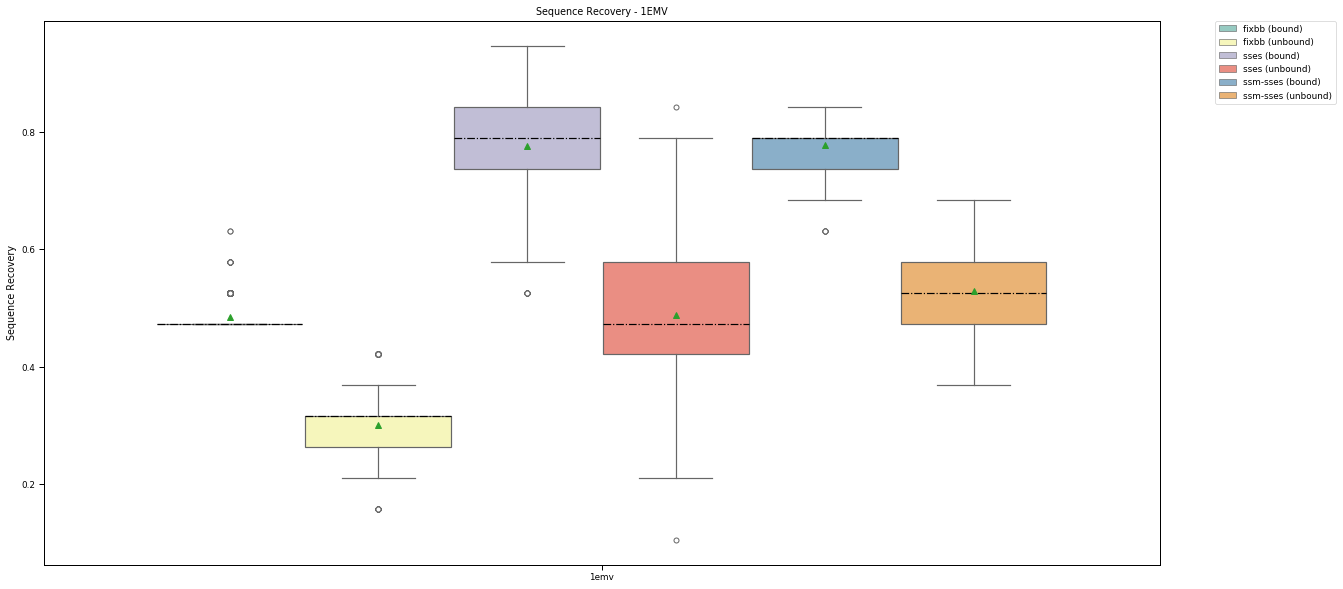

In [128]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_1emv, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 1EMV')

#### Mean recovery rates for every sequence design method

In [129]:
print('anot_bound_fixbb_1emv', anot_bound_fixbb_1emv['seqrec'].mean())
print('anot_unbound_fixbb_1emv', anot_unbound_fixbb_1emv['seqrec'].mean())
print('anot_bound_sses_1emv', anot_bound_sses_1emv['seqrec'].mean())
print('anot_unbound_sses_1emv', anot_unbound_sses_1emv['seqrec'].mean())
print('anot_bound_ssm_sses_1emv', anot_bound_ssm_sses_1emv['seqrec'].mean())
print('anot_unbound_ssm_sses_1emv', anot_unbound_ssm_sses_1emv['seqrec'].mean())

anot_bound_fixbb_1emv 0.48552631578947375
anot_unbound_fixbb_1emv 0.30136842105263156
anot_bound_sses_1emv 0.7770526315789473
anot_unbound_sses_1emv 0.48889473684210527
anot_bound_ssm_sses_1emv 0.7787368421052631
anot_unbound_ssm_sses_1emv 0.5292631578947369


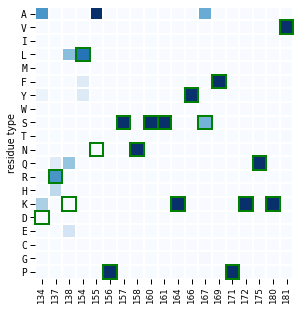

In [130]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_1emv, 'X', ax, 
                                 key_residues=rsb.components.Selection('134X,137X,138X,154X,155X,156X,157X,158X,160X,161X,164X,166X,167X,169X,171X,172X,175X,180X,181X'),
                                 refseq=True, cbar=False, xrotation=90)

### 1ppe

#### Parse silent files resulting from sequence recovery design

In [131]:
description = {'sequence': 'X'}

bound_fixbb_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/1ppe/bound_fixbb_1ppe.silent', description)
unbound_fixbb_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/1ppe/unbound_fixbb_1ppe.silent', description)

bound_sses_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/1ppe/bound_surf_1ppe.silent', description)
unbound_sses_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/1ppe/unbound_surf_1ppe.silent', description)

bound_ssm_sses_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/1ppe/bound_surf_ssm_1ppe.silent', description)
unbound_ssm_sses_1ppe = rsb.io.parse_rosetta_file('./data/interface_recovery/1ppe/unbound_surf_ssm_1ppe.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [132]:
bound_sses_1ppe['sses'] = bound_sses_1ppe.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_1ppe['sses'] = bound_ssm_sses_1ppe.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_1ppe['sses'] = unbound_sses_1ppe.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_1ppe['sses'] = unbound_ssm_sses_1ppe.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [133]:
print('bound_fixbb_1ppe', bound_fixbb_1ppe.shape)
print('unbound_fixbb_1ppe', unbound_fixbb_1ppe.shape)
print('bound_sses_1ppe', bound_sses_1ppe.shape)
print('unbound_sses_1ppe', unbound_sses_1ppe.shape)
print('bound_ssm_sses_1ppe', bound_ssm_sses_1ppe.shape)
print('unbound_ssm_sses_1ppe', unbound_ssm_sses_1ppe.shape)

bound_fixbb_1ppe (1144, 28)
unbound_fixbb_1ppe (1144, 27)
bound_sses_1ppe (9150, 29)
unbound_sses_1ppe (9161, 29)
bound_ssm_sses_1ppe (9599, 29)
unbound_ssm_sses_1ppe (8869, 29)


#### Adding the reference sequences and interfaces residues of interest

In [134]:
bound_fixbb_1ppe.add_reference('X', 'RVCPRILMECKKDSDCLAECVCLEHGYCG', shift=223)
bound_fixbb_1ppe['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_1ppe, 'X', key_residues=rsb.components.Selection('223X,224X,226X-231X,239X,240X,241X,245X,246X,247X,249X,251X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_1ppe.add_reference('X', 'RVCPRILMECKKDSDCLAECVCLEHGYCG', shift=223)
unbound_fixbb_1ppe['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_1ppe, 'X', key_residues=rsb.components.Selection('223X,224X,226X-231X,239X,240X,241X,245X,246X,247X,249X,251X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_1ppe.add_reference('X', 'RVCPRILMECKKDSDCLAECVCLEHGYCG', shift=223)
bound_sses_1ppe['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_1ppe, 'X', key_residues=rsb.components.Selection('223X,224X,226X-231X,239X,240X,241X,245X,246X,247X,249X,251X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_1ppe.add_reference('X', 'RVCPRILMECKKDSDCLAECVCLEHGYCG', shift=223)
unbound_sses_1ppe['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_1ppe, 'X', key_residues=rsb.components.Selection('223X,224X,226X-231X,239X,240X,241X,245X,246X,247X,249X,251X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_1ppe.add_reference('X', 'RVCPRILMECKKDSDCLAECVCLEHGYCG', shift=223)
bound_ssm_sses_1ppe['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_1ppe, 'X', key_residues=rsb.components.Selection('223X,224X,226X-231X,239X,240X,241X,245X,246X,247X,249X,251X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_1ppe.add_reference('X', 'RVCPRILMECKKDSDCLAECVCLEHGYCG', shift=223)
unbound_ssm_sses_1ppe['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_1ppe, 'X', key_residues=rsb.components.Selection('223X,224X,226X-231X,239X,240X,241X,245X,246X,247X,249X,251X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [135]:
anot_bound_fixbb_1ppe = bound_fixbb_1ppe.sample(1000, random_state=42)
anot_unbound_fixbb_1ppe = unbound_fixbb_1ppe.sample(1000, random_state=42)
anot_bound_sses_1ppe = bound_sses_1ppe.sample(1000, random_state=42)
anot_unbound_sses_1ppe = unbound_sses_1ppe.sample(1000, random_state=42)
anot_bound_ssm_sses_1ppe = bound_ssm_sses_1ppe.sample(1000, random_state=42)
anot_unbound_ssm_sses_1ppe = unbound_ssm_sses_1ppe.sample(1000, random_state=42)


anot_bound_fixbb_1ppe = anot_bound_fixbb_1ppe.assign(protein='1ppe', variant='fixbb (bound)')
anot_unbound_fixbb_1ppe = anot_unbound_fixbb_1ppe.assign(protein='1ppe', variant='fixbb (unbound)')
anot_bound_sses_1ppe = anot_bound_sses_1ppe.assign(protein='1ppe', variant='sses (bound)')
anot_unbound_sses_1ppe = anot_unbound_sses_1ppe.assign(protein='1ppe', variant='sses (unbound)')
anot_bound_ssm_sses_1ppe = anot_bound_ssm_sses_1ppe.assign(protein='1ppe', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_1ppe = anot_unbound_ssm_sses_1ppe.assign(protein='1ppe', variant='ssm-sses (unbound)')


anot_1ppe = pd.concat([anot_bound_fixbb_1ppe, anot_unbound_fixbb_1ppe,
                       anot_bound_sses_1ppe, anot_unbound_sses_1ppe,
                       anot_bound_ssm_sses_1ppe, anot_unbound_ssm_sses_1ppe], sort=False)

mdf_1ppe = anot_1ppe.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 1PPE')

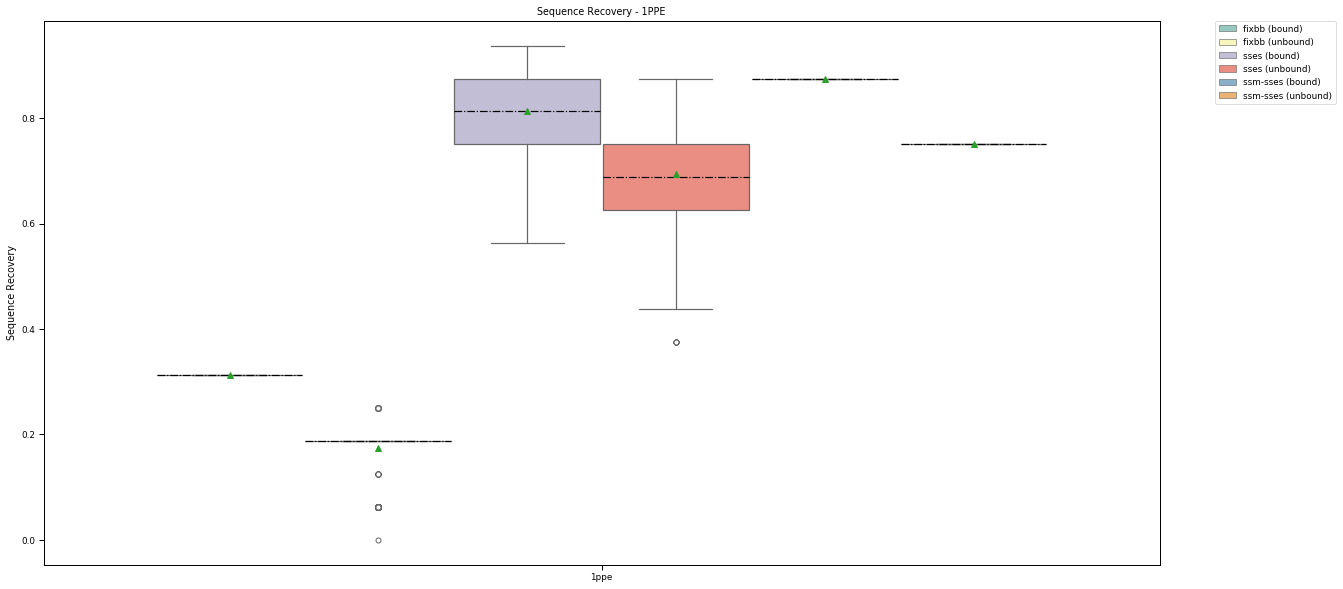

In [136]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_1ppe, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 1PPE')

#### Mean recovery rates for every sequence design method

In [137]:
print('anot_bound_fixbb_1ppe', anot_bound_fixbb_1ppe['seqrec'].mean())
print('anot_unbound_fixbb_1ppe', anot_unbound_fixbb_1ppe['seqrec'].mean())
print('anot_bound_sses_1ppe', anot_bound_sses_1ppe['seqrec'].mean())
print('anot_unbound_sses_1ppe', anot_unbound_sses_1ppe['seqrec'].mean())
print('anot_bound_ssm_sses_1ppe', anot_bound_ssm_sses_1ppe['seqrec'].mean())
print('anot_unbound_ssm_sses_1ppe', anot_unbound_ssm_sses_1ppe['seqrec'].mean())

anot_bound_fixbb_1ppe 0.3125
anot_unbound_fixbb_1ppe 0.17475
anot_bound_sses_1ppe 0.8136875
anot_unbound_sses_1ppe 0.6945625
anot_bound_ssm_sses_1ppe 0.875
anot_unbound_ssm_sses_1ppe 0.75


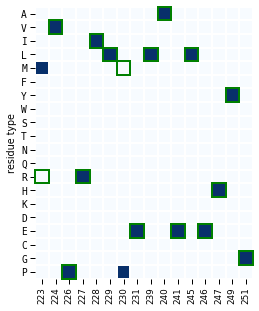

In [138]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_1ppe, 'X', ax, 
                                 key_residues=rsb.components.Selection('223X,224X,226X-231X,239X,240X,241X,245X,246X,247X,249X,251X'),
                                 refseq=True, cbar=False, xrotation=90)

### 1rv6

#### Parse silent files resulting from sequence recovery design

In [139]:
description = {'sequence': 'X'}

bound_fixbb_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/1rv6/bound_fixbb_1rv6.silent', description)
unbound_fixbb_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/1rv6/unbound_fixbb_1rv6.silent', description)

bound_sses_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/1rv6/bound_surf_1rv6.silent', description)
unbound_sses_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/1rv6/unbound_surf_1rv6.silent', description)

bound_ssm_sses_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/1rv6/bound_surf_ssm_1rv6.silent', description)
unbound_ssm_sses_1rv6 = rsb.io.parse_rosetta_file('./data/interface_recovery/1rv6/unbound_surf_ssm_1rv6.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [140]:
bound_sses_1rv6['sses'] = bound_sses_1rv6.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_1rv6['sses'] = bound_ssm_sses_1rv6.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_1rv6['sses'] = unbound_sses_1rv6.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_1rv6['sses'] = unbound_ssm_sses_1rv6.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [141]:
print('bound_fixbb_1rv6', bound_fixbb_1rv6.shape)
print('unbound_fixbb_1rv6', unbound_fixbb_1rv6.shape)
print('bound_sses_1rv6', bound_sses_1rv6.shape)
print('unbound_sses_1rv6', unbound_sses_1rv6.shape)
print('bound_ssm_sses_1rv6', bound_ssm_sses_1rv6.shape)
print('unbound_ssm_sses_1rv6', unbound_ssm_sses_1rv6.shape)

bound_fixbb_1rv6 (1144, 28)
unbound_fixbb_1rv6 (1144, 27)
bound_sses_1rv6 (9170, 29)
unbound_sses_1rv6 (8008, 29)
bound_ssm_sses_1rv6 (9438, 29)
unbound_ssm_sses_1rv6 (9001, 29)


#### Adding the reference sequences and interfaces residues of interest

In [142]:
bound_fixbb_1rv6.add_reference('X', 'RPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGKRIIWDSRKGFIISNATYKEIGLLTCEATVNGHLYKTNYLTHR', shift=190)
bound_fixbb_1rv6['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_1rv6, 'X', key_residues=rsb.components.Selection('198X,199X,200X,202X,204X,228X,229X,230X,231X,256X,259X,260X,261X,276X,278X,280X,281X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_1rv6.add_reference('X', 'RPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGKRIIWDSRKGFIISNATYKEIGLLTCEATVNGHLYKTNYLTHR', shift=190)
unbound_fixbb_1rv6['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_1rv6, 'X', key_residues=rsb.components.Selection('198X,199X,200X,202X,204X,228X,229X,230X,231X,256X,259X,260X,261X,276X,278X,280X,281X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_1rv6.add_reference('X', 'RPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGKRIIWDSRKGFIISNATYKEIGLLTCEATVNGHLYKTNYLTHR', shift=190)
bound_sses_1rv6['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_1rv6, 'X', key_residues=rsb.components.Selection('198X,199X,200X,202X,204X,228X,229X,230X,231X,256X,259X,260X,261X,276X,278X,280X,281X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_1rv6.add_reference('X', 'RPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGKRIIWDSRKGFIISNATYKEIGLLTCEATVNGHLYKTNYLTHR', shift=190)
unbound_sses_1rv6['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_1rv6, 'X', key_residues=rsb.components.Selection('198X,199X,200X,202X,204X,228X,229X,230X,231X,256X,259X,260X,261X,276X,278X,280X,281X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_1rv6.add_reference('X', 'RPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGKRIIWDSRKGFIISNATYKEIGLLTCEATVNGHLYKTNYLTHR', shift=190)
bound_ssm_sses_1rv6['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_1rv6, 'X', key_residues=rsb.components.Selection('198X,199X,200X,202X,204X,228X,229X,230X,231X,256X,259X,260X,261X,276X,278X,280X,281X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_1rv6.add_reference('X', 'RPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGKRIIWDSRKGFIISNATYKEIGLLTCEATVNGHLYKTNYLTHR', shift=190)
unbound_ssm_sses_1rv6['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_1rv6, 'X', key_residues=rsb.components.Selection('198X,199X,200X,202X,204X,228X,229X,230X,231X,256X,259X,260X,261X,276X,278X,280X,281X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [143]:
anot_bound_fixbb_1rv6 = bound_fixbb_1rv6.sample(1000, random_state=42)
anot_unbound_fixbb_1rv6 = unbound_fixbb_1rv6.sample(1000, random_state=42)
anot_bound_sses_1rv6 = bound_sses_1rv6.sample(1000, random_state=42)
anot_unbound_sses_1rv6 = unbound_sses_1rv6.sample(1000, random_state=42)
anot_bound_ssm_sses_1rv6 = bound_ssm_sses_1rv6.sample(1000, random_state=42)
anot_unbound_ssm_sses_1rv6 = unbound_ssm_sses_1rv6.sample(1000, random_state=42)


anot_bound_fixbb_1rv6 = anot_bound_fixbb_1rv6.assign(protein='1rv6', variant='fixbb (bound)')
anot_unbound_fixbb_1rv6 = anot_unbound_fixbb_1rv6.assign(protein='1rv6', variant='fixbb (unbound)')
anot_bound_sses_1rv6 = anot_bound_sses_1rv6.assign(protein='1rv6', variant='sses (bound)')
anot_unbound_sses_1rv6 = anot_unbound_sses_1rv6.assign(protein='1rv6', variant='sses (unbound)')
anot_bound_ssm_sses_1rv6 = anot_bound_ssm_sses_1rv6.assign(protein='1rv6', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_1rv6 = anot_unbound_ssm_sses_1rv6.assign(protein='1rv6', variant='ssm-sses (unbound)')


anot_1rv6 = pd.concat([anot_bound_fixbb_1rv6, anot_unbound_fixbb_1rv6,
                       anot_bound_sses_1rv6, anot_unbound_sses_1rv6,
                       anot_bound_ssm_sses_1rv6, anot_unbound_ssm_sses_1rv6], sort=False)

mdf_1rv6 = anot_1rv6.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 1RV6')

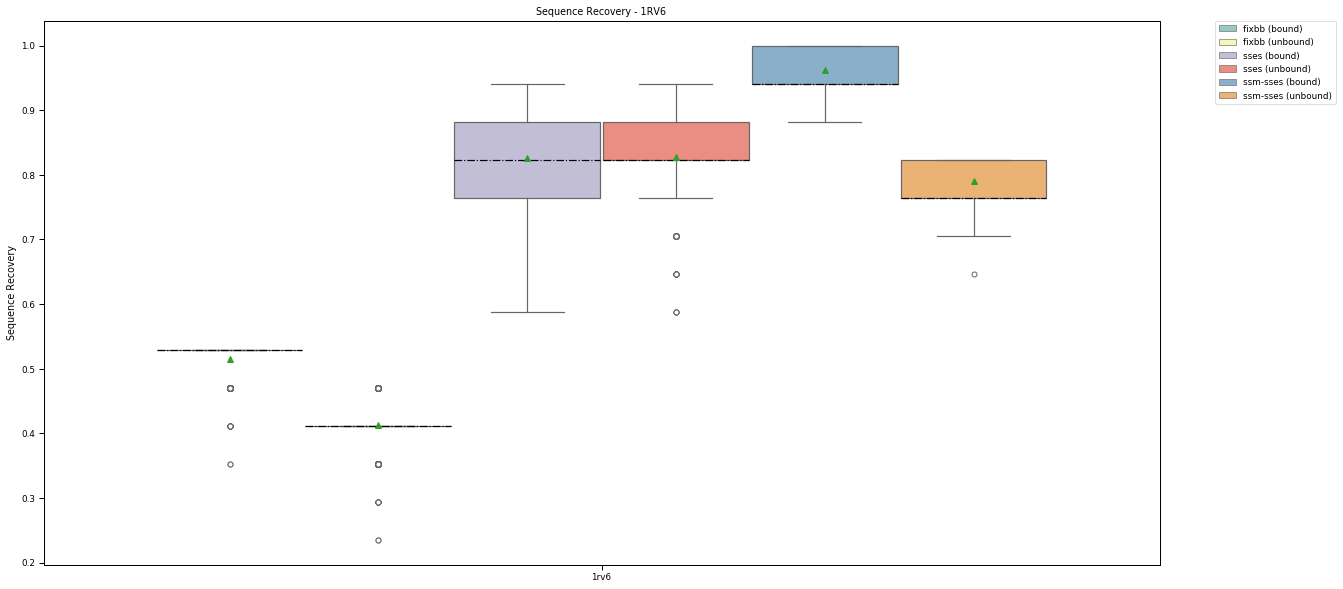

In [144]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_1rv6, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 1RV6')

#### Mean recovery rates for every sequence design method

In [145]:
print('anot_bound_fixbb_1rv6', anot_bound_fixbb_1rv6['seqrec'].mean())
print('anot_unbound_fixbb_1rv6', anot_unbound_fixbb_1rv6['seqrec'].mean())
print('anot_bound_sses_1rv6', anot_bound_sses_1rv6['seqrec'].mean())
print('anot_unbound_sses_1rv6', anot_unbound_sses_1rv6['seqrec'].mean())
print('anot_bound_ssm_sses_1rv6', anot_bound_ssm_sses_1rv6['seqrec'].mean())
print('anot_unbound_ssm_sses_1rv6', anot_unbound_ssm_sses_1rv6['seqrec'].mean())

anot_bound_fixbb_1rv6 0.5155294117647059
anot_unbound_fixbb_1rv6 0.4127647058823529
anot_bound_sses_1rv6 0.8253529411764707
anot_unbound_sses_1rv6 0.8279411764705883
anot_bound_ssm_sses_1rv6 0.9627647058823531
anot_unbound_ssm_sses_1rv6 0.7911176470588237


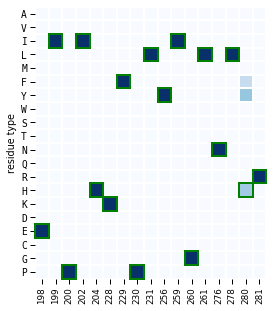

In [146]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_1rv6, 'X', ax, 
                                 key_residues=rsb.components.Selection('198X,199X,200X,202X,204X,228X,229X,230X,231X,256X,259X,260X,261X,276X,278X,280X,281X'),
                                 refseq=True, cbar=False, xrotation=90)

### 3idx

#### Parse silent files resulting from sequence recovery design

In [147]:
description = {'sequence': 'X'}

bound_fixbb_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/3idx/bound_fixbb_3idx.silent', description)
unbound_fixbb_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/3idx/unbound_fixbb_3idx.silent', description)

bound_sses_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/3idx/bound_surf_3idx.silent', description)
unbound_sses_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/3idx/unbound_surf_3idx.silent', description)

bound_ssm_sses_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/3idx/bound_surf_ssm_3idx.silent', description)
unbound_ssm_sses_3idx = rsb.io.parse_rosetta_file('./data/interface_recovery/3idx/unbound_surf_ssm_3idx.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [148]:
bound_sses_3idx['sses'] = bound_sses_3idx.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_3idx['sses'] = bound_ssm_sses_3idx.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_3idx['sses'] = unbound_sses_3idx.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_3idx['sses'] = unbound_ssm_sses_3idx.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [149]:
print('bound_fixbb_3idx', bound_fixbb_3idx.shape)
print('unbound_fixbb_3idx', unbound_fixbb_3idx.shape)
print('bound_sses_3idx', bound_sses_3idx.shape)
print('unbound_sses_3idx', unbound_sses_3idx.shape)
print('bound_ssm_sses_3idx', bound_ssm_sses_3idx.shape)
print('unbound_ssm_sses_3idx', unbound_ssm_sses_3idx.shape)

bound_fixbb_3idx (5148, 27)
unbound_fixbb_3idx (5148, 27)
bound_sses_3idx (5978, 29)
unbound_sses_3idx (8466, 29)
bound_ssm_sses_3idx (3638, 29)
unbound_ssm_sses_3idx (1370, 29)


#### Adding the reference sequences and interfaces residues of interest

In [150]:
bound_fixbb_3idx.add_reference('X', 'VVSSQLLLNGSLAEEEVVIRSCNFTDNAKTIIVQLNTSVEINCTGAGHCNIARAKWNNTLKQIASKLREQFGNNKTIIFKQSSGGDPEIVTHWFNCGGEFFYCNSTQLFNSTWFNSGSDTITLPCRIKQIINMWCKVGKMMYAPPISGQIRCSSNITGLLLTRDGGNSNNESEIFRPGGGDMRDNWR', shift=341)
bound_fixbb_3idx['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_3idx, 'X', key_residues=rsb.components.Selection('424X,425X,426X,427X,428X,429X,430X,431X,442X,466X,468X,473X,520X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_3idx.add_reference('X', 'VVSSQLLLNGSLAEEEVVIRSCNFTDNAKTIIVQLNTSVEINCTGAGHCNIARAKWNNTLKQIASKLREQFGNNKTIIFKQSSGGDPEIVTHWFNCGGEFFYCNSTQLFNSTWFNSGSDTITLPCRIKQIINMWCKVGKMMYAPPISGQIRCSSNITGLLLTRDGGNSNNESEIFRPGGGDMRDNWR', shift=341)
unbound_fixbb_3idx['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_3idx, 'X', key_residues=rsb.components.Selection('424X,425X,426X,427X,428X,429X,430X,431X,442X,466X,468X,473X,520X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_3idx.add_reference('X', 'VVSSQLLLNGSLAEEEVVIRSCNFTDNAKTIIVQLNTSVEINCTGAGHCNIARAKWNNTLKQIASKLREQFGNNKTIIFKQSSGGDPEIVTHWFNCGGEFFYCNSTQLFNSTWFNSGSDTITLPCRIKQIINMWCKVGKMMYAPPISGQIRCSSNITGLLLTRDGGNSNNESEIFRPGGGDMRDNWR', shift=341)
bound_sses_3idx['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_3idx, 'X', key_residues=rsb.components.Selection('424X,425X,426X,427X,428X,429X,430X,431X,442X,466X,468X,473X,520X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_3idx.add_reference('X', 'VVSSQLLLNGSLAEEEVVIRSCNFTDNAKTIIVQLNTSVEINCTGAGHCNIARAKWNNTLKQIASKLREQFGNNKTIIFKQSSGGDPEIVTHWFNCGGEFFYCNSTQLFNSTWFNSGSDTITLPCRIKQIINMWCKVGKMMYAPPISGQIRCSSNITGLLLTRDGGNSNNESEIFRPGGGDMRDNWR', shift=341)
unbound_sses_3idx['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_3idx, 'X', key_residues=rsb.components.Selection('424X,425X,426X,427X,428X,429X,430X,431X,442X,466X,468X,473X,520X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_3idx.add_reference('X', 'VVSSQLLLNGSLAEEEVVIRSCNFTDNAKTIIVQLNTSVEINCTGAGHCNIARAKWNNTLKQIASKLREQFGNNKTIIFKQSSGGDPEIVTHWFNCGGEFFYCNSTQLFNSTWFNSGSDTITLPCRIKQIINMWCKVGKMMYAPPISGQIRCSSNITGLLLTRDGGNSNNESEIFRPGGGDMRDNWR', shift=341)
bound_ssm_sses_3idx['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_3idx, 'X', key_residues=rsb.components.Selection('424X,425X,426X,427X,428X,429X,430X,431X,442X,466X,468X,473X,520X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_3idx.add_reference('X', 'VVSSQLLLNGSLAEEEVVIRSCNFTDNAKTIIVQLNTSVEINCTGAGHCNIARAKWNNTLKQIASKLREQFGNNKTIIFKQSSGGDPEIVTHWFNCGGEFFYCNSTQLFNSTWFNSGSDTITLPCRIKQIINMWCKVGKMMYAPPISGQIRCSSNITGLLLTRDGGNSNNESEIFRPGGGDMRDNWR', shift=341)
unbound_ssm_sses_3idx['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_3idx, 'X', key_residues=rsb.components.Selection('424X,425X,426X,427X,428X,429X,430X,431X,442X,466X,468X,473X,520X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [151]:
anot_bound_fixbb_3idx = bound_fixbb_3idx.sample(1000, random_state=42)
anot_unbound_fixbb_3idx = unbound_fixbb_3idx.sample(1000, random_state=42)
anot_bound_sses_3idx = bound_sses_3idx.sample(1000, random_state=42)
anot_unbound_sses_3idx = unbound_sses_3idx.sample(1000, random_state=42)
anot_bound_ssm_sses_3idx = bound_ssm_sses_3idx.sample(1000, random_state=42)
anot_unbound_ssm_sses_3idx = unbound_ssm_sses_3idx.sample(1000, random_state=42)


anot_bound_fixbb_3idx = anot_bound_fixbb_3idx.assign(protein='3idx', variant='fixbb (bound)')
anot_unbound_fixbb_3idx = anot_unbound_fixbb_3idx.assign(protein='3idx', variant='fixbb (unbound)')
anot_bound_sses_3idx = anot_bound_sses_3idx.assign(protein='3idx', variant='sses (bound)')
anot_unbound_sses_3idx = anot_unbound_sses_3idx.assign(protein='3idx', variant='sses (unbound)')
anot_bound_ssm_sses_3idx = anot_bound_ssm_sses_3idx.assign(protein='3idx', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_3idx = anot_unbound_ssm_sses_3idx.assign(protein='3idx', variant='ssm-sses (unbound)')


anot_3idx = pd.concat([anot_bound_fixbb_3idx, anot_unbound_fixbb_3idx,
                       anot_bound_sses_3idx, anot_unbound_sses_3idx,
                       anot_bound_ssm_sses_3idx, anot_unbound_ssm_sses_3idx], sort=False)

mdf_3idx = anot_3idx.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 3IDX')

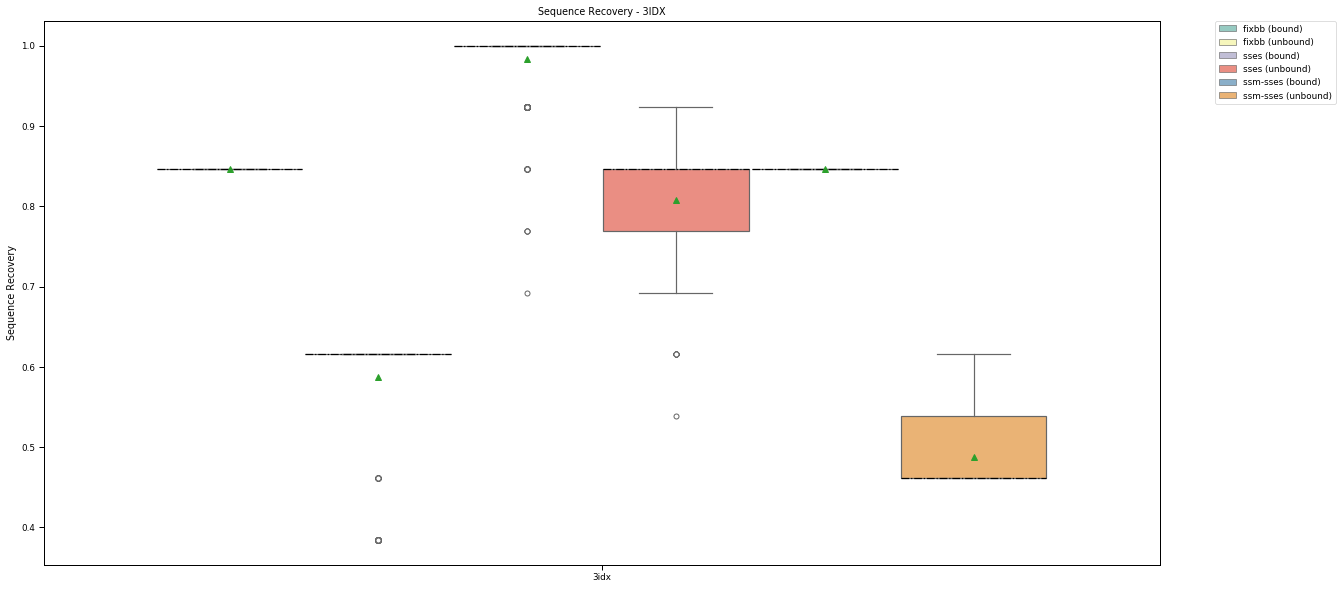

In [152]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_3idx, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 3IDX')

#### Mean recovery rates for every sequence design method

In [153]:
print('anot_bound_fixbb_3idx', anot_bound_fixbb_3idx['seqrec'].mean())
print('anot_unbound_fixbb_3idx', anot_unbound_fixbb_3idx['seqrec'].mean())
print('anot_bound_sses_3idx', anot_bound_sses_3idx['seqrec'].mean())
print('anot_unbound_sses_3idx', anot_unbound_sses_3idx['seqrec'].mean())
print('anot_bound_ssm_sses_3idx', anot_bound_ssm_sses_3idx['seqrec'].mean())
print('anot_unbound_ssm_sses_3idx', anot_unbound_ssm_sses_3idx['seqrec'].mean())

anot_bound_fixbb_3idx 0.8461538461538461
anot_unbound_fixbb_3idx 0.5873076923076922
anot_bound_sses_3idx 0.9827692307692308
anot_unbound_sses_3idx 0.8073846153846155
anot_bound_ssm_sses_3idx 0.8461538461538461
anot_unbound_ssm_sses_3idx 0.48738461538461547


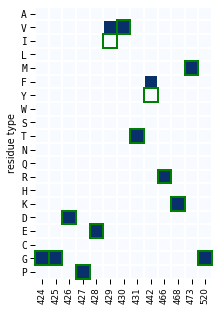

In [154]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_3idx, 'X', ax, 
                                 key_residues=rsb.components.Selection('424X,425X,426X,427X,428X,429X,430X,431X,442X,466X,468X,473X,520X'),
                                 refseq=True, cbar=False, xrotation=90)

### 3mc0

#### Parse silent files resulting from sequence recovery design

In [155]:
description = {'sequence': 'X'}

bound_fixbb_3mc0 = rsb.io.parse_rosetta_file('./data/interface_recovery/3mc0/bound_fixbb_3mc0.silent', description)
unbound_fixbb_3mc0 = rsb.io.parse_rosetta_file('./data/interface_recovery/3mc0/unbound_fixbb_3mc0.silent', description)

bound_sses_3mc0 = rsb.io.parse_rosetta_file('./data/interface_recovery/3mc0/bound_surf_3mc0.silent', description)
unbound_sses_3mc0 = rsb.io.parse_rosetta_file('./data/interface_recovery/3mc0/unbound_surf_3mc0.silent', description)

bound_ssm_sses_3mc0 = rsb.io.parse_rosetta_file('/.data/interface_recovery/3mc0/bound_surf_ssm_3mc0.silent', description)
unbound_ssm_sses_3mc0 = rsb.io.parse_rosetta_file('./data/interface_recovery/3mc0/unbound_surf_ssm_3mc0.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [156]:
bound_sses_3mc0['sses'] = bound_sses_3mc0.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_3mc0['sses'] = bound_ssm_sses_3mc0.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_3mc0['sses'] = unbound_sses_3mc0.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_3mc0['sses'] = unbound_ssm_sses_3mc0.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [157]:
print('bound_fixbb_3mc0', bound_fixbb_3mc0.shape)
print('unbound_fixbb_3mc0', unbound_fixbb_3mc0.shape)
print('bound_sses_3mc0', bound_sses_3mc0.shape)
print('unbound_sses_3mc0', unbound_sses_3mc0.shape)
print('bound_ssm_sses_3mc0', bound_ssm_sses_3mc0.shape)
print('unbound_ssm_sses_3mc0', unbound_ssm_sses_3mc0.shape)

bound_fixbb_3mc0 (2288, 28)
unbound_fixbb_3mc0 (2002, 28)
bound_sses_3mc0 (6006, 29)
unbound_sses_3mc0 (4862, 29)
bound_ssm_sses_3mc0 (5148, 29)
unbound_ssm_sses_3mc0 (5148, 29)


#### Adding the reference sequences and interfaces residues of interest

In [158]:
bound_fixbb_3mc0.add_reference('X', 'AAVTQSPRNKVAVTGEKVTLSCQQTNNHNNMYWYRQDTGHGLRLIHYSYGAGSTEKGDIPDGYKASRPSQEQFSLILESATPSQTSVYFCASGGGGTLYFGAGTRLSVL', shift=1)
bound_fixbb_3mc0['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_3mc0, 'X', key_residues=rsb.components.Selection('46X,49X,50X,51X,52X,53X,54X,55X,56X,64X,70X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_3mc0.add_reference('X', 'AAVTQSPRNKVAVTGEKVTLSCQQTNNHNNMYWYRQDTGHGLRLIHYSYGAGSTEKGDIPDGYKASRPSQEQFSLILESATPSQTSVYFCASGGGGTLYFGAGTRLSVL', shift=1)
unbound_fixbb_3mc0['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_3mc0, 'X', key_residues=rsb.components.Selection('46X,49X,50X,51X,52X,53X,54X,55X,56X,64X,70X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_3mc0.add_reference('X', 'AAVTQSPRNKVAVTGEKVTLSCQQTNNHNNMYWYRQDTGHGLRLIHYSYGAGSTEKGDIPDGYKASRPSQEQFSLILESATPSQTSVYFCASGGGGTLYFGAGTRLSVL', shift=1)
bound_sses_3mc0['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_3mc0, 'X', key_residues=rsb.components.Selection('46X,49X,50X,51X,52X,53X,54X,55X,56X,64X,70X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_3mc0.add_reference('X', 'AAVTQSPRNKVAVTGEKVTLSCQQTNNHNNMYWYRQDTGHGLRLIHYSYGAGSTEKGDIPDGYKASRPSQEQFSLILESATPSQTSVYFCASGGGGTLYFGAGTRLSVL', shift=1)
unbound_sses_3mc0['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_3mc0, 'X', key_residues=rsb.components.Selection('46X,49X,50X,51X,52X,53X,54X,55X,56X,64X,70X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_3mc0.add_reference('X', 'AAVTQSPRNKVAVTGEKVTLSCQQTNNHNNMYWYRQDTGHGLRLIHYSYGAGSTEKGDIPDGYKASRPSQEQFSLILESATPSQTSVYFCASGGGGTLYFGAGTRLSVL', shift=1)
bound_ssm_sses_3mc0['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_3mc0, 'X', key_residues=rsb.components.Selection('46X,49X,50X,51X,52X,53X,54X,55X,56X,64X,70X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_3mc0.add_reference('X', 'AAVTQSPRNKVAVTGEKVTLSCQQTNNHNNMYWYRQDTGHGLRLIHYSYGAGSTEKGDIPDGYKASRPSQEQFSLILESATPSQTSVYFCASGGGGTLYFGAGTRLSVL', shift=1)
unbound_ssm_sses_3mc0['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_3mc0, 'X', key_residues=rsb.components.Selection('46X,49X,50X,51X,52X,53X,54X,55X,56X,64X,70X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [159]:
anot_bound_fixbb_3mc0 = bound_fixbb_3mc0.sample(1000, random_state=42)
anot_unbound_fixbb_3mc0 = unbound_fixbb_3mc0.sample(1000, random_state=42)
anot_bound_sses_3mc0 = bound_sses_3mc0.sample(1000, random_state=42)
anot_unbound_sses_3mc0 = unbound_sses_3mc0.sample(1000, random_state=42)
anot_bound_ssm_sses_3mc0 = bound_ssm_sses_3mc0.sample(1000, random_state=42)
anot_unbound_ssm_sses_3mc0 = unbound_ssm_sses_3mc0.sample(1000, random_state=42)


anot_bound_fixbb_3mc0 = anot_bound_fixbb_3mc0.assign(protein='3mc0', variant='fixbb (bound)')
anot_unbound_fixbb_3mc0 = anot_unbound_fixbb_3mc0.assign(protein='3mc0', variant='fixbb (unbound)')
anot_bound_sses_3mc0 = anot_bound_sses_3mc0.assign(protein='3mc0', variant='sses (bound)')
anot_unbound_sses_3mc0 = anot_unbound_sses_3mc0.assign(protein='3mc0', variant='sses (unbound)')
anot_bound_ssm_sses_3mc0 = anot_bound_ssm_sses_3mc0.assign(protein='3mc0', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_3mc0 = anot_unbound_ssm_sses_3mc0.assign(protein='3mc0', variant='ssm-sses (unbound)')


anot_3mc0 = pd.concat([anot_bound_fixbb_3mc0, anot_unbound_fixbb_3mc0,
                       anot_bound_sses_3mc0, anot_unbound_sses_3mc0,
                       anot_bound_ssm_sses_3mc0, anot_unbound_ssm_sses_3mc0], sort=False)

mdf_3mc0 = anot_3mc0.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 3MC0')

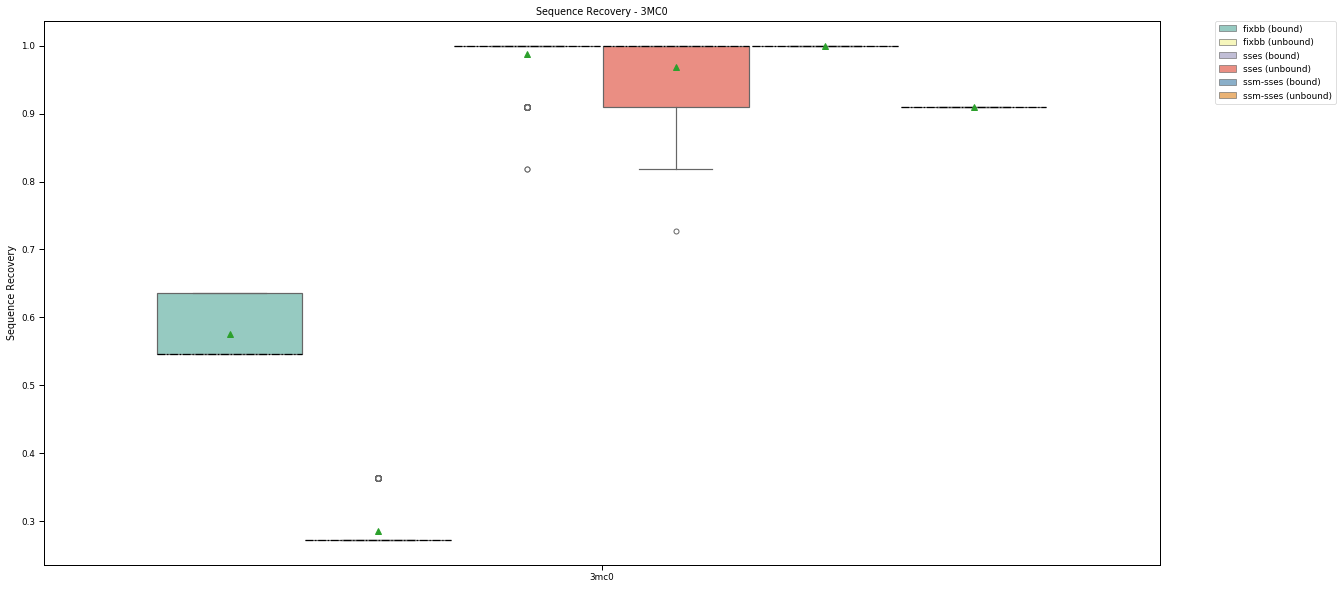

In [160]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_3mc0, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 3MC0')

#### Mean recovery rates for every sequence design method

In [161]:
print('anot_bound_fixbb_3mc0', anot_bound_fixbb_3mc0['seqrec'].mean())
print('anot_unbound_fixbb_3mc0', anot_unbound_fixbb_3mc0['seqrec'].mean())
print('anot_bound_sses_3mc0', anot_bound_sses_3mc0['seqrec'].mean())
print('anot_unbound_sses_3mc0', anot_unbound_sses_3mc0['seqrec'].mean())
print('anot_bound_ssm_sses_3mc0', anot_bound_ssm_sses_3mc0['seqrec'].mean())
print('anot_unbound_ssm_sses_3mc0', anot_unbound_ssm_sses_3mc0['seqrec'].mean())

anot_bound_fixbb_3mc0 0.5755454545454545
anot_unbound_fixbb_3mc0 0.2852727272727272
anot_bound_sses_3mc0 0.9878181818181817
anot_unbound_sses_3mc0 0.9685454545454545
anot_bound_ssm_sses_3mc0 1.0
anot_unbound_ssm_sses_3mc0 0.9090909090909087


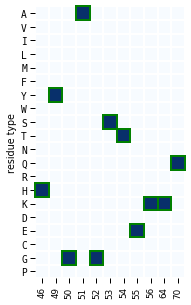

In [162]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_3mc0, 'X', ax, 
                                 key_residues=rsb.components.Selection('46X,49X,50X,51X,52X,53X,54X,55X,56X,64X,70X'),
                                 refseq=True, cbar=False, xrotation=90)

### 4jlr

#### Parse silent files resulting from sequence recovery design

In [163]:
description = {'sequence': 'X'}

bound_fixbb_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/4jlr/bound_fixbb_4jlr.silent', description)
unbound_fixbb_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/4jlr/unbound_fixbb_4jlr.silent', description)

bound_sses_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/4jlr/bound_surf_4jlr.silent', description)
unbound_sses_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/4jlr/unbound_surf_4jlr.silent', description)

bound_ssm_sses_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/4jlr/bound_surf_ssm_4jlr.silent', description)
unbound_ssm_sses_4jlr = rsb.io.parse_rosetta_file('./data/interface_recovery/4jlr/unbound_surf_ssm_4jlr.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [164]:
bound_sses_4jlr['sses'] = bound_sses_4jlr.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_4jlr['sses'] = bound_ssm_sses_4jlr.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_4jlr['sses'] = unbound_sses_4jlr.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_4jlr['sses'] = unbound_ssm_sses_4jlr.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [165]:
print('bound_fixbb_4jlr', bound_fixbb_4jlr.shape)
print('unbound_fixbb_4jlr', unbound_fixbb_4jlr.shape)
print('bound_sses_4jlr', bound_sses_4jlr.shape)
print('unbound_sses_4jlr', unbound_sses_4jlr.shape)
print('bound_ssm_sses_4jlr', bound_ssm_sses_4jlr.shape)
print('unbound_ssm_sses_4jlr', unbound_ssm_sses_4jlr.shape)

bound_fixbb_4jlr (5148, 27)
unbound_fixbb_4jlr (5148, 27)
bound_sses_4jlr (10269, 29)
unbound_sses_4jlr (5212, 29)
bound_ssm_sses_4jlr (5225, 29)
unbound_ssm_sses_4jlr (5212, 29)


#### Adding the reference sequences and interfaces residues of interest

In [166]:
bound_fixbb_4jlr.add_reference('X', 'SDMRKDAERRFDKFVEAAKNKFDKFKADMKKLARKEAEQARRAVRNRLSELLSKINDMPITNDQKKLMSNDVLKFAAEAEKKIEALAADAE', shift=221)
bound_fixbb_4jlr['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_4jlr, 'X', key_residues=rsb.components.Selection('269X,272X,273X,275X,276X,282X,283X,285X,286X,287X,289X,290X,293X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_4jlr.add_reference('X', 'SDMRKDAERRFDKFVEAAKNKFDKFKADMKKLARKEAEQARRAVRNRLSELLSKINDMPITNDQKKLMSNDVLKFAAEAEKKIEALAADAE', shift=221)
unbound_fixbb_4jlr['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_4jlr, 'X', key_residues=rsb.components.Selection('269X,272X,273X,275X,276X,282X,283X,285X,286X,287X,289X,290X,293X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_4jlr.add_reference('X', 'SDMRKDAERRFDKFVEAAKNKFDKFKADMKKLARKEAEQARRAVRNRLSELLSKINDMPITNDQKKLMSNDVLKFAAEAEKKIEALAADAE', shift=221)
bound_sses_4jlr['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_4jlr, 'X', key_residues=rsb.components.Selection('269X,272X,273X,275X,276X,282X,283X,285X,286X,287X,289X,290X,293X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_4jlr.add_reference('X', 'SDMRKDAERRFDKFVEAAKNKFDKFKADMKKLARKEAEQARRAVRNRLSELLSKINDMPITNDQKKLMSNDVLKFAAEAEKKIEALAADAE', shift=221)
unbound_sses_4jlr['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_4jlr, 'X', key_residues=rsb.components.Selection('269X,272X,273X,275X,276X,282X,283X,285X,286X,287X,289X,290X,293X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_4jlr.add_reference('X', 'SDMRKDAERRFDKFVEAAKNKFDKFKADMKKLARKEAEQARRAVRNRLSELLSKINDMPITNDQKKLMSNDVLKFAAEAEKKIEALAADAE', shift=221)
bound_ssm_sses_4jlr['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_4jlr, 'X', key_residues=rsb.components.Selection('269X,272X,273X,275X,276X,282X,283X,285X,286X,287X,289X,290X,293X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_4jlr.add_reference('X', 'SDMRKDAERRFDKFVEAAKNKFDKFKADMKKLARKEAEQARRAVRNRLSELLSKINDMPITNDQKKLMSNDVLKFAAEAEKKIEALAADAE', shift=221)
unbound_ssm_sses_4jlr['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_4jlr, 'X', key_residues=rsb.components.Selection('269X,272X,273X,275X,276X,282X,283X,285X,286X,287X,289X,290X,293X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [167]:
anot_bound_fixbb_4jlr = bound_fixbb_4jlr.sample(1000, random_state=42)
anot_unbound_fixbb_4jlr = unbound_fixbb_4jlr.sample(1000, random_state=42)
anot_bound_sses_4jlr = bound_sses_4jlr.sample(1000, random_state=42)
anot_unbound_sses_4jlr = unbound_sses_4jlr.sample(1000, random_state=42)
anot_bound_ssm_sses_4jlr = bound_ssm_sses_4jlr.sample(1000, random_state=42)
anot_unbound_ssm_sses_4jlr = unbound_ssm_sses_4jlr.sample(1000, random_state=42)


anot_bound_fixbb_4jlr = anot_bound_fixbb_4jlr.assign(protein='4jlr', variant='fixbb (bound)')
anot_unbound_fixbb_4jlr = anot_unbound_fixbb_4jlr.assign(protein='4jlr', variant='fixbb (unbound)')
anot_bound_sses_4jlr = anot_bound_sses_4jlr.assign(protein='4jlr', variant='sses (bound)')
anot_unbound_sses_4jlr = anot_unbound_sses_4jlr.assign(protein='4jlr', variant='sses (unbound)')
anot_bound_ssm_sses_4jlr = anot_bound_ssm_sses_4jlr.assign(protein='4jlr', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_4jlr = anot_unbound_ssm_sses_4jlr.assign(protein='4jlr', variant='ssm-sses (unbound)')


anot_4jlr = pd.concat([anot_bound_fixbb_4jlr, anot_unbound_fixbb_4jlr,
                       anot_bound_sses_4jlr, anot_unbound_sses_4jlr,
                       anot_bound_ssm_sses_4jlr, anot_unbound_ssm_sses_4jlr], sort=False)

mdf_4jlr = anot_4jlr.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 4JLR')

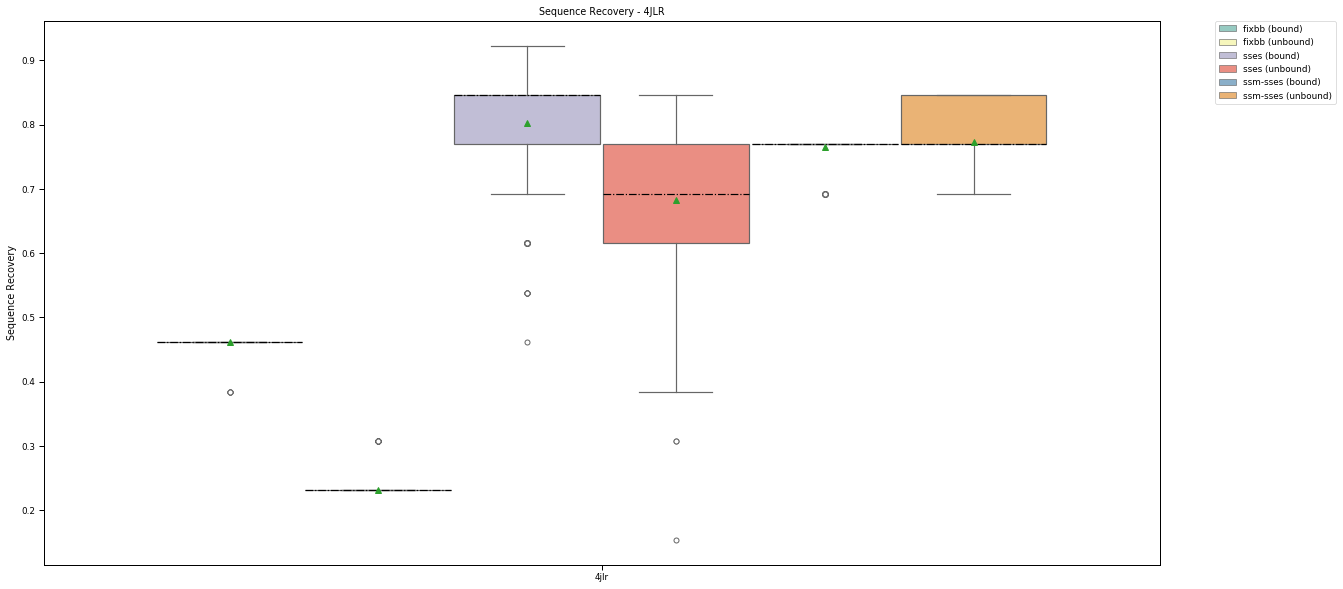

In [168]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_4jlr, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 4JLR')

#### Mean recovery rates for every sequence design method

In [169]:
print('anot_bound_fixbb_4jlr', anot_bound_fixbb_4jlr['seqrec'].mean())
print('anot_unbound_fixbb_4jlr', anot_unbound_fixbb_4jlr['seqrec'].mean())
print('anot_bound_sses_4jlr', anot_bound_sses_4jlr['seqrec'].mean())
print('anot_unbound_sses_4jlr', anot_unbound_sses_4jlr['seqrec'].mean())
print('anot_bound_ssm_sses_4jlr', anot_bound_ssm_sses_4jlr['seqrec'].mean())
print('anot_unbound_ssm_sses_4jlr', anot_unbound_ssm_sses_4jlr['seqrec'].mean())

anot_bound_fixbb_4jlr 0.46115384615384625
anot_unbound_fixbb_4jlr 0.2318461538461539
anot_bound_sses_4jlr 0.8019230769230772
anot_unbound_sses_4jlr 0.6826923076923076
anot_bound_ssm_sses_4jlr 0.7656923076923079
anot_unbound_ssm_sses_4jlr 0.7730769230769232


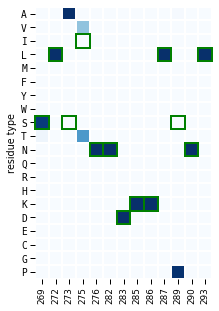

In [170]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_4jlr, 'X', ax, 
                                 key_residues=rsb.components.Selection('269X,272X,273X,275X,276X,282X,283X,285X,286X,287X,289X,290X,293X'),
                                 refseq=True, cbar=False, xrotation=90)

### 5jds

#### Parse silent files resulting from sequence recovery design

In [171]:
description = {'sequence': 'X'}

bound_fixbb_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/5jds/bound_fixbb_5jds.silent', description)
unbound_fixbb_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/5jds/unbound_fixbb_5jds.silent', description)

bound_sses_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/5jds/bound_surf_5jds.silent', description)
unbound_sses_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/5jds/unbound_surf_5jds.silent', description)

bound_ssm_sses_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/5jds/bound_surf_ssm_5jds.silent', description)
unbound_ssm_sses_5jds = rsb.io.parse_rosetta_file('./data/interface_recovery/5jds/unbound_surf_ssm_5jds.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [172]:
bound_sses_5jds['sses'] = bound_sses_5jds.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_5jds['sses'] = bound_ssm_sses_5jds.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_5jds['sses'] = unbound_sses_5jds.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_5jds['sses'] = unbound_ssm_sses_5jds.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [173]:
print('bound_fixbb_5jds', bound_fixbb_5jds.shape)
print('unbound_fixbb_5jds', unbound_fixbb_5jds.shape)
print('bound_sses_5jds', bound_sses_5jds.shape)
print('unbound_sses_5jds', unbound_sses_5jds.shape)
print('bound_ssm_sses_5jds', bound_ssm_sses_5jds.shape)
print('unbound_ssm_sses_5jds', unbound_ssm_sses_5jds.shape)

bound_fixbb_5jds (1144, 28)
unbound_fixbb_5jds (1144, 27)
bound_sses_5jds (10048, 29)
unbound_sses_5jds (8904, 29)
bound_ssm_sses_5jds (6655, 29)
unbound_ssm_sses_5jds (7517, 29)


#### Adding the reference sequences and interfaces residues of interest

In [174]:
bound_fixbb_5jds.add_reference('X', 'QVQLQESGGGLVQPGGSLRLSCAASGKMSSRRCMAWFRQAPGKERERVAKLLTTSGSTYLADSVKGRFTISQNNAKSTVYLQMNSLKPEDTAMYYCAADSFEDPTCTLVTSSGAFQYWGQGTQVTVS', shift=116)
bound_fixbb_5jds['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_5jds, 'X', key_residues=rsb.components.Selection('116X,142X,144X,145X,147X,214X,215X,216X,217X,219X,220X,223X,224X,226X,228X,229X,231X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_5jds.add_reference('X', 'QVQLQESGGGLVQPGGSLRLSCAASGKMSSRRCMAWFRQAPGKERERVAKLLTTSGSTYLADSVKGRFTISQNNAKSTVYLQMNSLKPEDTAMYYCAADSFEDPTCTLVTSSGAFQYWGQGTQVTVS', shift=116)
unbound_fixbb_5jds['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_5jds, 'X', key_residues=rsb.components.Selection('116X,142X,144X,145X,147X,214X,215X,216X,217X,219X,220X,223X,224X,226X,228X,229X,231X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_5jds.add_reference('X', 'QVQLQESGGGLVQPGGSLRLSCAASGKMSSRRCMAWFRQAPGKERERVAKLLTTSGSTYLADSVKGRFTISQNNAKSTVYLQMNSLKPEDTAMYYCAADSFEDPTCTLVTSSGAFQYWGQGTQVTVS', shift=116)
bound_sses_5jds['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_5jds, 'X', key_residues=rsb.components.Selection('116X,142X,144X,145X,147X,214X,215X,216X,217X,219X,220X,223X,224X,226X,228X,229X,231X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_5jds.add_reference('X', 'QVQLQESGGGLVQPGGSLRLSCAASGKMSSRRCMAWFRQAPGKERERVAKLLTTSGSTYLADSVKGRFTISQNNAKSTVYLQMNSLKPEDTAMYYCAADSFEDPTCTLVTSSGAFQYWGQGTQVTVS', shift=116)
unbound_sses_5jds['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_5jds, 'X', key_residues=rsb.components.Selection('116X,142X,144X,145X,147X,214X,215X,216X,217X,219X,220X,223X,224X,226X,228X,229X,231X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_5jds.add_reference('X', 'QVQLQESGGGLVQPGGSLRLSCAASGKMSSRRCMAWFRQAPGKERERVAKLLTTSGSTYLADSVKGRFTISQNNAKSTVYLQMNSLKPEDTAMYYCAADSFEDPTCTLVTSSGAFQYWGQGTQVTVS', shift=116)
bound_ssm_sses_5jds['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_5jds, 'X', key_residues=rsb.components.Selection('116X,142X,144X,145X,147X,214X,215X,216X,217X,219X,220X,223X,224X,226X,228X,229X,231X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_5jds.add_reference('X', 'QVQLQESGGGLVQPGGSLRLSCAASGKMSSRRCMAWFRQAPGKERERVAKLLTTSGSTYLADSVKGRFTISQNNAKSTVYLQMNSLKPEDTAMYYCAADSFEDPTCTLVTSSGAFQYWGQGTQVTVS', shift=116)
unbound_ssm_sses_5jds['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_5jds, 'X', key_residues=rsb.components.Selection('116X,142X,144X,145X,147X,214X,215X,216X,217X,219X,220X,223X,224X,226X,228X,229X,231X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [175]:
anot_bound_fixbb_5jds = bound_fixbb_5jds.sample(1000, random_state=42)
anot_unbound_fixbb_5jds = unbound_fixbb_5jds.sample(1000, random_state=42)
anot_bound_sses_5jds = bound_sses_5jds.sample(1000, random_state=42)
anot_unbound_sses_5jds = unbound_sses_5jds.sample(1000, random_state=42)
anot_bound_ssm_sses_5jds = bound_ssm_sses_5jds.sample(1000, random_state=42)
anot_unbound_ssm_sses_5jds = unbound_ssm_sses_5jds.sample(1000, random_state=42)


anot_bound_fixbb_5jds = anot_bound_fixbb_5jds.assign(protein='5jds', variant='fixbb (bound)')
anot_unbound_fixbb_5jds = anot_unbound_fixbb_5jds.assign(protein='5jds', variant='fixbb (unbound)')
anot_bound_sses_5jds = anot_bound_sses_5jds.assign(protein='5jds', variant='sses (bound)')
anot_unbound_sses_5jds = anot_unbound_sses_5jds.assign(protein='5jds', variant='sses (unbound)')
anot_bound_ssm_sses_5jds = anot_bound_ssm_sses_5jds.assign(protein='5jds', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_5jds = anot_unbound_ssm_sses_5jds.assign(protein='5jds', variant='ssm-sses (unbound)')


anot_5jds = pd.concat([anot_bound_fixbb_5jds, anot_unbound_fixbb_5jds,
                       anot_bound_sses_5jds, anot_unbound_sses_5jds,
                       anot_bound_ssm_sses_5jds, anot_unbound_ssm_sses_5jds], sort=False)

mdf_5jds = anot_5jds.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 5JDS')

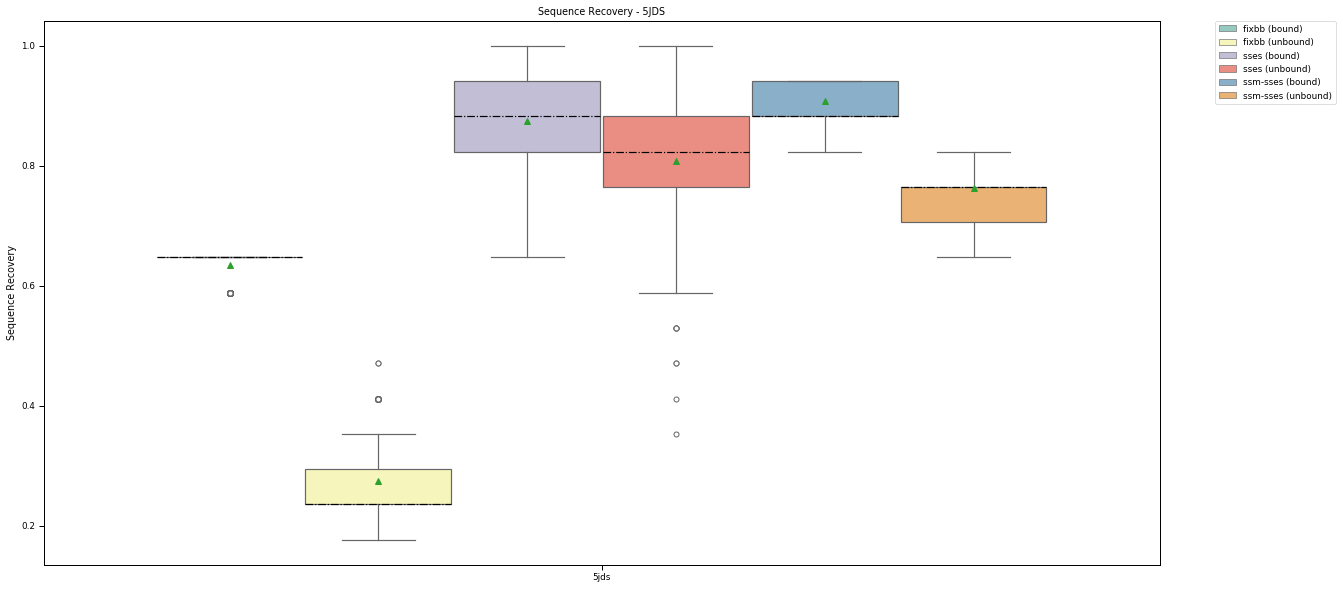

In [176]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_5jds, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 5JDS')

#### Mean recovery rates for every sequence design method

In [177]:
print('anot_bound_fixbb_5jds', anot_bound_fixbb_5jds['seqrec'].mean())
print('anot_unbound_fixbb_5jds', anot_unbound_fixbb_5jds['seqrec'].mean())
print('anot_bound_sses_5jds', anot_bound_sses_5jds['seqrec'].mean())
print('anot_unbound_sses_5jds', anot_unbound_sses_5jds['seqrec'].mean())
print('anot_bound_ssm_sses_5jds', anot_bound_ssm_sses_5jds['seqrec'].mean())
print('anot_unbound_ssm_sses_5jds', anot_unbound_ssm_sses_5jds['seqrec'].mean())

anot_bound_fixbb_5jds 0.6341176470588235
anot_unbound_fixbb_5jds 0.2747647058823529
anot_bound_sses_5jds 0.8747647058823531
anot_unbound_sses_5jds 0.8082941176470589
anot_bound_ssm_sses_5jds 0.9081764705882355
anot_unbound_ssm_sses_5jds 0.7622352941176471


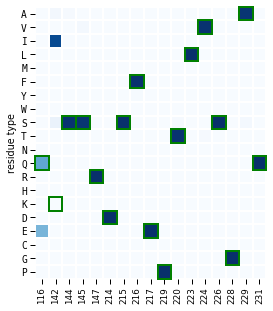

In [178]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_5jds, 'X', ax, 
                                 key_residues=rsb.components.Selection('116X,142X,144X,145X,147X,214X,215X,216X,217X,219X,220X,223X,224X,226X,228X,229X,231X'),
                                 refseq=True, cbar=False, xrotation=90)

### 6b9j

#### Parse silent files resulting from sequence recovery design

In [179]:
description = {'sequence': 'X'}

bound_fixbb_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/6b9j/bound_fixbb_6b9j.silent', description)
unbound_fixbb_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/6b9j/unbound_fixbb_6b9j.silent', description)

bound_sses_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/6b9j/bound_surf_6b9j.silent', description)
unbound_sses_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/6b9j/unbound_surf_6b9j.silent', description)

bound_ssm_sses_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/6b9j/bound_surf_ssm_6b9j.silent', description)
unbound_ssm_sses_6b9j = rsb.io.parse_rosetta_file('./data/interface_recovery/6b9j/unbound_surf_ssm_6b9j.silent', description)

#### Adding SSES score based on calcualted SS and ES scores

In [180]:
bound_sses_6b9j['sses'] = bound_sses_6b9j.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
bound_ssm_sses_6b9j['sses'] = bound_ssm_sses_6b9j.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)
unbound_sses_6b9j['sses'] = unbound_sses_6b9j.apply(lambda row: surf_score(row['si'], row['elec']),
                                                axis=1)
unbound_ssm_sses_6b9j['sses'] = unbound_ssm_sses_6b9j.apply(lambda row: surf_score(row['si'], row['elec']),
                                                     axis=1)

#### Number of resulting models

The number should be >1000, as we will sample 1000 random models from each dataset to have comparable sizes when we compare the sequence recovery rates

In [181]:
print('bound_fixbb_6b9j', bound_fixbb_6b9j.shape)
print('unbound_fixbb_6b9j', unbound_fixbb_6b9j.shape)
print('bound_sses_6b9j', bound_sses_6b9j.shape)
print('unbound_sses_6b9j', unbound_sses_6b9j.shape)
print('bound_ssm_sses_6b9j', bound_ssm_sses_6b9j.shape)
print('unbound_ssm_sses_6b9j', unbound_ssm_sses_6b9j.shape)

bound_fixbb_6b9j (5148, 27)
unbound_fixbb_6b9j (5148, 27)
bound_sses_6b9j (5349, 29)
unbound_sses_6b9j (8011, 29)
bound_ssm_sses_6b9j (5221, 29)
unbound_ssm_sses_6b9j (5258, 29)


In [182]:
print('bound_fixbb_6b9j', bound_fixbb_6b9j.shape)
print('unbound_fixbb_6b9j', unbound_fixbb_6b9j.shape)
print('bound_sses_6b9j', bound_sses_6b9j.shape)
print('unbound_sses_6b9j', unbound_sses_6b9j.shape)
print('bound_ssm_sses_6b9j', bound_ssm_sses_6b9j.shape)
print('unbound_ssm_sses_6b9j', unbound_ssm_sses_6b9j.shape)

bound_fixbb_6b9j (5148, 27)
unbound_fixbb_6b9j (5148, 27)
bound_sses_6b9j (5349, 29)
unbound_sses_6b9j (8011, 29)
bound_ssm_sses_6b9j (5221, 29)
unbound_ssm_sses_6b9j (5258, 29)


#### Adding the reference sequences and interfaces residues of interest

In [183]:
bound_fixbb_6b9j.add_reference('X', 'SKPTTIQNTGKLVRINFKGGYISGGFLPNEYVLSSLHIYWGKEQKIVNQLDSIRSANTSAPFDSVFYLDNLLPSKLDYFTYLGTTINHSADAVWIIFPTPINIHSDQLSKFRTLLSLHYIT', shift=157)
bound_fixbb_6b9j['seqrec'] = rsb.analysis.sequence_similarity(bound_fixbb_6b9j, 'X', key_residues=rsb.components.Selection('160X,161X,163X,165X,170X,172X,210X,211X,212X,213X,214X,215X,217X,271X'), matrix='IDENTITY',)['identity_X_perc']

unbound_fixbb_6b9j.add_reference('X', 'SKPTTIQNTGKLVRINFKGGYISGGFLPNEYVLSSLHIYWGKEQKIVNQLDSIRSANTSAPFDSVFYLDNLLPSKLDYFTYLGTTINHSADAVWIIFPTPINIHSDQLSKFRTLLSLHYIT', shift=157)
unbound_fixbb_6b9j['seqrec'] = rsb.analysis.sequence_similarity(unbound_fixbb_6b9j, 'X', key_residues=rsb.components.Selection('160X,161X,163X,165X,170X,172X,210X,211X,212X,213X,214X,215X,217X,271X'), matrix='IDENTITY',)['identity_X_perc']

bound_sses_6b9j.add_reference('X', 'SKPTTIQNTGKLVRINFKGGYISGGFLPNEYVLSSLHIYWGKEQKIVNQLDSIRSANTSAPFDSVFYLDNLLPSKLDYFTYLGTTINHSADAVWIIFPTPINIHSDQLSKFRTLLSLHYIT', shift=157)
bound_sses_6b9j['seqrec'] = rsb.analysis.sequence_similarity(bound_sses_6b9j, 'X', key_residues=rsb.components.Selection('160X,161X,163X,165X,170X,172X,210X,211X,212X,213X,214X,215X,217X,271X'), matrix='IDENTITY',)['identity_X_perc']

unbound_sses_6b9j.add_reference('X', 'SKPTTIQNTGKLVRINFKGGYISGGFLPNEYVLSSLHIYWGKEQKIVNQLDSIRSANTSAPFDSVFYLDNLLPSKLDYFTYLGTTINHSADAVWIIFPTPINIHSDQLSKFRTLLSLHYIT', shift=157)
unbound_sses_6b9j['seqrec'] = rsb.analysis.sequence_similarity(unbound_sses_6b9j, 'X', key_residues=rsb.components.Selection('160X,161X,163X,165X,170X,172X,210X,211X,212X,213X,214X,215X,217X,271X'), matrix='IDENTITY',)['identity_X_perc']

bound_ssm_sses_6b9j.add_reference('X', 'SKPTTIQNTGKLVRINFKGGYISGGFLPNEYVLSSLHIYWGKEQKIVNQLDSIRSANTSAPFDSVFYLDNLLPSKLDYFTYLGTTINHSADAVWIIFPTPINIHSDQLSKFRTLLSLHYIT', shift=157)
bound_ssm_sses_6b9j['seqrec'] = rsb.analysis.sequence_similarity(bound_ssm_sses_6b9j, 'X', key_residues=rsb.components.Selection('160X,161X,163X,165X,170X,172X,210X,211X,212X,213X,214X,215X,217X,271X'), matrix='IDENTITY',)['identity_X_perc']

unbound_ssm_sses_6b9j.add_reference('X', 'SKPTTIQNTGKLVRINFKGGYISGGFLPNEYVLSSLHIYWGKEQKIVNQLDSIRSANTSAPFDSVFYLDNLLPSKLDYFTYLGTTINHSADAVWIIFPTPINIHSDQLSKFRTLLSLHYIT', shift=157)
unbound_ssm_sses_6b9j['seqrec'] = rsb.analysis.sequence_similarity(unbound_ssm_sses_6b9j, 'X', key_residues=rsb.components.Selection('160X,161X,163X,165X,170X,172X,210X,211X,212X,213X,214X,215X,217X,271X'), matrix='IDENTITY',)['identity_X_perc']


#### Transformation of the data

We sample 1000 models from each dataset and annotate it with the protein PDB-ID and design variant. All proteins with the same PDB-ID are combined into a single data frame that is then altered to only contain the PDB-ID, design method, and sequence recovery rate.

In [184]:
anot_bound_fixbb_6b9j = bound_fixbb_6b9j.sample(1000, random_state=42)
anot_unbound_fixbb_6b9j = unbound_fixbb_6b9j.sample(1000, random_state=42)
anot_bound_sses_6b9j = bound_sses_6b9j.sample(1000, random_state=42)
anot_unbound_sses_6b9j = unbound_sses_6b9j.sample(1000, random_state=42)
anot_bound_ssm_sses_6b9j = bound_ssm_sses_6b9j.sample(1000, random_state=42)
anot_unbound_ssm_sses_6b9j = unbound_ssm_sses_6b9j.sample(1000, random_state=42)


anot_bound_fixbb_6b9j = anot_bound_fixbb_6b9j.assign(protein='6b9j', variant='fixbb (bound)')
anot_unbound_fixbb_6b9j = anot_unbound_fixbb_6b9j.assign(protein='6b9j', variant='fixbb (unbound)')
anot_bound_sses_6b9j = anot_bound_sses_6b9j.assign(protein='6b9j', variant='sses (bound)')
anot_unbound_sses_6b9j = anot_unbound_sses_6b9j.assign(protein='6b9j', variant='sses (unbound)')
anot_bound_ssm_sses_6b9j = anot_bound_ssm_sses_6b9j.assign(protein='6b9j', variant='ssm-sses (bound)')
anot_unbound_ssm_sses_6b9j = anot_unbound_ssm_sses_6b9j.assign(protein='6b9j', variant='ssm-sses (unbound)')


anot_6b9j = pd.concat([anot_bound_fixbb_6b9j, anot_unbound_fixbb_6b9j,
                       anot_bound_sses_6b9j, anot_unbound_sses_6b9j,
                       anot_bound_ssm_sses_6b9j, anot_unbound_ssm_sses_6b9j], sort=False)

mdf_6b9j = anot_6b9j.melt(id_vars=['protein', 'variant'], value_vars='seqrec')


Text(0.5, 1.0, 'Sequence Recovery - 6B9J')

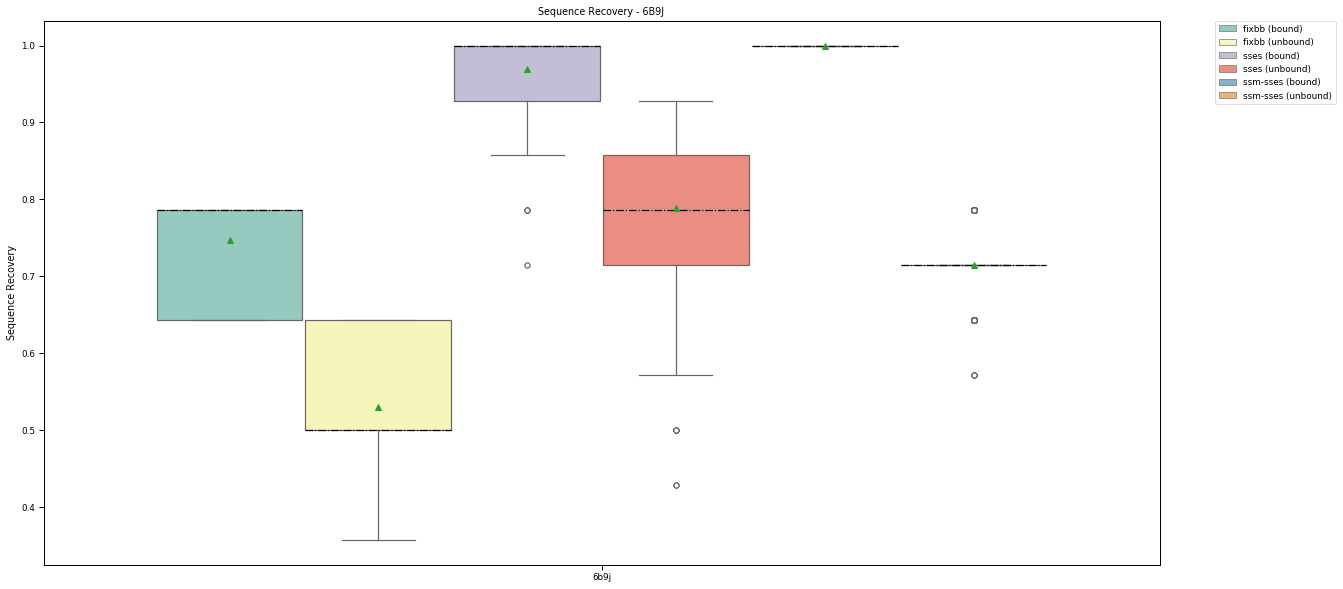

In [185]:
fig = plt.figure()
fig.set_size_inches(20, 10)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x="protein", y="value", hue="variant", data=mdf_6b9j, showmeans=True, palette="Set3",
                flierprops=flierprops, medianprops=medianprops)

plt.xlabel("")
plt.ylabel("Sequence Recovery")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - 6B9J')

#### Mean recovery rates for every sequence design method

In [186]:
print('anot_bound_fixbb_6b9j', anot_bound_fixbb_6b9j['seqrec'].mean())
print('anot_unbound_fixbb_6b9j', anot_unbound_fixbb_6b9j['seqrec'].mean())
print('anot_bound_sses_6b9j', anot_bound_sses_6b9j['seqrec'].mean())
print('anot_unbound_sses_6b9j', anot_unbound_sses_6b9j['seqrec'].mean())
print('anot_bound_ssm_sses_6b9j', anot_bound_ssm_sses_6b9j['seqrec'].mean())
print('anot_unbound_ssm_sses_6b9j', anot_unbound_ssm_sses_6b9j['seqrec'].mean())

anot_bound_fixbb_6b9j 0.7471428571428572
anot_unbound_fixbb_6b9j 0.5297857142857143
anot_bound_sses_6b9j 0.9698571428571429
anot_unbound_sses_6b9j 0.7888571428571429
anot_bound_ssm_sses_6b9j 1.0
anot_unbound_ssm_sses_6b9j 0.7149285714285714


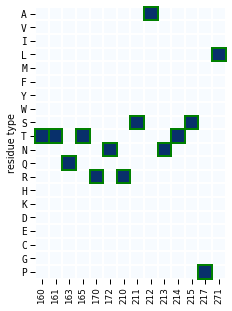

In [187]:
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(anot_bound_ssm_sses_6b9j, 'X', ax, 
                                 key_residues=rsb.components.Selection('160X,161X,163X,165X,170X,172X,210X,211X,212X,213X,214X,215X,217X,271X'),
                                 refseq=True, cbar=False, xrotation=90)

## Benchmark Analysis

### Pooling of data

In [188]:
all_designs = pd.concat([mdf_1dfj, mdf_1emv, mdf_1ppe, mdf_1rv6, mdf_3idx, mdf_3mc0, mdf_4jlr, mdf_5jds, mdf_6b9j])

all_bound_fixbb = all_designs[all_designs['variant'] == 'fixbb (bound)']
all_unbound_fixbb = all_designs[all_designs['variant'] == 'fixbb (unbound)']
low_bound_fixbb = all_designs[(all_designs['variant'] == 'fixbb (bound)') & (all_designs['protein'].isin(['3mc0', '1dfj', '1rv6']))]
low_unbound_fixbb = all_designs[(all_designs['variant'] == 'fixbb (unbound)') & (all_designs['protein'].isin(['3mc0', '1dfj', '1rv6']))]
high_bound_fixbb = all_designs[(all_designs['variant'] == 'fixbb (bound)') & (all_designs['protein'].isin(['1emv', '1ppe', '5jds']))]
high_unbound_fixbb = all_designs[(all_designs['variant'] == 'fixbb (unbound)') & (all_designs['protein'].isin(['1emv', '1ppe', '5jds']))]
ab_bound_fixbb = all_designs[(all_designs['variant'] == 'fixbb (bound)') & (all_designs['protein'].isin(['3idx', '4jlr', '6b9j']))]
ab_unbound_fixbb = all_designs[(all_designs['variant'] == 'fixbb (unbound)') & (all_designs['protein'].isin(['3idx', '4jlr', '6b9j']))]

all_bound_sses = all_designs[all_designs['variant'] == 'sses (bound)']
all_unbound_sses = all_designs[all_designs['variant'] == 'sses (unbound)']
low_bound_sses = all_designs[(all_designs['variant'] == 'sses (bound)') & (all_designs['protein'].isin(['3mc0', '1dfj', '1rv6']))]
low_unbound_sses = all_designs[(all_designs['variant'] == 'sses (unbound)') & (all_designs['protein'].isin(['3mc0', '1dfj', '1rv6']))]
high_bound_sses = all_designs[(all_designs['variant'] == 'sses (bound)') & (all_designs['protein'].isin(['1emv', '1ppe', '5jds']))]
high_unbound_sses = all_designs[(all_designs['variant'] == 'sses (unbound)') & (all_designs['protein'].isin(['1emv', '1ppe', '5jds']))]
ab_bound_sses = all_designs[(all_designs['variant'] == 'sses (bound)') & (all_designs['protein'].isin(['3idx', '4jlr', '6b9j']))]
ab_unbound_sses = all_designs[(all_designs['variant'] == 'sses (unbound)') & (all_designs['protein'].isin(['3idx', '4jlr', '6b9j']))]

all_bound_ssm_sses = all_designs[all_designs['variant'] == 'ssm-sses (bound)']
all_unbound_ssm_sses = all_designs[all_designs['variant'] == 'ssm-sses (unbound)']
low_bound_ssm_sses = all_designs[(all_designs['variant'] == 'ssm-sses (bound)') & (all_designs['protein'].isin(['3mc0', '1dfj', '1rv6']))]
low_unbound_ssm_sses = all_designs[(all_designs['variant'] == 'ssm-sses (unbound)') & (all_designs['protein'].isin(['3mc0', '1dfj', '1rv6']))]
high_bound_ssm_sses = all_designs[(all_designs['variant'] == 'ssm-sses (bound)') & (all_designs['protein'].isin(['1emv', '1ppe', '5jds']))]
high_unbound_ssm_sses = all_designs[(all_designs['variant'] == 'ssm-sses (unbound)') & (all_designs['protein'].isin(['1emv', '1ppe', '5jds']))]
ab_bound_ssm_sses = all_designs[(all_designs['variant'] == 'ssm-sses (bound)') & (all_designs['protein'].isin(['3idx', '4jlr', '6b9j']))]
ab_unbound_ssm_sses = all_designs[(all_designs['variant'] == 'ssm-sses (unbound)') & (all_designs['protein'].isin(['3idx', '4jlr', '6b9j']))]


In [189]:
all_bound = pd.concat([all_bound_fixbb, all_bound_sses, all_bound_ssm_sses])
all_unbound = pd.concat([all_unbound_fixbb, all_unbound_sses, all_unbound_ssm_sses])

low_bound = pd.concat([low_bound_fixbb, low_bound_sses, low_bound_ssm_sses])
low_unbound = pd.concat([low_unbound_fixbb, low_unbound_sses, low_unbound_ssm_sses])

high_bound = pd.concat([high_bound_fixbb, high_bound_sses, high_bound_ssm_sses])
high_unbound = pd.concat([high_unbound_fixbb, high_unbound_sses, high_unbound_ssm_sses])

ab_bound = pd.concat([ab_bound_fixbb, ab_bound_sses, ab_bound_ssm_sses])
ab_unbound = pd.concat([ab_unbound_fixbb, ab_unbound_sses, ab_unbound_ssm_sses])

In [190]:
relabel_all_bound_fixbb = all_bound_fixbb.assign(state='bound', variant='FixBB')
relabel_all_bound_sses = all_bound_sses.assign(state='bound', variant='RosettaSurf')
relabel_all_bound_ssm_sses = all_bound_ssm_sses.assign(state='bound', variant='RosettaSurf-site')
relabel_all_unbound_fixbb = all_unbound_fixbb.assign(state='unbound', variant='FixBB')
relabel_all_unbound_sses = all_unbound_sses.assign(state='unbound', variant='RosettaSurf')
relabel_all_unbound_ssm_sses = all_unbound_ssm_sses.assign(state='unbound', variant='RosettaSurf-site')
all_designs = pd.concat([relabel_all_bound_fixbb, relabel_all_bound_sses, relabel_all_bound_ssm_sses, relabel_all_unbound_fixbb, relabel_all_unbound_sses, relabel_all_unbound_ssm_sses])


all_designs_low = pd.concat([relabel_all_bound_fixbb[relabel_all_bound_fixbb['protein'].isin(['3mc0', '1dfj', '1rv6'])],
                             relabel_all_bound_sses[relabel_all_bound_sses['protein'].isin(['3mc0', '1dfj', '1rv6'])],
                             relabel_all_bound_ssm_sses[relabel_all_bound_ssm_sses['protein'].isin(['3mc0', '1dfj', '1rv6'])],
                             relabel_all_unbound_fixbb[relabel_all_unbound_fixbb['protein'].isin(['3mc0', '1dfj', '1rv6'])],
                             relabel_all_unbound_sses[relabel_all_unbound_sses['protein'].isin(['3mc0', '1dfj', '1rv6'])],
                             relabel_all_unbound_ssm_sses[relabel_all_unbound_ssm_sses['protein'].isin(['3mc0', '1dfj', '1rv6'])]])

all_designs_high = pd.concat([relabel_all_bound_fixbb[relabel_all_bound_fixbb['protein'].isin(['1emv', '1ppe', '5jds'])],
                             relabel_all_bound_sses[relabel_all_bound_sses['protein'].isin(['1emv', '1ppe', '5jds'])],
                             relabel_all_bound_ssm_sses[relabel_all_bound_ssm_sses['protein'].isin(['1emv', '1ppe', '5jds'])],
                             relabel_all_unbound_fixbb[relabel_all_unbound_fixbb['protein'].isin(['1emv', '1ppe', '5jds'])],
                             relabel_all_unbound_sses[relabel_all_unbound_sses['protein'].isin(['1emv', '1ppe', '5jds'])],
                             relabel_all_unbound_ssm_sses[relabel_all_unbound_ssm_sses['protein'].isin(['1emv', '1ppe', '5jds'])]])

all_designs_ab = pd.concat([relabel_all_bound_fixbb[relabel_all_bound_fixbb['protein'].isin(['3idx', '4jlr', '6b9j'])],
                             relabel_all_bound_sses[relabel_all_bound_sses['protein'].isin(['3idx', '4jlr', '6b9j'])],
                             relabel_all_bound_ssm_sses[relabel_all_bound_ssm_sses['protein'].isin(['3idx', '4jlr', '6b9j'])],
                             relabel_all_unbound_fixbb[relabel_all_unbound_fixbb['protein'].isin(['3idx', '4jlr', '6b9j'])],
                             relabel_all_unbound_sses[relabel_all_unbound_sses['protein'].isin(['3idx', '4jlr', '6b9j'])],
                             relabel_all_unbound_ssm_sses[relabel_all_unbound_ssm_sses['protein'].isin(['3idx', '4jlr', '6b9j'])]])



### Sequence Recovery

Text(0.5, 1.0, 'Sequence Recovery - All')

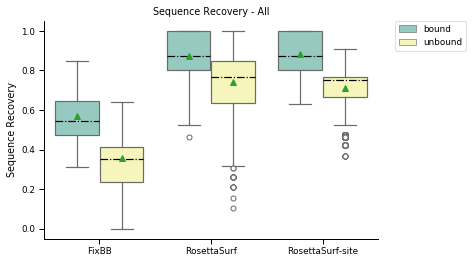

In [191]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 4)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.boxplot(x='variant', y='value', hue='state', data=all_designs, showmeans=True, palette='Set3',
                flierprops=flierprops, medianprops=medianprops)

sns.despine(top=True, right=True)
#ax.yaxis.grid(True)
plt.xlabel('')
plt.ylabel('Sequence Recovery')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sequence Recovery - All')

Text(0.5, 0.98, 'Sequence Recovery - Overview')

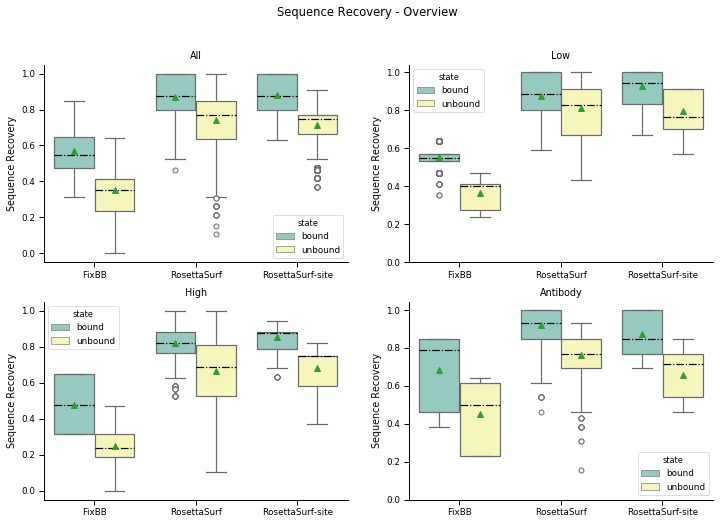

In [192]:
sns.set_context('paper')
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 8)
flierprops = dict(marker='o', markerfacecolor='white', linestyle='none')
medianprops = dict(linestyle='-.', color='black')

sns.boxplot(x='variant', y='value', hue='state', data=all_designs, showmeans=True, palette='Set3',
                flierprops=flierprops, medianprops=medianprops, ax=ax[0, 0], )

sns.boxplot(x='variant', y='value', hue='state', data=all_designs_low, showmeans=True, palette='Set3',
                flierprops=flierprops, medianprops=medianprops, ax=ax[0, 1])

sns.boxplot(x='variant', y='value', hue='state', data=all_designs_high, showmeans=True, palette='Set3',
                flierprops=flierprops, medianprops=medianprops, ax=ax[1, 0])

sns.boxplot(x='variant', y='value', hue='state', data=all_designs_ab, showmeans=True, palette='Set3',
                flierprops=flierprops, medianprops=medianprops, ax=ax[1, 1])

ax[0, 0].title.set_text('All')
ax[0, 1].title.set_text('Low')
ax[1, 0].title.set_text('High')
ax[1, 1].title.set_text('Antibody')

ax[0, 0].set_ylabel('Sequence Recovery')
ax[0, 1].set_ylabel('Sequence Recovery')
ax[1, 0].set_ylabel('Sequence Recovery')
ax[1, 1].set_ylabel('Sequence Recovery')

ax[0, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[1, 1].set_xlabel('')

ax[0, 0].set_yticks(np.arange(0, 1.2, 0.2))
ax[0, 1].set_yticks(np.arange(0, 1.2, 0.2))
ax[1, 0].set_yticks(np.arange(0, 1.2, 0.2))
ax[1, 1].set_yticks(np.arange(0, 1.2, 0.2))

sns.despine(top=True, right=True)

fig.suptitle('Sequence Recovery - Overview')

In [193]:
print('all_bound fixbb', round(all_bound[all_bound['variant'] == 'fixbb (bound)']['value'].mean(), ndigits=2))
print('all_unbound fixbb', round(all_unbound[all_unbound['variant'] == 'fixbb (unbound)']['value'].mean(), ndigits=2))
print('all_bound sses', round(all_bound[all_bound['variant'] == 'sses (bound)']['value'].mean(), ndigits=2))
print('all_unbound sses', round(all_unbound[all_unbound['variant'] == 'sses (unbound)']['value'].mean(), ndigits=2))
print('all_bound ssm-sses', round(all_bound[all_bound['variant'] == 'ssm-sses (bound)']['value'].mean(), ndigits=2))
print('all_unbound ssm-sses', round(all_unbound[all_unbound['variant'] == 'ssm-sses (unbound)']['value'].mean(), ndigits=2))


print('low_bound fixbb', round(low_bound[low_bound['variant'] == 'fixbb (bound)']['value'].mean(), ndigits=2))
print('low_unbound fixbb', round(low_unbound[low_unbound['variant'] == 'fixbb (unbound)']['value'].mean(), ndigits=2))
print('low_bound sses', round(low_bound[low_bound['variant'] == 'sses (bound)']['value'].mean(), ndigits=2))
print('low_unbound sses', round(low_unbound[low_unbound['variant'] == 'sses (unbound)']['value'].mean(), ndigits=2))
print('low_bound ssm-sses', round(low_bound[low_bound['variant'] == 'ssm-sses (bound)']['value'].mean(), ndigits=2))
print('low_unbound ssm-sses', round(low_unbound[low_unbound['variant'] == 'ssm-sses (unbound)']['value'].mean(), ndigits=2))

print('high_bound fixbb', round(high_bound[high_bound['variant'] == 'fixbb (bound)']['value'].mean(), ndigits=2))
print('high_unbound fixbb', round(high_unbound[high_unbound['variant'] == 'fixbb (unbound)']['value'].mean(), ndigits=2))
print('high_bound sses', round(high_bound[high_bound['variant'] == 'sses (bound)']['value'].mean(), ndigits=2))
print('high_unbound sses', round(high_unbound[high_unbound['variant'] == 'sses (unbound)']['value'].mean(), ndigits=2))
print('high_bound ssm-sses', round(high_bound[high_bound['variant'] == 'ssm-sses (bound)']['value'].mean(), ndigits=2))
print('high_unbound ssm-sses', round(high_unbound[high_unbound['variant'] == 'ssm-sses (unbound)']['value'].mean(), ndigits=2))

print('ab_bound fixbb', round(ab_bound[ab_bound['variant'] == 'fixbb (bound)']['value'].mean(), ndigits=2))
print('ab_unbound fixbb', round(ab_unbound[ab_unbound['variant'] == 'fixbb (unbound)']['value'].mean(), ndigits=2))
print('ab_bound sses', round(ab_bound[ab_bound['variant'] == 'sses (bound)']['value'].mean(), ndigits=2))
print('ab_unbound sses', round(ab_unbound[ab_unbound['variant'] == 'sses (unbound)']['value'].mean(), ndigits=2))
print('ab_bound ssm-sses', round(ab_bound[ab_bound['variant'] == 'ssm-sses (bound)']['value'].mean(), ndigits=2))
print('ab_unbound ssm-sses', round(ab_unbound[ab_unbound['variant'] == 'ssm-sses (unbound)']['value'].mean(), ndigits=2))


all_bound fixbb 0.57
all_unbound fixbb 0.35
all_bound sses 0.87
all_unbound sses 0.74
all_bound ssm-sses 0.88
all_unbound ssm-sses 0.71
low_bound fixbb 0.55
low_unbound fixbb 0.36
low_bound sses 0.88
low_unbound sses 0.81
low_bound ssm-sses 0.92
low_unbound ssm-sses 0.8
high_bound fixbb 0.48
high_unbound fixbb 0.25
high_bound sses 0.82
high_unbound sses 0.66
high_bound ssm-sses 0.85
high_unbound ssm-sses 0.68
ab_bound fixbb 0.68
ab_unbound fixbb 0.45
ab_bound sses 0.92
ab_unbound sses 0.76
ab_bound ssm-sses 0.87
ab_unbound ssm-sses 0.66


### Sequence Diversity

In [194]:
proteins = ['1dfj', '1emv', '1ppe', '1rv6', '3idx', '3mc0', '4jlr', '5jds', '6b9j']
variants = ['fixbb (bound)', 'fixbb (unbound)', 'sses (bound)', 'sses (unbound)', 'ssm-sses (bound)', 'ssm-sses (unbound)']

combinations = itertools.product(proteins, variants)

In [195]:
seq_diversity = {}
for comb in combinations:
    comb = list(comb)
    if comb[0] == '1dfj':
        seq_diversity.update({'_'.join(comb): len(set(anot_1dfj[anot_1dfj['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '1emv':
        seq_diversity.update({'_'.join(comb): len(set(anot_1emv[anot_1emv['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '1ppe':
        seq_diversity.update({'_'.join(comb): len(set(anot_1ppe[anot_1ppe['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '1rv6':
        seq_diversity.update({'_'.join(comb): len(set(anot_1rv6[anot_1rv6['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '3idx':
        seq_diversity.update({'_'.join(comb): len(set(anot_3idx[anot_3idx['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '3mc0':
        seq_diversity.update({'_'.join(comb): len(set(anot_3mc0[anot_3mc0['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '4jlr':
        seq_diversity.update({'_'.join(comb): len(set(anot_4jlr[anot_4jlr['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '5jds':
        seq_diversity.update({'_'.join(comb): len(set(anot_5jds[anot_5jds['variant'] == comb[1]]['sequence_X']))})
    elif comb[0] == '6b9j':
        seq_diversity.update({'_'.join(comb): len(set(anot_6b9j[anot_6b9j['variant'] == comb[1]]['sequence_X']))})
        

In [196]:
sequence_diversity = pd.DataFrame.from_dict(seq_diversity, orient='index')
sequence_diversity['variants'] = sequence_diversity.index


[Text(0, 0, '1dfj_fixbb (bound)'),
 Text(0, 0, '1dfj_fixbb (unbound)'),
 Text(0, 0, '1dfj_sses (bound)'),
 Text(0, 0, '1dfj_sses (unbound)'),
 Text(0, 0, '1dfj_ssm-sses (bound)'),
 Text(0, 0, '1dfj_ssm-sses (unbound)'),
 Text(0, 0, '1emv_fixbb (bound)'),
 Text(0, 0, '1emv_fixbb (unbound)'),
 Text(0, 0, '1emv_sses (bound)'),
 Text(0, 0, '1emv_sses (unbound)'),
 Text(0, 0, '1emv_ssm-sses (bound)'),
 Text(0, 0, '1emv_ssm-sses (unbound)'),
 Text(0, 0, '1ppe_fixbb (bound)'),
 Text(0, 0, '1ppe_fixbb (unbound)'),
 Text(0, 0, '1ppe_sses (bound)'),
 Text(0, 0, '1ppe_sses (unbound)'),
 Text(0, 0, '1ppe_ssm-sses (bound)'),
 Text(0, 0, '1ppe_ssm-sses (unbound)'),
 Text(0, 0, '1rv6_fixbb (bound)'),
 Text(0, 0, '1rv6_fixbb (unbound)'),
 Text(0, 0, '1rv6_sses (bound)'),
 Text(0, 0, '1rv6_sses (unbound)'),
 Text(0, 0, '1rv6_ssm-sses (bound)'),
 Text(0, 0, '1rv6_ssm-sses (unbound)'),
 Text(0, 0, '3idx_fixbb (bound)'),
 Text(0, 0, '3idx_fixbb (unbound)'),
 Text(0, 0, '3idx_sses (bound)'),
 Text(0, 0, '3

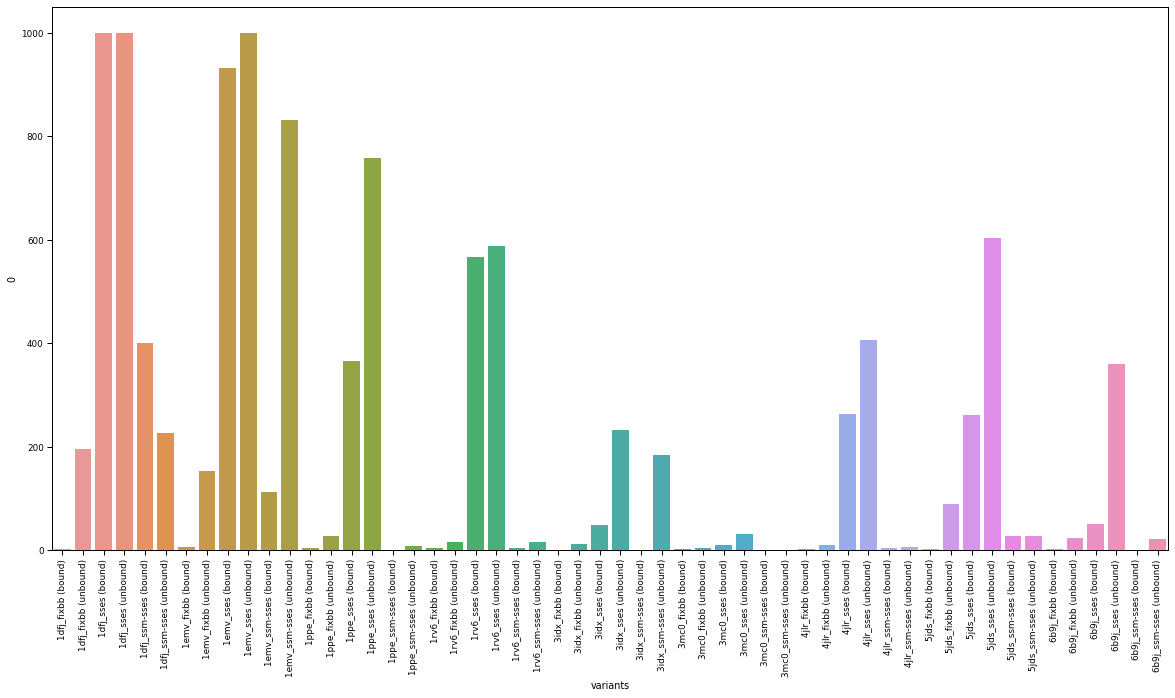

In [197]:
fig = plt.figure()
fig.set_size_inches(20, 10)

ax = sns.barplot(x='variants', y=0, data=sequence_diversity)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Outlier case studies

#### Unbound SSES decoys

Collect all SSES decoys from the unbound benchmark

In [198]:
tmp_1dfj = anot_1dfj[anot_1dfj['variant'] == 'sses (unbound)']
tmp_1dfj.delete_reference('X')
tmp_1emv = anot_1emv[anot_1emv['variant'] == 'sses (unbound)']
tmp_1emv.delete_reference('X')
tmp_1ppe = anot_1ppe[anot_1ppe['variant'] == 'sses (unbound)']
tmp_1ppe.delete_reference('X')
tmp_1rv6 = anot_1rv6[anot_1rv6['variant'] == 'sses (unbound)']
tmp_1rv6.delete_reference('X')
tmp_3idx = anot_3idx[anot_3idx['variant'] == 'sses (unbound)']
tmp_3idx.delete_reference('X')
tmp_3mc0 = anot_3mc0[anot_3mc0['variant'] == 'sses (unbound)']
tmp_3mc0.delete_reference('X')
tmp_4jlr = anot_4jlr[anot_4jlr['variant'] == 'sses (unbound)']
tmp_4jlr.delete_reference('X')
tmp_5jds = anot_5jds[anot_5jds['variant'] == 'sses (unbound)']
tmp_5jds.delete_reference('X')
tmp_6b9j = anot_6b9j[anot_6b9j['variant'] == 'sses (unbound)']
tmp_6b9j.delete_reference('X')

tmp_sses_unbound = pd.concat([tmp_1dfj, tmp_1emv, tmp_1ppe, tmp_1rv6, tmp_3idx, tmp_3mc0, tmp_4jlr, tmp_5jds, tmp_6b9j])

/Users/andi/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Show their distribution of low and high sequence recovery decoys depending on their surface score

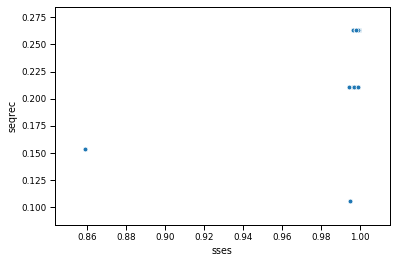

In [199]:
sns.scatterplot(x='sses', y='seqrec', data=tmp_sses_unbound[tmp_sses_unbound['seqrec'] <= 0.3])

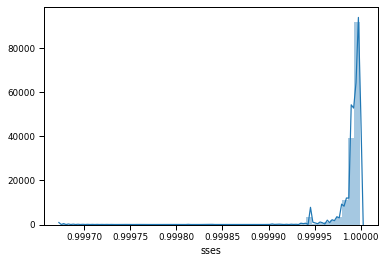

In [200]:
sns.distplot(tmp_sses_unbound[tmp_sses_unbound['seqrec'] >= 0.7]['sses'])

In [201]:
tmp_sses_unbound[tmp_sses_unbound['seqrec'] >= 0.7]['sses'].sort_values()

5087    0.999676
2834    0.999785
1769    0.999812
4925    0.999840
1235    0.999853
          ...   
4224    0.999999
2314    0.999999
315     0.999999
3773    0.999999
1158    0.999999
Name: sses, Length: 5691, dtype: float64

We can see that high sequence recovery structures (here >= 70%) have at least a surface score of 0.9996. Therefore we will consider this the threshold of surface scores that one would expect for decoys with high sequence recovery. We will now look specfically at decoys that have a high surface score (>= 0.9996) but low sequence recovery (<= 0.3).

In [202]:
key_res_1dfj = [4,7,11,12,23,24,27,28,31,32,37,38,39,41,42,43,66,67,68,69,71,86,87,88,89,91,109,111,118,119]
key_res_1emv = [134,137,138,154,155,156,157,158,160,161,164,166,167,169,171,172,175,180,181]
key_res_1ppe = [223,224,226,227,228,229,230,231,239,240,241,245,246,247,249,251]
key_res_1rv6 = [198,199,200,202,204,228,229,230,231,256,259,260,261,276,278,280,281]
key_res_3idx = [424,425,426,427,428,429,430,431,442,466,468,473,520]
key_res_3mc0 = [46,49,50,51,52,53,54,55,56,64,70]
key_res_4jlr = [269,272,273,275,276,282,283,285,286,287,289,290,293]
key_res_5jds = [116,142,144,145,147,214,215,216,217,219,220,223,224,226,228,229,231]
key_res_6b9j = [160,161,163,165,170,172,210,211,212,213,214,215,217,271]

In [203]:
unbound_datasets = [
    #[anot_unbound_sses_1dfj, key_res_1dfj],
    [anot_unbound_sses_1emv, key_res_1emv],
    #[anot_unbound_sses_1ppe, key_res_1ppe],
    #[anot_unbound_sses_1rv6, key_res_1rv6],
    #[anot_unbound_sses_3idx, key_res_3idx],
    #[anot_unbound_sses_3mc0, key_res_3mc0],
    #[anot_unbound_sses_4jlr, key_res_4jlr],
    #[anot_unbound_sses_5jds, key_res_5jds],
    #[anot_unbound_sses_6b9j, key_res_6b9j],
]

In [204]:
print(len(anot_unbound_sses_1emv[(anot_unbound_sses_1emv['seqrec'] <= 0.3) & (anot_unbound_sses_1emv['sses'] >= 0.9996)]))

4


In [205]:
# create an empty dataframe all all vs all amino acids where the index will be the native amino acid and the columns represent for which amino acids the native was mistaken
all_aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
mismatch_freq_unbound_df = pd.DataFrame(index=all_aas, columns=all_aas+['counter']).fillna(float(0))

for complex in unbound_datasets:
    df = complex[0]
    # we only consider designs that had low sequence recevory but still high surface scores
    df = df[(df['seqrec'] <= 0.3) & (df['sses'] >= 0.9996)]
    if not df.empty:
        seq_freq = rsb.analysis.sequential_frequencies(df, seqID='X')
        for i in complex[1]:
            # adjust the key residues for shift
            i -= df.get_reference_shift('X')
            true_aa = df.get_reference_sequence('X')[i]
            # iterate each row, i.e., each amino acid position
            for j in range(0, 20):
                mismatch_freq_unbound_df.loc[true_aa][seq_freq.iloc[:, j].name] += seq_freq.iloc[i, j]
            # keep track of how often we add values to a row so we can normalize later on
            mismatch_freq_unbound_df.loc[true_aa]['counter'] += 1

In [206]:
# normalize the frequencies based on how often we added new values to the row
for s in mismatch_freq_unbound_df.index:
    mismatch_freq_unbound_df.loc[s] = mismatch_freq_unbound_df.loc[s].div(mismatch_freq_unbound_df.loc[s]['counter'])

# drop all rows that were never altered
mismatch_freq_unbound_df = mismatch_freq_unbound_df.drop(columns='counter').dropna()

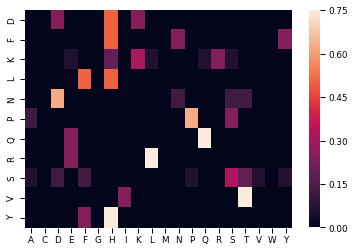

In [207]:
sns.heatmap(mismatch_freq_unbound_df)

In [208]:
for s in mismatch_freq_unbound_df.index:
    print(mismatch_freq_unbound_df.loc[s].sort_values().tail(2))

D    0.25
H    0.50
Name: D, dtype: float64
Y    0.25
H    0.50
Name: F, dtype: float64
R    0.2500
K    0.3125
Name: K, dtype: float64
H    0.5
F    0.5
Name: L, dtype: float64
T    0.125
D    0.625
Name: N, dtype: float64
S    0.250
P    0.625
Name: P, dtype: float64
E    0.25
Q    0.75
Name: Q, dtype: float64
E    0.25
L    0.75
Name: R, dtype: float64
T    0.1875
S    0.3125
Name: S, dtype: float64
I    0.25
T    0.75
Name: V, dtype: float64
F    0.25
H    0.75
Name: Y, dtype: float64


In [209]:
mismatch_freq_unbound_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
D,0.0000,0.0,0.250,0.0000,0.000,0.0,0.5000,0.00,0.2500,0.0000,0.0,0.000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.0000
F,0.0000,0.0,0.000,0.0000,0.000,0.0,0.5000,0.00,0.0000,0.0000,0.0,0.250,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.2500
K,0.0000,0.0,0.000,0.0625,0.000,0.0,0.1875,0.00,0.3125,0.0625,0.0,0.000,0.0000,0.0625,0.25,0.0625,0.0000,0.0000,0.0,0.0000
L,0.0000,0.0,0.000,0.0000,0.500,0.0,0.5000,0.00,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.0000
N,0.0000,0.0,0.625,0.0000,0.000,0.0,0.0000,0.00,0.0000,0.0000,0.0,0.125,0.0000,0.0000,0.00,0.1250,0.1250,0.0000,0.0,0.0000
P,0.1250,0.0,0.000,0.0000,0.000,0.0,0.0000,0.00,0.0000,0.0000,0.0,0.000,0.6250,0.0000,0.00,0.2500,0.0000,0.0000,0.0,0.0000
Q,0.0000,0.0,0.000,0.2500,0.000,0.0,0.0000,0.00,0.0000,0.0000,0.0,0.000,0.0000,0.7500,0.00,0.0000,0.0000,0.0000,0.0,0.0000
R,0.0000,0.0,0.000,0.2500,0.000,0.0,0.0000,0.00,0.0000,0.7500,0.0,0.000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.0000
S,0.0625,0.0,0.125,0.0000,0.125,0.0,0.0000,0.00,0.0000,0.0000,0.0,0.000,0.0625,0.0000,0.00,0.3125,0.1875,0.0625,0.0,0.0625
V,0.0000,0.0,0.000,0.0000,0.000,0.0,0.0000,0.25,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.00,0.0000,0.7500,0.0000,0.0,0.0000


#### Bound SSES decoys

Collect all SSES decoys from the bound benchmark

In [210]:
tmp_1dfj = anot_1dfj[anot_1dfj['variant'] == 'sses (bound)']
tmp_1dfj.delete_reference('X')
tmp_1emv = anot_1emv[anot_1emv['variant'] == 'sses (bound)']
tmp_1emv.delete_reference('X')
tmp_1ppe = anot_1ppe[anot_1ppe['variant'] == 'sses (bound)']
tmp_1ppe.delete_reference('X')
tmp_1rv6 = anot_1rv6[anot_1rv6['variant'] == 'sses (bound)']
tmp_1rv6.delete_reference('X')
tmp_3idx = anot_3idx[anot_3idx['variant'] == 'sses (bound)']
tmp_3idx.delete_reference('X')
tmp_3mc0 = anot_3mc0[anot_3mc0['variant'] == 'sses (bound)']
tmp_3mc0.delete_reference('X')
tmp_4jlr = anot_4jlr[anot_4jlr['variant'] == 'sses (bound)']
tmp_4jlr.delete_reference('X')
tmp_5jds = anot_5jds[anot_5jds['variant'] == 'sses (bound)']
tmp_5jds.delete_reference('X')
tmp_6b9j = anot_6b9j[anot_6b9j['variant'] == 'sses (bound)']
tmp_6b9j.delete_reference('X')

tmp_sses_bound = pd.concat([tmp_1dfj, tmp_1emv, tmp_1ppe, tmp_1rv6, tmp_3idx, tmp_3mc0, tmp_4jlr, tmp_5jds, tmp_6b9j])

/Users/andi/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Show their distribution of low and high sequence recovery decoys depending on their surface score

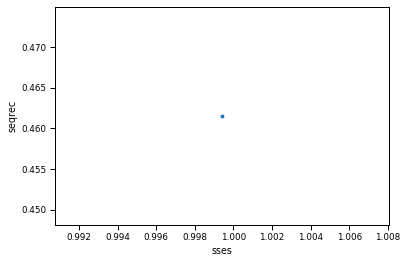

In [211]:
sns.scatterplot(x='sses', y='seqrec', data=tmp_sses_bound[tmp_sses_bound['seqrec'] <= 0.5])

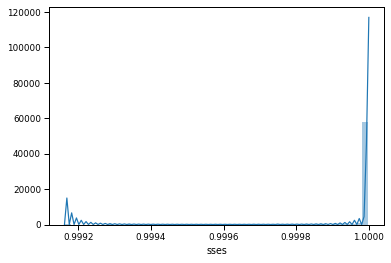

In [212]:
sns.distplot(tmp_sses_bound[tmp_sses_bound['seqrec'] >= 0.7]['sses'])

In [213]:
tmp_sses_bound[tmp_sses_bound['seqrec'] >= 0.7]['sses'].sort_values()

5225    0.999163
6224    0.999296
1730    0.999335
5368    0.999575
3971    0.999589
          ...   
4149    0.999999
5268    0.999999
655     0.999999
272     0.999999
1034    0.999999
Name: sses, Length: 8454, dtype: float64

We can see that high sequence recovery structures (here >= 70%) have at least a surface score of 0.9993. Therefore we will consider this the threshold of surface scores that one would expect for decoys with high sequence recovery. We will now look specfically at decoys that have a high surface score (>= 0.9992) but low sequence recovery (<= 0.5).

In [214]:
key_res_1dfj = [4,7,11,12,23,24,27,28,31,32,37,38,39,41,42,43,66,67,68,69,71,86,87,88,89,91,109,111,118,119]
key_res_1emv = [134,137,138,154,155,156,157,158,160,161,164,166,167,169,171,172,175,180,181]
key_res_1ppe = [223,224,226,227,228,229,230,231,239,240,241,245,246,247,249,251]
key_res_1rv6 = [198,199,200,202,204,228,229,230,231,256,259,260,261,276,278,280,281]
key_res_3idx = [424,425,426,427,428,429,430,431,442,466,468,473,520]
key_res_3mc0 = [46,49,50,51,52,53,54,55,56,64,70]
key_res_4jlr = [269,272,273,275,276,282,283,285,286,287,289,290,293]
key_res_5jds = [116,142,144,145,147,214,215,216,217,219,220,223,224,226,228,229,231]
key_res_6b9j = [160,161,163,165,170,172,210,211,212,213,214,215,217,271]

In [215]:
bound_datasets = [
    #[anot_bound_sses_1dfj, key_res_1dfj],
    #[anot_bound_sses_1emv, key_res_1emv],
    #[anot_bound_sses_1ppe, key_res_1ppe],
    #[anot_bound_sses_1rv6, key_res_1rv6],
    #[anot_bound_sses_3idx, key_res_3idx],
    #[anot_bound_sses_3mc0, key_res_3mc0],
    [anot_bound_sses_4jlr, key_res_4jlr],
    #[anot_bound_sses_5jds, key_res_5jds],
    #[anot_bound_sses_6b9j, key_res_6b9j],
]

In [216]:
print(len(anot_bound_sses_4jlr[(anot_bound_sses_4jlr['seqrec'] <= 0.5) & (anot_bound_sses_4jlr['sses'] >= 0.9992)]))

1


In [217]:
# create an empty dataframe all all vs all amino acids where the index will be the native amino acid and the columns represent for which amino acids the native was mistaken
all_aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
mismatch_freq_bound_df = pd.DataFrame(index=all_aas, columns=all_aas+['counter']).fillna(float(0))

for complex in bound_datasets:
    df = complex[0]
    # we only consider designs that had low sequence recevory but still high surface scores
    df = df[(df['seqrec'] <= 0.5) & (df['sses'] >= 0.9992)]
    if not df.empty:
        seq_freq = rsb.analysis.sequential_frequencies(df, seqID='X')
        for i in complex[1]:
            # adjust the key residues for shift
            i -= df.get_reference_shift('X')
            true_aa = df.get_reference_sequence('X')[i]
            # iterate each row, i.e., each amino acid position
            for j in range(0, 20):
                mismatch_freq_bound_df.loc[true_aa][seq_freq.iloc[:, j].name] += seq_freq.iloc[i, j]
            # keep track of how often we add values to a row so we can normalize later on
            mismatch_freq_bound_df.loc[true_aa]['counter'] += 1

In [218]:
# normalize the frequencies based on how often we added new values to the row
for s in mismatch_freq_bound_df.index:
    mismatch_freq_bound_df.loc[s] = mismatch_freq_bound_df.loc[s].div(mismatch_freq_bound_df.loc[s]['counter'])

# drop all rows that were never altered
mismatch_freq_bound_df = mismatch_freq_bound_df.drop(columns='counter').dropna()

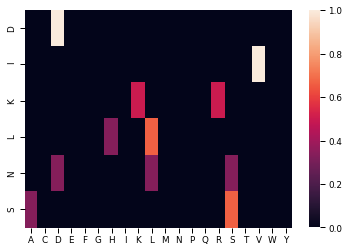

In [219]:
sns.heatmap(mismatch_freq_bound_df)

In [220]:
for s in mismatch_freq_bound_df.index:
    print(mismatch_freq_bound_df.loc[s].sort_values().tail(2))

Y    0.0
D    1.0
Name: D, dtype: float64
Y    0.0
V    1.0
Name: I, dtype: float64
R    0.5
K    0.5
Name: K, dtype: float64
H    0.333333
L    0.666667
Name: L, dtype: float64
D    0.333333
L    0.333333
Name: N, dtype: float64
A    0.333333
S    0.666667
Name: S, dtype: float64


In [221]:
mismatch_freq_bound_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
D,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
I,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0
K,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0
L,0.000000,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
N,0.000000,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
S,0.333333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0


# Computational SSM Screening to Improve Protein Binding


## Il-15/2 SSM Library Benchmark

In [222]:
il15_8 = rsb.io.parse_rosetta_file('./data/interleukin_benchmark/il_pos_8.sc')
il15_14 = rsb.io.parse_rosetta_file('./data/interleukin_benchmark/il_pos_14.sc')
il15_32 = rsb.io.parse_rosetta_file('./data/interleukin_benchmark/il_pos_32.sc')
il15_36 = rsb.io.parse_rosetta_file('./data/interleukin_benchmark/il_pos_36.sc')
il15_91 = rsb.io.parse_rosetta_file('./data/interleukin_benchmark/il_pos_91.sc')

In [223]:
il15 = pd.concat([il15_8, il15_14, il15_32, il15_36, il15_91])

## Select top 4 residues by REU
Selecting the top 4 unique residues based on Rosetta energy for each sampled interface positions (8, 14, 32, 36, and 91). Below, the best 5 positions are shown to confirm that no amino acids have identical scores. 

EPR refers to energy per residue.

In [224]:
for i in [8, 14, 32, 36, 91]:
    print(i)
    display(il15[il15['description'].str.contains('{}A'.format(i))][[x for x in il15.columns if x.startswith('epr_')]].T.sort_values(by=0, ascending=True).head(5))

8


,0
epr_asn,-3.014
epr_arg,-3.003
epr_ile,-2.825
epr_asp,-2.697
epr_glu,-2.623


14


,0
epr_ala,-1.425
epr_asn,-0.360
epr_ser,-0.358
epr_glu,-0.155
epr_gly,0.025


32


,0
epr_lys,-1.513
epr_ser,-1.455
epr_asn,-1.279
epr_glu,-1.081
epr_asp,-1.033


36


,0
epr_asn,-2.264
epr_asp,-1.932
epr_tyr,-1.691
epr_ser,-1.639
epr_gln,-1.468


91


,0
epr_ile,-2.963
epr_val,-2.166
epr_thr,-1.498
epr_asn,-1.237
epr_ser,-0.830


## Select top 4 residues by RosettaSurf-site
Selecting the top 4 unique residues using RosettaSurf-site for each sampled interface positions (8, 14, 32, 36, and 91). Below, the best 5 positions are shown to confirm that no amino acids have identical scores. 

SC refers to shape complementarity which is used as selection criterion during RosettaSurf-site sampling.

In [225]:
for i in [8, 14, 32, 36, 91]:
    print(i)
    display(il15[il15['description'].str.contains('{}A'.format(i))][[x for x in il15.columns if x.startswith('sc_')]].T.sort_values(by=0, ascending=False).head(5))

8


,0
sc_phe,0.501
sc_tyr,0.499
sc_asn,0.488
sc_his,0.488
sc_trp,0.487


14


,0
sc_tyr,0.500
sc_phe,0.496
sc_leu,0.483
sc_arg,0.478
sc_trp,0.477


32


,0
sc_gly,0.471
sc_ala,0.470
sc_trp,0.470
sc_ser,0.470
sc_arg,0.470


36


,0
sc_glu,0.531
sc_gln,0.529
sc_met,0.518
sc_leu,0.517
sc_phe,0.506


91


,0
sc_ile,0.544
sc_val,0.532
sc_thr,0.525
sc_arg,0.520
sc_his,0.519


# Surface-centric Design of a Novel RSV Site 0 Immunogen

In [226]:
rules = {'sequence': 'B'}
d25_3ezib_designs = rsb.io.parse_rosetta_file('./data/rsv_site_0_design/d25_rosetta_surf.silent', rules)

In [227]:
d25_3ezib_designs['sses'] = d25_3ezib_designs.apply(lambda row: surf_score(row['si'], row['elec']), axis=1)

## Selection of lead design
The design with the best surface score, `3ezib_design_complex_6870947_322_0002`, was selected.

For a subsequent point mutation the best 20 designs according to the surface score were selected to identify the most abundant residue type to be chosen for the point mutant.

In [228]:
d25_3ezib_designs.sort_values(by='sses', ascending=False).head(20)[['description', 'sses']]

,description,sses
346,3ezib_design_complex_6870947_322_0002,0.705645
159,3ezib_design_complex_6870947_195_0002,0.689308
315,3ezib_design_complex_6870947_304_0001,0.673183
675,3ezib_design_complex_6870947_491_0002,0.665944
133,3ezib_design_complex_6870947_180_0002,0.662472
289,3ezib_design_complex_6870947_289_0002,0.662089
392,3ezib_design_complex_6870947_346_0001,0.656860
640,3ezib_design_complex_6870947_473_0002,0.651008
191,3ezib_design_complex_6870947_211_0001,0.647674
322,3ezib_design_complex_6870947_309_0001,0.647493


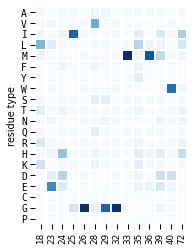

In [229]:
fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(d25_3ezib_designs.sort_values(by='sses', ascending=False).head(20), 'B', ax, refseq=False, cbar=False, xrotation=90,
                                key_residues=rsb.components.Selection('18B,23B-26B,28B,29B,32B,33B,35B,36B,39B,40B,72B'))


## Rosetta Control
Modelling of designs for comparison to the surface-designed scaffold. We used FixBB to generate an alterantive design based on the same scaffold.

In [230]:
rules = {'sequence': 'B'}
d25_3ezib_rosetta_designs = rsb.io.parse_rosetta_file('./data/rsv_site_0_design/d25_rosetta_fixbb.silent', rules)

## Selection of lead design
Design `design_05_complex_7913328_100_0001`, was selected.


In [231]:
d25_3ezib_rosetta_designs.sort_values(by=['score'], ascending=True).head(5)[['description', 'score']]

,description,score
0,design_05_complex_7913328_100_0001,321.062
658,design_05_complex_7913328_398_0001,321.062
659,design_05_complex_7913328_398_0002,321.062
660,design_05_complex_7913328_399_0001,321.062
661,design_05_complex_7913328_399_0002,321.062


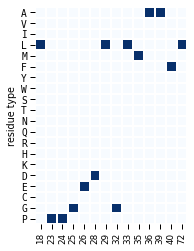

In [232]:
fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.sequence_frequency_plot(d25_3ezib_rosetta_designs, 'B', ax, refseq=False, cbar=False, xrotation=90,
                                key_residues=rsb.components.Selection('18B,23B-26B,28B,29B,32B,33B,35B,36B,39B,40B,72B'))


In [233]:
def get_fitted(header):
    return header.split(';')[-2].replace(' Conc ', '').replace(' nM', '') + header.split(';')[-1].replace('Fitted_X', 'fitted curve_X').replace('Fitted_Y', 'fitted curve_Y')
def get_raw(header):
    return header.split(';')[-1].replace(' Conc ', '').replace(' nM_', '_')

def read_spr(filename):
    df = pd.read_csv(filename, sep='\t', low_memory=False).dropna(how='all')
    df = df.replace(r'^\s*$', np.nan, regex=True)
    if len(df.columns) == 1:
        df = pd.read_csv(filename, low_memory=False).dropna(how='all')
    df.columns = [get_raw(_) if len(_.split(';')) < 7 else get_fitted(_) for _ in df.columns]
    condition = ['raw' if 'fitted' not in _ else 'fitted' for _ in df.columns]
    concentration = [_.split('_')[0].replace('fitted curve', '').strip() for _ in df.columns]
    axis = [_.split('_')[-1].strip() for _ in df.columns]
    newidx = [(x, y, z) for x, y, z in zip(condition, concentration, axis)]
    df.columns = pd.MultiIndex.from_tuples(newidx)
    df.columns.names = ['data', 'concentration', 'axis']
    df.index = range(0, df.shape[0])
    return df.astype('float64')

## SPR measurements

### Surf_03

/Users/andi/miniconda3/envs/general/lib/python3.7/site-packages/rstoolbox/plot/experimental.py:609: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  conc = sorted(set(df['fitted'].columns.labels[0]))


Text(0.5, 1.0, 'Surf_03 - D25')

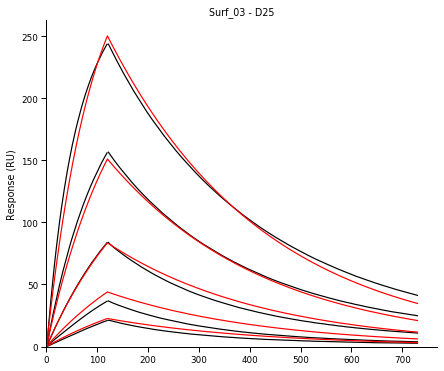

In [234]:
spr_surf_03 = read_spr('./data/rsv_site_0_design/surf03_vs_d25.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 - D25')

Text(0.5, 1.0, 'Surf_03 - ADI 14496')

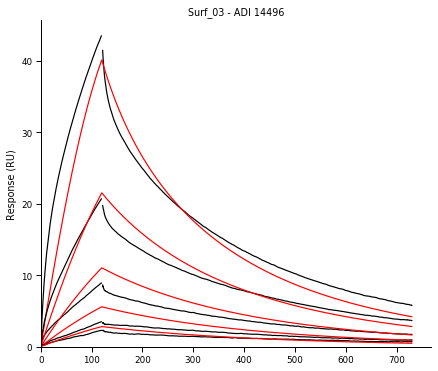

In [235]:
spr_surf_03 = read_spr('./data/rsv_site_0_design/surf03_vs_adi14496.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 - ADI 14496')

Text(0.5, 1.0, 'Surf_03 - ADI 18900')

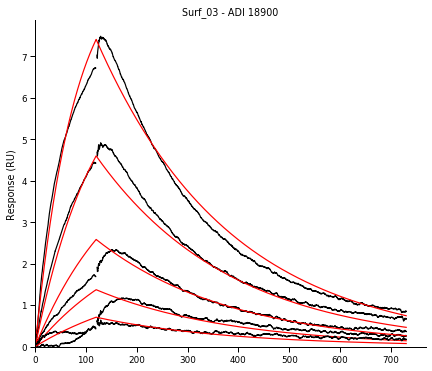

In [238]:
spr_surf_03 = read_spr('./data/rsv_site_0_design/surf03_vs_adi18900.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 - ADI 18900')

Text(0.5, 1.0, 'Surf_03 - ADI 18916')

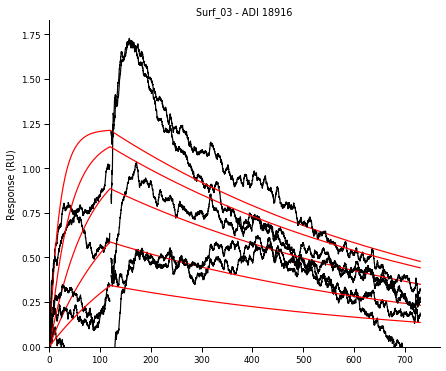

In [239]:
spr_surf_03 = read_spr('./data/rsv_site_0_design/surf03_vs_adi18916.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 - ADI 18916')

Text(0.5, 1.0, 'Surf_03 - ADI 19009')

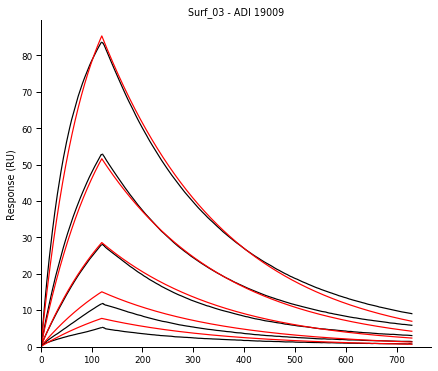

In [240]:
spr_surf_03 = read_spr('./data/rsv_site_0_design/surf03_vs_adi19009.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 - ADI 19009')

### Surf_03 KO

Text(0.5, 1.0, 'Surf_03 KO - D25')

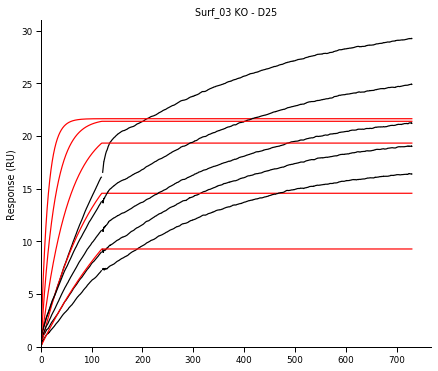

In [241]:
spr_surf_03_ko = read_spr('./data/rsv_site_0_design/surf03ko_vs_d25.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03_ko, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 KO - D25')

Text(0.5, 1.0, 'Surf_03 KO - ADI 14496')

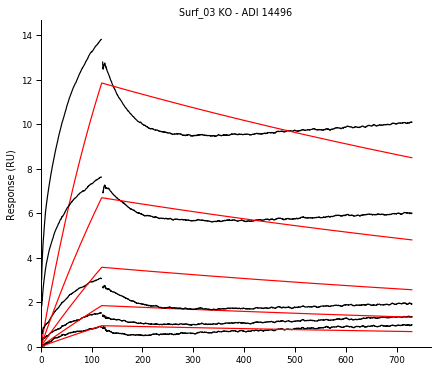

In [242]:
spr_surf_03_ko = read_spr('./data/rsv_site_0_design/surf03ko_vs_adi14496.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03_ko, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 KO - ADI 14496')

Text(0.5, 1.0, 'Surf_03 KO - ADI 18900')

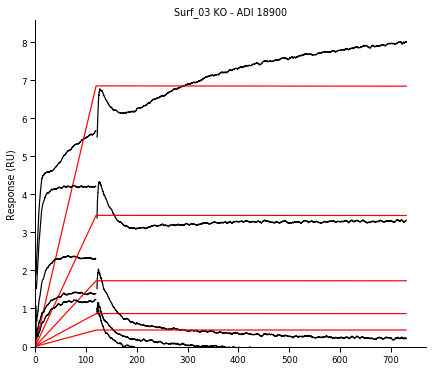

In [243]:
spr_surf_03_ko = read_spr('./data/rsv_site_0_design/surf03ko_vs_adi18900.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03_ko, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 KO - ADI 18900')

Text(0.5, 1.0, 'Surf_03 KO - ADI 18916')

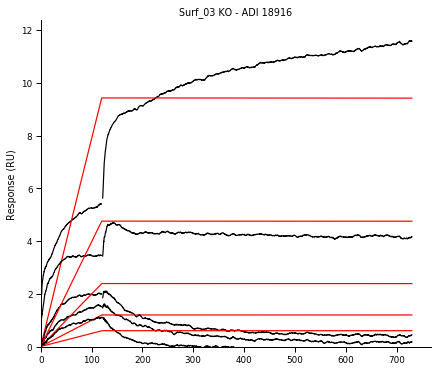

In [244]:
spr_surf_03_ko = read_spr('./data/rsv_site_0_design/surf03ko_vs_adi18916.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03_ko, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 KO - ADI 18916')

Text(0.5, 1.0, 'Surf_03 KO - ADI 19009')

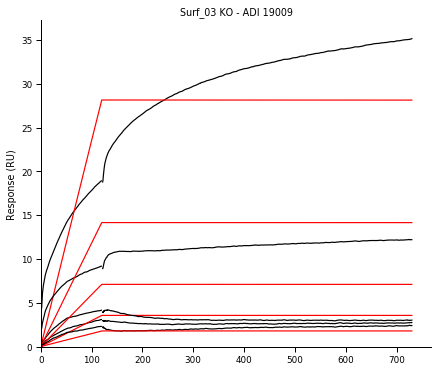

In [245]:
spr_surf_03_ko = read_spr('./data/rsv_site_0_design/surf03ko_vs_adi19009.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_surf_03_ko, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('Surf_03 KO - ADI 19009')

### RSV_helix

Text(0.5, 1.0, 'RSV_helix - D25')

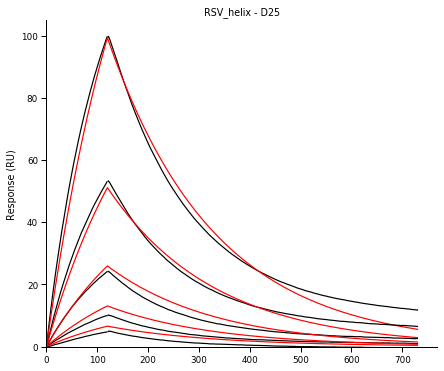

In [246]:
spr_helix = read_spr('./data/rsv_site_0_design/helix_vs_d25.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_helix, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_helix - D25')

Text(0.5, 1.0, 'RSV_helix - ADI 14496')

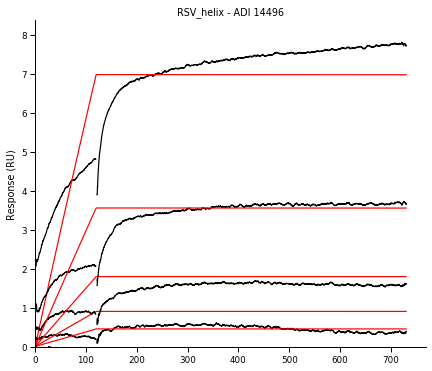

In [247]:
spr_helix = read_spr('./data/rsv_site_0_design/helix_vs_adi14496.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_helix, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_helix - ADI 14496')

Text(0.5, 1.0, 'RSV_helix - ADI 18900')

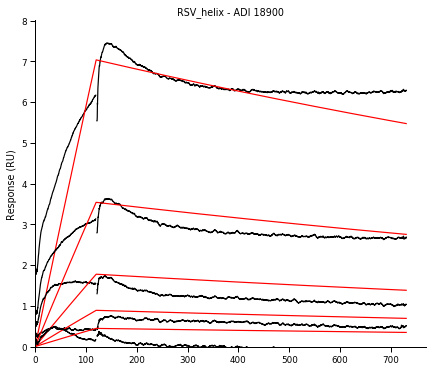

In [248]:
spr_helix = read_spr('./data/rsv_site_0_design/helix_vs_adi18900.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_helix, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_helix - ADI 18900')

Text(0.5, 1.0, 'RSV_helix - ADI 18916')

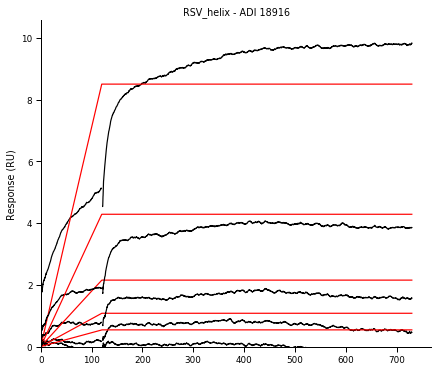

In [249]:
spr_helix = read_spr('./data/rsv_site_0_design/helix_vs_adi18916.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_helix, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_helix - ADI 18916')

Text(0.5, 1.0, 'RSV_helix - ADI 19009')

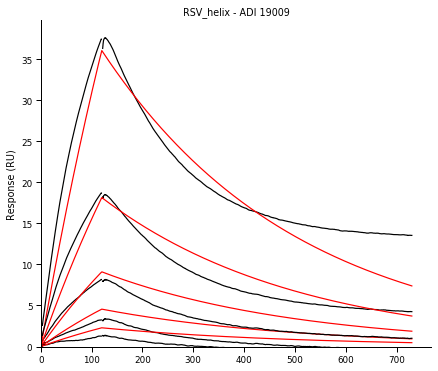

In [250]:
spr_helix = read_spr('./data/rsv_site_0_design/helix_vs_adi19009.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_helix, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_helix - ADI 19009')

### RSV_FixBB

Text(0.5, 1.0, 'RSV_FixBB - D25')

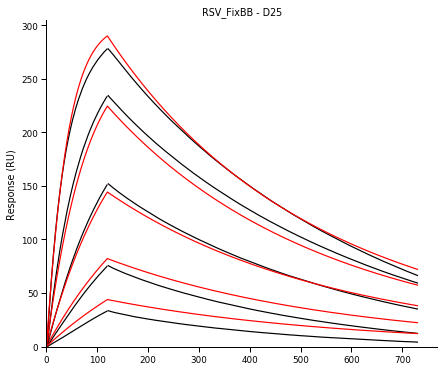

In [251]:
spr_fixbb = read_spr('./data/rsv_site_0_design/fixbb_vs_d25.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_fixbb, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_FixBB - D25')

Text(0.5, 1.0, 'RSV_FixBB - ADI 14496')

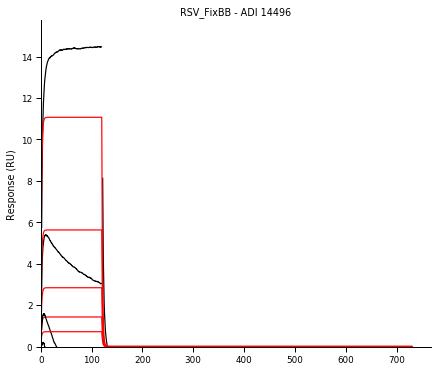

In [252]:
spr_fixbb = read_spr('./data/rsv_site_0_design/fixbb_vs_adi14496.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_fixbb, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_FixBB - ADI 14496')

Text(0.5, 1.0, 'RSV_FixBB - ADI 18900')

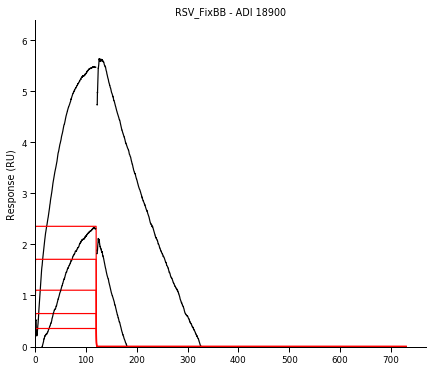

In [253]:
spr_fixbb = read_spr('./data/rsv_site_0_design/fixbb_vs_adi18900.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_fixbb, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_FixBB - ADI 18900')

Text(0.5, 1.0, 'RSV_FixBB - ADI 18916')

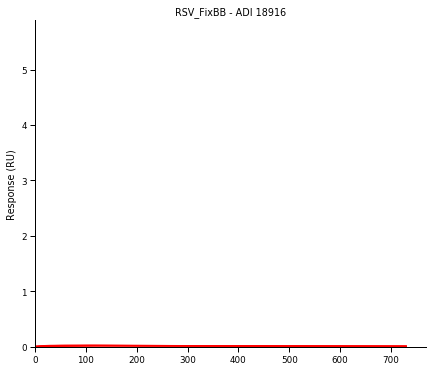

In [254]:
spr_fixbb = read_spr('./data/rsv_site_0_design/fixbb_vs_adi18916.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_fixbb, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_FixBB - ADI 18916')

Text(0.5, 1.0, 'RSV_FixBB - ADI 19009')

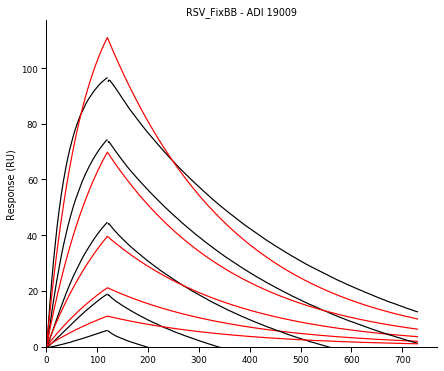

In [255]:
spr_fixbb = read_spr('./data/rsv_site_0_design/fixbb_vs_adi19009.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_fixbb, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('RSV_FixBB - ADI 19009')

### WT

Text(0.5, 1.0, 'WT - D25')

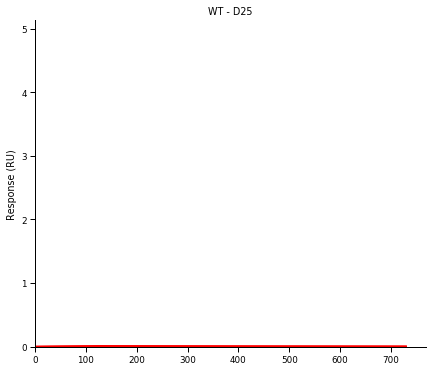

In [256]:
spr_wt = read_spr('./data/rsv_site_0_design/wt_vs_d25.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_wt, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('WT - D25')

Text(0.5, 1.0, 'WT - ADI 14496')

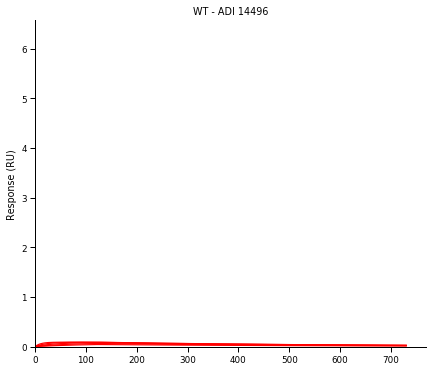

In [257]:
spr_wt = read_spr('./data/rsv_site_0_design/wt_vs_adi14496.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_wt, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('WT - ADI 14496')

Text(0.5, 1.0, 'WT - ADI 18900')

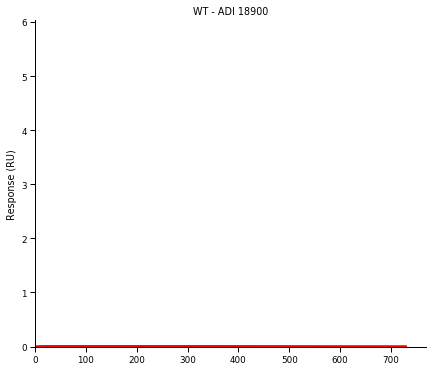

In [258]:
spr_wt = read_spr('./data/rsv_site_0_design/wt_vs_adi18900.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_wt, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('WT - ADI 18900')

Text(0.5, 1.0, 'WT - ADI 18916')

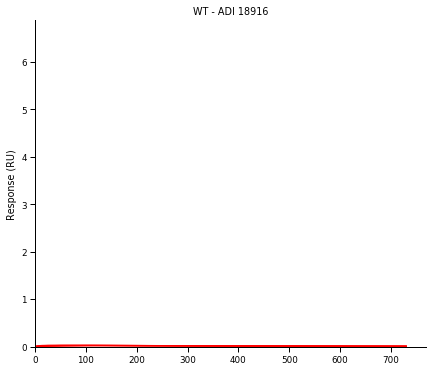

In [259]:
spr_wt = read_spr('./data/rsv_site_0_design/wt_vs_adi18916.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_wt, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('WT - ADI 18916')

Text(0.5, 1.0, 'WT - ADI 19009')

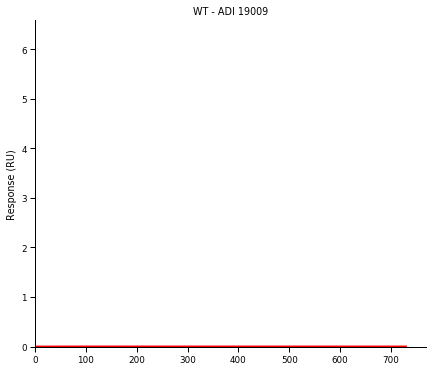

In [260]:
spr_wt = read_spr('./data/rsv_site_0_design/wt_vs_adi19009.spr')

sns.set_context('paper')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot2grid((1, 1), (0, 0))
rsb.plot.plot_SPR(spr_wt, ax, datacolor='black', fitcolor='red')

sns.despine(top=True, right=True)

plt.xlabel('')
plt.title('WT - ADI 19009')